# Разработка модели предсказывающей коэффициент восстановления золота из золотосодержащей руды

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

### Импорт библиотек

In [1]:
import time
start_time = time.time()
import pandas as pd
import numpy as np

import math
from scipy import stats as st

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# 0. Предподготовка к работе с данными

Прежде чем приступать к подготовке данных, ознакомимся с тем, что у нас вообще есть, разберемся с технологическим процессом и сформулируем исходную задачу более точно.

По ходу дела скорректируем данные так, чтобы на этап подготовки данных отправилось меньше "работы".

In [3]:
# gold_data_train = pd.read_csv('/datasets/gold_recovery_train.csv')
# gold_data_test = pd.read_csv('/datasets/gold_recovery_test.csv')
# gold_data_train.head()

gold_data_train = pd.read_csv('gold_recovery_train.csv')
gold_data_test = pd.read_csv('gold_recovery_test.csv')
gold_data_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


87 признаков выглядят крайне внушительно. К счастью, совершенно не факт, что все они понадобятся нам при разработке модели. Посмотрим на число объектов и наличие пропусков.

In [4]:
gold_data_train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [5]:
gold_data_train.count().min()

14287

In [6]:
(gold_data_train.count().min() * 100 / gold_data_train.count()).min()

84.73902728351126

В наличиие 4 группы признаков, каждая из которых соответствует этапу производства:
- флоатация (черновое обогащение руды) - rougher;
- первичная очистка концентрата - primary_cleaner;
- вторичная очистка концентрата - secondary_cleaner;
- финальный этап - final.

Также в название признака входит описание ТИПА параметра:
- параметры СЫРЬЯ - input - по сути, все ВХОДНЫЕ характеристики этапа, которые так или иначе будут участвовать в процессе обучения модели;
- параметры ПРОДУКТА - output - среди признаков с данным "шильдиком" мы должны искать целевые признаки обоих интересующих нас этапов - чернового обогащения и очистки;
- параметры СОСТОЯНИЯ этапа - state - с высокой долей вероятности эти признаки также будут участвовать в обучении модели. Более точно можно будет сказать при дальнейшем изучении данных;
- РАСЧЕТНЫЕ параметры - calculation - а вот эти признаки почти наверняка НЕ будут участвовать в расчете модели. Однако и это в настоящий момент не точно.

В нашем распоряжении 16860 объектов ВСЕГО, при этом нижняя граница "заполненности" датасета составляет 14287 - около 85% от исходных данных. И это без учета возможных выбросов, аномалий и т.п. По ходу проекта подумаем, что с этим можно сделать.

# 1. Подготовка данных

## 1.1 Проверка правильности расчета коэффициента обогащения (флоатация)

Итак, с данными мы ознакомились, переходим к расчету эффективности обогащения. 
В расчете будут участвовать следующие признаки:
- rougher.input.feed_au - доля  золота в сырье до флотации;
- rougher.output.concentrate_au - доля золота в концентрате после флоатации;
- rougher.output.tail_au - доля золота в отвальном хвосте после флоатации.

Целевой признак находится в столбце "rougher.output.recovery".

Вынесем интересующие нас признаки в отдельный датасет и найдем значения интересующего нас признака.

In [7]:
recovery_calculation = pd.DataFrame()

recovery_calculation['concentrate'] = gold_data_train['rougher.output.concentrate_au']
recovery_calculation['feed'] = gold_data_train['rougher.input.feed_au']
recovery_calculation['tail'] = gold_data_train['rougher.output.tail_au']
recovery_calculation['recovery'] = gold_data_train['rougher.output.recovery']

recovery_calculation['recovery_calc'] = (recovery_calculation['concentrate'] * 
                                         (recovery_calculation['feed'] - recovery_calculation['tail']) * 100 / 
                                        recovery_calculation['feed'] / 
                                        (recovery_calculation['concentrate'] - recovery_calculation['tail']))

recovery_calculation.head(10)

,concentrate,feed,tail,recovery,recovery_calc
0,19.793808,6.486150,1.170244,87.107763,87.107763
1,20.050975,6.478583,1.184827,86.843261,86.843261
2,19.737170,6.362222,1.162562,86.842308,86.842308
3,19.320810,6.118189,1.079755,87.226430,87.226430
4,19.216101,5.663707,1.012642,86.688794,86.688794
5,18.950385,5.687168,0.915835,88.156912,88.156912
6,19.319591,6.038436,0.986248,88.168065,88.168065
7,19.507897,6.433854,1.116110,87.668336,87.668336
8,19.789465,6.526612,1.186780,87.035862,87.035862
9,19.497669,6.633002,1.167140,87.650868,87.650868


На первый взгляд, расхождений между расчетными значениями целевого признака и "имеющимися" значениями нет - на 6 знаков после запятой. Не будем доверять глазам, доверимся машине. Найдем MAE между этими столбцами.

Но перед этим проверим столбцы (входные, расчетный и целевой) на наличие пропусков и аномалий. 

In [8]:
recovery_calculation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 5 columns):
concentrate      16778 non-null float64
feed             16777 non-null float64
tail             14611 non-null float64
recovery         14287 non-null float64
recovery_calc    14577 non-null float64
dtypes: float64(5)
memory usage: 658.7 KB


Всю эту картину мы уже видели прежде. На данном этапе нам необходимо оценить MAE для расчетного и "исходного" столбцов, поэтому удалим все имеющиеся объекты с пропусками и посмотрим на ошибку. На данном этапе этого вполне достаточно.

In [9]:
recovery_calculation_clean = recovery_calculation.dropna()
recovery_calculation_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14287 entries, 0 to 16859
Data columns (total 5 columns):
concentrate      14287 non-null float64
feed             14287 non-null float64
tail             14287 non-null float64
recovery         14287 non-null float64
recovery_calc    14287 non-null float64
dtypes: float64(5)
memory usage: 669.7 KB


Найдем MAE для данных без пропусков.

In [10]:
mean_absolute_error(recovery_calculation_clean['recovery'], recovery_calculation_clean['recovery_calc'])

1.1223393523356314e-14

10 в МИНУС 14 степени. В нашем случае можно наверняка утверждать, что эффективность обогащения рассчитана верно. 
Более того, можно предположить, что коэффициент восстановления наверняка рассчитывался НЕПОСРЕДСТВЕННО по имеющимся у нас данным, а ошибка - лишь следствие сокращений (числа знаков после запятой) при расчете.

Также следует отметить, что наименьшее значение "наполненных" ячеек - полноценных объектов, которые почти наверняка можно СХОДУ использовать для разработки модели (или с минимальной предобработкой), соответствует как раз расчетному столбцу "recovery" (см. 2 строки ниже). И эта история справедлива как для нашей "выборки", так и для всего датасета в целом.

При этом, расчетными методами нам удалось получить не 14287, а 14577 значений коэффициента восстановления концентрата из руды.

Чисто из любопытства, обратимся к этим "лишним" расчетным ячейкам и посмотрим - какие там имеются значения и, возможно, сможем что-то из этого понять. 

In [11]:
recovery_calculation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 5 columns):
concentrate      16778 non-null float64
feed             16777 non-null float64
tail             14611 non-null float64
recovery         14287 non-null float64
recovery_calc    14577 non-null float64
dtypes: float64(5)
memory usage: 658.7 KB


In [12]:
gold_data_train.count().min()

14287

In [13]:
index_fill = recovery_calculation[recovery_calculation['recovery_calc'].isna() == False]['recovery_calc'].index
recovery_calculation_fill = recovery_calculation.loc[index_fill]
recovery_calculation_fill[recovery_calculation_fill['recovery'].isna()]

,concentrate,feed,tail,recovery,recovery_calc
53,3.507147,7.548341,2.187465,NaN,188.742102
372,4.642559,0.139652,2.574309,NaN,-3913.312866
377,15.084039,3.501578,5.964024,NaN,-116.312118
560,19.619751,1.921101,1.939904,NaN,-1.086185
700,1.483835,0.253075,1.477470,NaN,-112789.873301
...,...,...,...,...,...
16697,6.038533,11.035269,1.343570,NaN,112.957805
16698,10.712677,10.943209,1.858404,NaN,100.442153
16699,0.010000,10.149224,1.729189,NaN,-0.482567
16700,0.010000,10.591710,1.481931,NaN,-0.584325


Причина отсутствия "исходных" значений коэффициента восстановления и наличия "расчетных" очевидна - ошибка или опечатка в исходных значениях привела к наличию "глубоко положительных" и "глубоко отрицательных" значений. 

К тому же в нашем случае это крайне маловероятная (и финансово невыгодная) история, когда после обогащения у нас получается материал, содержащий золота МЕНЬШЕ, чем изначально. Как следствие, все объекты, для которых наблюдается "обеднение золоторудной смеси" должны быть удалены, а соответствующая "проблема" сообщена тому, кто ответственен за сам технологический процесс (датчики, уровни и т.п.) и получение данных.

Аналогичная история - с "хвостами", в которых остается золотой руды больше (по концентрации), чем в исходном сырье. С одной стороны - да, такое ТОЖЕ теоретически (да и практически) возможно. Однако, как говорил один персонаж - "Не в мою смену!"

И, наконец, третья история - НУЛЕВЫЕ или ОКОЛОнулевые значения содержания золота как в столбце "концентрат", так и "сырье" (см. гистограмму ниже). И если с сырьем определенная логика СУЩЕСТВОВАНИЯ близких к 0 значений всё же может существовать - мы ведь не просто так занимаемся его обогащением, то с концентратом она отсутствует в принципе. 

Ошибка расчета? Технический сбой? На данном этапе это не имеет особого значения, т.к. сделать с ними мы ничего не можем. Но логика поведения в подобной ситуации достаточно очевидна - сообщить о проблеме, рассказать о возможных причинах и, при необходимости, давать обратную связь.

C:\Dev\lib\site-packages\pandas\plotting\_matplotlib\hist.py:316: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


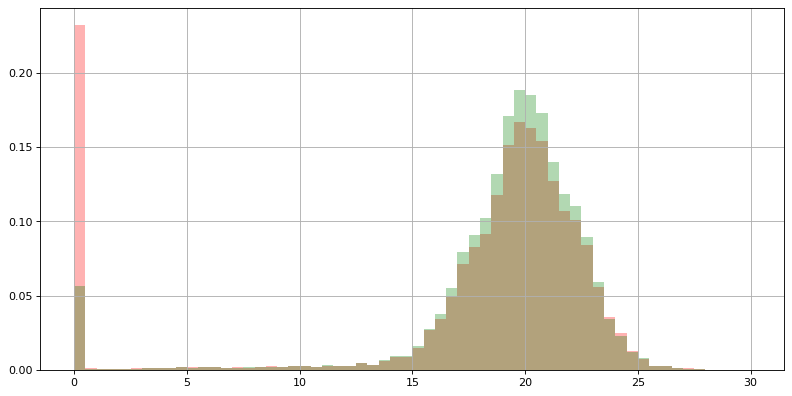

In [14]:
plt.figure(figsize = (12,6), dpi = 80)
recovery_calculation['concentrate'].hist(alpha = 0.3, normed = True, color = 'red', range = (0,30), bins = 60)
recovery_calculation_fill['concentrate'].hist(alpha = 0.3, normed = True, color = 'green', range = (0,30), bins = 60)

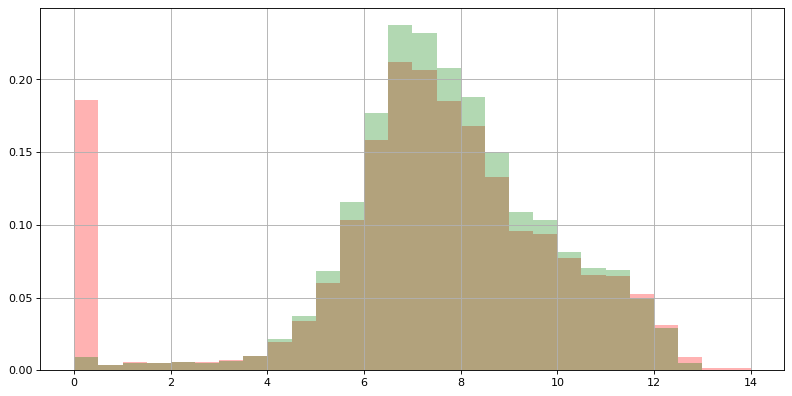

In [15]:
plt.figure(figsize = (12,6), dpi = 80)
recovery_calculation['feed'].hist(alpha = 0.3, normed = True, color = 'red', range = (0,14), bins = 28)
recovery_calculation_fill['feed'].hist(alpha = 0.3, normed = True, color = 'green', range = (0,14), bins = 28)

Все объекты, соответствующие озвученной логике - нулевые и околонулевые, БОЛЬШИЕ хвосты, маленькие концентраты и т.п. - будем удалять. На этапе предобработки.

Но сперва обратимся к датасету с тестовыми данными и сравним их с тренировочными.

## 1.2 Исследование тестовой выборки

In [16]:
gold_data_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [17]:
gold_data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

53 признака вместо 87. Вспоминая "предисловие" проекта, можем предположить, что среди 34 отсутствующих признаков имеются расчетные. А значит, они могут являться "зависимыми" - как следствие, для обучения модели они бесполезны, т.к. могут приводить к переобучению, повышению сложности модели, а также длительности обучения. 

Для начала посмотрим, каких признаков у нас "нет" в тестовой выборке и попробуем разобраться в причинах происходящего, а также тем, что нам дальше делать.

In [18]:
train_clmns = pd.Series(gold_data_train.columns)
test_clmns = pd.Series(gold_data_test.columns)
clmns_delta = train_clmns.isin(test_clmns)

train_clmns[clmns_delta[clmns_delta == False].index]

1                           final.output.concentrate_ag
2                           final.output.concentrate_pb
3                          final.output.concentrate_sol
4                           final.output.concentrate_au
5                                 final.output.recovery
6                                  final.output.tail_ag
7                                  final.output.tail_pb
8                                 final.output.tail_sol
9                                  final.output.tail_au
14                primary_cleaner.output.concentrate_ag
15                primary_cleaner.output.concentrate_pb
16               primary_cleaner.output.concentrate_sol
17                primary_cleaner.output.concentrate_au
18                       primary_cleaner.output.tail_ag
19                       primary_cleaner.output.tail_pb
20                      primary_cleaner.output.tail_sol
21                       primary_cleaner.output.tail_au
30        rougher.calculation.sulfate_to_au_conc

В тестовой выборке отсутствуют значения "расчетных" и "продуктных" (выходных) признаков. 

Для лучшего понимания, разделим ВСЕ имеющиеся у нас признаки (а таковых 87 штук) по принадлежности к этапу и типу, посчитаем и занесем в таблицу.

Если признаков данного типа на данном этапе нет в ячейке таблицы будет стоять прочерк. 

В названии столбцов - этапы, в строчках - типы. 

In [19]:
types_columns = ["rougher", "primary_cleaner", "secondary_cleaner", "final"]
stage_axis = ["input", "state", "calculation", "output"]

compar_table = pd.DataFrame(columns = types_columns, index = stage_axis).fillna(0)


for types in types_columns:
    for stage in stage_axis:
        for row in train_clmns:
            if (types in row) and (stage in row):
                compar_table[types][stage] += 1

compar_table.loc['sum'] = compar_table['input':'output'].sum()
compar_table

,rougher,primary_cleaner,secondary_cleaner,final
input,10,4,0,0
state,12,8,18,0
calculation,4,0,0,0
output,9,8,4,9
sum,35,20,22,9


86 признаков (не 87, как было изначально - отсутствует признак с датой) - 35 на этапе флоатации, 42 на этапах очистки, 9 на финальном этапе.

Учитывая, что итоговая метрика складывается из метрик 2 различных моделей, очевидно, что часть признаков типа "output" можно будет убрать, т.к. при расчете эффективности обогащения золотой руды, нас не особо интересует количество получаемого свинца, серебра и т.п. - такой задачи просто не стоит. По той же логике могут быть устранены расчетные и "состоянческие" признаки.

Тем не менее, на этапе предобработки данных следует избавиться от пропусков, значений, выходящих за пределы стат. значимости, а также признаков, которые ТОЧНО не будут использованы при последующей разработке модели. Начнем.

## 1.3 Предобработка данных

Поскольку нам необходимо получить 2 модели машинного обучения, а также для того, чтобы не перегружать собственные мысли (не сойти с ума), разделим датасет из 87 признаков на 2 части - первая будет соответствовать этапу флоатации, а второй - последующей очистке + финальной стадии.

In [20]:
all_columns = pd.Series(gold_data_train.columns)
rougher_columns = []
cleaner_columns = []

for column_name in gold_data_train.columns:
    if 'rougher' in column_name:
        rougher_columns.append(column_name)
    else:
        cleaner_columns.append(column_name)

rougher_columns_series = pd.Series(rougher_columns)
rougher_columns_series.head()

0        rougher.calculation.sulfate_to_au_concentrate
1    rougher.calculation.floatbank10_sulfate_to_au_...
2    rougher.calculation.floatbank11_sulfate_to_au_...
3                      rougher.calculation.au_pb_ratio
4                                rougher.input.feed_ag
dtype: object

In [21]:
gold_data_train_rougher = gold_data_train[rougher_columns]
gold_data_train_rougher

,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
0,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,...,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636
1,42050.861809,3498.370979,3489.981857,2.858998,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,...,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001
2,42018.101184,3495.348910,3502.359819,2.945989,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,...,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147
3,42029.447991,3498.578313,3499.162912,3.002340,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189,...,1600.059442,-450.619948,1600.012842,-449.910497,1597.725177,-450.130127,1400.943157,-450.030142,1400.234743,-449.790835
4,42125.354245,3494.800771,3506.679315,3.169615,6.060915,1.786875,540.531893,56.047189,34.347666,5.663707,...,1600.208824,-449.599614,1600.357732,-450.034364,1599.759049,-449.909799,1401.560902,-448.877187,1401.160227,-450.407128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,45912.942619,2497.652954,2499.177950,1.155559,6.091855,4.617558,560.889077,85.718304,37.369774,5.335862,...,1149.807890,-498.789721,1047.963596,-498.413079,946.640977,-499.152477,849.664935,-499.214461,849.758091,-497.448664
16856,46200.099585,2614.403937,2518.550078,1.167342,6.121323,4.144989,559.031805,119.499241,38.591551,4.838619,...,1147.675196,-500.608341,1048.565741,-500.932810,949.773589,-500.023144,848.515225,-500.289405,850.013123,-496.822119
16857,44585.181334,2510.813545,2510.142433,1.125637,5.970515,4.020002,555.682872,122.262690,40.074026,4.525061,...,1149.942902,-501.717903,1049.604390,-500.549053,952.702732,-502.352296,849.016017,-500.505677,850.455635,-506.897968
16858,44084.735708,2507.572494,2507.723361,1.117935,6.048130,3.902537,544.731687,123.742430,39.713906,4.362781,...,1154.087804,-500.036580,1054.009756,-500.237335,944.138793,-496.866953,851.589767,-499.040466,851.345606,-499.122561


Первый датасет, соответствующий этапу флоатации, получен. 35 столбцов, 16860 объектов.

Время второго датасета.

In [22]:
gold_data_train_cleaner = gold_data_train[cleaner_columns]
gold_data_train_cleaner

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
16856,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
16857,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
16858,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


51 искомый признак + дата. Дата не понадобится - удаляем и переходим к предобработке датасета на этапе "грубой" очистки. Вообще, поскольку мы получили 2 "отдельных" датасета и каких-то особенностей предобработки для них на первый взгляд не предвидится, имеет смысл всю последующую процедуру собрать в виде единой функции предобработки, "работающей" на необработанном датасете. 

Помним про это и начинаем предобработку.

In [23]:
gold_data_train_cleaner = gold_data_train_cleaner.drop(['date'], axis = 1)
gold_data_train_cleaner.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


### 1.3.1 Флоатация

In [24]:
gold_data_train_rougher.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 35 columns):
rougher.calculation.sulfate_to_au_concentrate         16833 non-null float64
rougher.calculation.floatbank10_sulfate_to_au_feed    16833 non-null float64
rougher.calculation.floatbank11_sulfate_to_au_feed    16833 non-null float64
rougher.calculation.au_pb_ratio                       15618 non-null float64
rougher.input.feed_ag                                 16778 non-null float64
rougher.input.feed_pb                                 16632 non-null float64
rougher.input.feed_rate                               16347 non-null float64
rougher.input.feed_size                               16443 non-null float64
rougher.input.feed_sol                                16568 non-null float64
rougher.input.feed_au                                 16777 non-null float64
rougher.input.floatbank10_sulfate                     15816 non-null float64
rougher.input.floatbank10_xanthate          

Как отмечал ранее, столбцы с расчетными значениями уже тем или иным образом ВКЛЮЧЕНЫ в имеющиеся данные - т.е. находятся в зависимости от остальных значений. Оставлять их в рамках обучающего датасета не вижу смысла - удаляем. 

Они занимают первые 4 столбца датасета - оставим всё, начиная с 5го столбца. 

In [25]:
train_rougher_no_calc = gold_data_train_rougher.loc[:, 'rougher.input.feed_ag':]
train_rougher_no_calc

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
0,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,...,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636
1,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.996163,6.012594,...,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001
2,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.920305,6.204633,...,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147
3,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189,11.630094,6.203177,11.692450,6.196578,...,1600.059442,-450.619948,1600.012842,-449.910497,1597.725177,-450.130127,1400.943157,-450.030142,1400.234743,-449.790835
4,6.060915,1.786875,540.531893,56.047189,34.347666,5.663707,10.957755,6.198826,10.960521,6.194897,...,1600.208824,-449.599614,1600.357732,-450.034364,1599.759049,-449.909799,1401.560902,-448.877187,1401.160227,-450.407128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,6.091855,4.617558,560.889077,85.718304,37.369774,5.335862,7.762770,9.158609,7.766744,9.156069,...,1149.807890,-498.789721,1047.963596,-498.413079,946.640977,-499.152477,849.664935,-499.214461,849.758091,-497.448664
16856,6.121323,4.144989,559.031805,119.499241,38.591551,4.838619,7.356687,9.304952,7.095508,9.297924,...,1147.675196,-500.608341,1048.565741,-500.932810,949.773589,-500.023144,848.515225,-500.289405,850.013123,-496.822119
16857,5.970515,4.020002,555.682872,122.262690,40.074026,4.525061,6.586020,9.299606,6.584130,9.300133,...,1149.942902,-501.717903,1049.604390,-500.549053,952.702732,-502.352296,849.016017,-500.505677,850.455635,-506.897968
16858,6.048130,3.902537,544.731687,123.742430,39.713906,4.362781,6.210119,9.297709,6.209517,9.297194,...,1154.087804,-500.036580,1054.009756,-500.237335,944.138793,-496.866953,851.589767,-499.040466,851.345606,-499.122561


Обратимся к сравнительной таблице, собранной ранее.

In [26]:
compar_table

,rougher,primary_cleaner,secondary_cleaner,final
input,10,4,0,0
state,12,8,18,0
calculation,4,0,0,0
output,9,8,4,9
sum,35,20,22,9


Начнем с группы признаков "input" - той информации, которая подается на "вход" этапа. 10 признаков всего. Из них 3 признака, описывающих концентрацию металлов в исходном сырье - золота, серебра и свинца, 3 - характеристики исходного сырья - размер гранул, скорость его подачи и некий "sol" (Что это?), а также 4 признака, соответствующих содержанию 2 различных веществ в 2 различных флоатационных установках - №10 и №11. 

На первый взгляд, убрать отсюда совершенно нечего. Однако, если сразу обратить внимание на группу признаков "state", мы обнаружим, что среди них отсутствуют показатели для флоатационной установки №11, зато есть значения объема воздуха и уровня жидкости для 6 состояний (от a до f) для установки №10. Совпадение? Не думаю. 

Безусловно, что данный момент требует уточнения - возможно установка №11 необходима в качестве "параллельной линии", которую используют в случае ремонта, очистки, подготовки его собрата №10. Однако, основываясь на собственном представлении о процессе (чего, безусловно, в реальных условиях делать не нужно), я принимаю решение удалить эти 2 столбца из датасета. 
>Как говорится - "Михалыч, ПОД МОЮ ОТВЕТСТВЕННОСТЬ!!1"

Сделаем это и посмотрим на "итоговое число" признаков в нашем датасете, а также перейдем к работе с пропусками, повторами и прочими не менее важными и интересными моментами. 

In [27]:
train_rougher_columns_clean = train_rougher_no_calc.drop(['rougher.input.floatbank11_sulfate',
                                                          'rougher.input.floatbank11_xanthate'], axis = 1)
train_rougher_columns_clean.head()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
0,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.500771,7.101074,...,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636
1,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.615865,7.278807,...,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001
2,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.695753,7.216833,...,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147
3,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189,11.630094,6.203177,11.915047,7.175616,...,1600.059442,-450.619948,1600.012842,-449.910497,1597.725177,-450.130127,1400.943157,-450.030142,1400.234743,-449.790835
4,6.060915,1.786875,540.531893,56.047189,34.347666,5.663707,10.957755,6.198826,12.411054,7.240205,...,1600.208824,-449.599614,1600.357732,-450.034364,1599.759049,-449.909799,1401.560902,-448.877187,1401.160227,-450.407128


С одной стороны, можно разделить датасеты на входные и целевые уже сейчас. Однако, крайне высока вероятность, что при раздельной предобработке данных, мы можем получить разные по размеру и, как следствие, совершенно не совпадающие (по индексам и количеству объектов) датасеты. 

Следовательно, куда разумней будет предобработать весь датасет полностью, и лишь затем разделить его на "вход" и "выход".

Для приведения данных в жизнеспособный вид, нам необходимо разобраться в пропусках, а также возможных причинах их возникновения - для предотвращения их появления в будущем.

Как мы помним, наибольшее число пропусков у нас в столбце со значениями признака "Коэффициент восстановления" - расчетный коэффициент и по совместительству непосредственный "участник" целевого признака всего проекта. Следовательно, именно корректность "восстановления" значений данного признака из пропусков является одним из критериев успешной реализации проекта. Следовательно, мы можем ориентироваться на значения данного признака, как ориентир - оставлять нам данный объект в датасете или от него можно избавиться, в связи с "невозможностью" в имеющихся условиях использовать его для анализа данных и обучения модели.   

Выделим из датасета объекты с пропусками в столбце "коэффициент восстановления (recovery)" и проанализируем возможные причины возникновения пропусков, а также что можно с этим сделать. 

C:\Dev\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


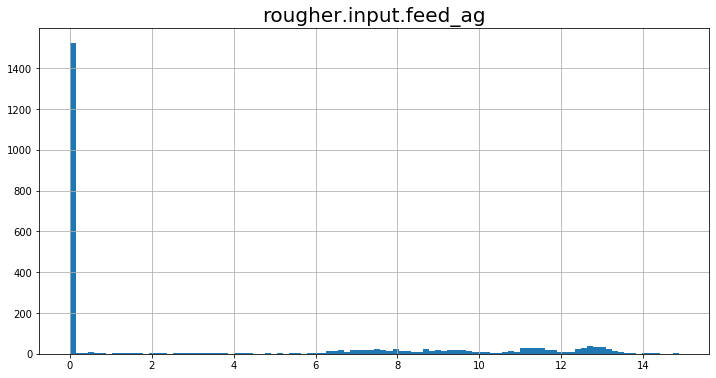

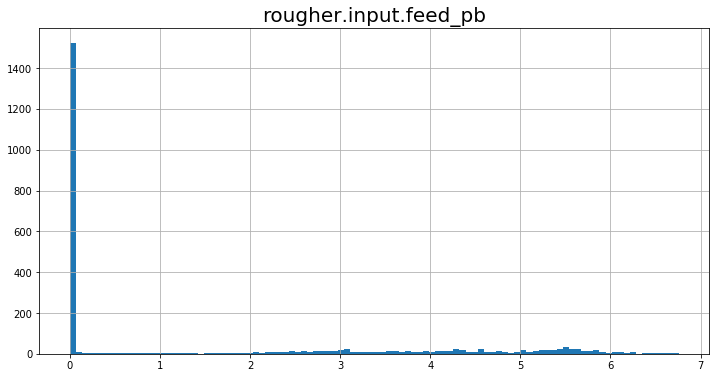

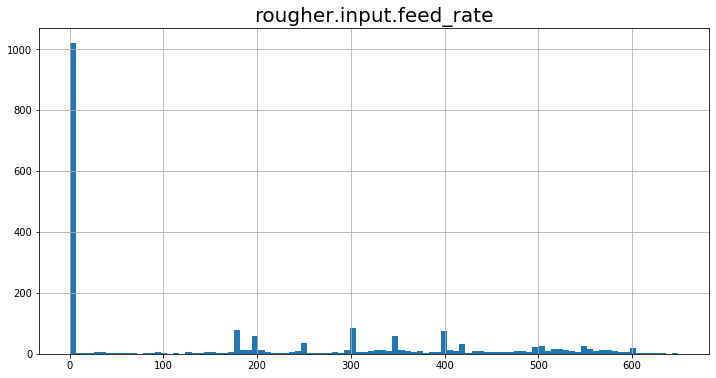

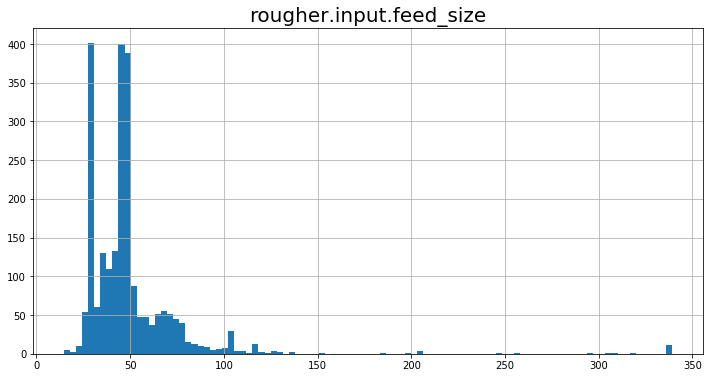

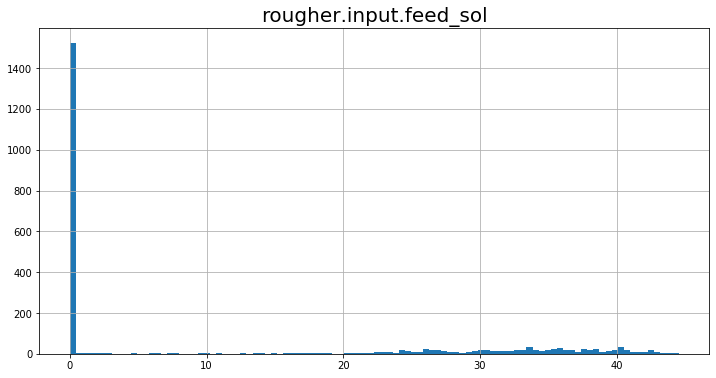

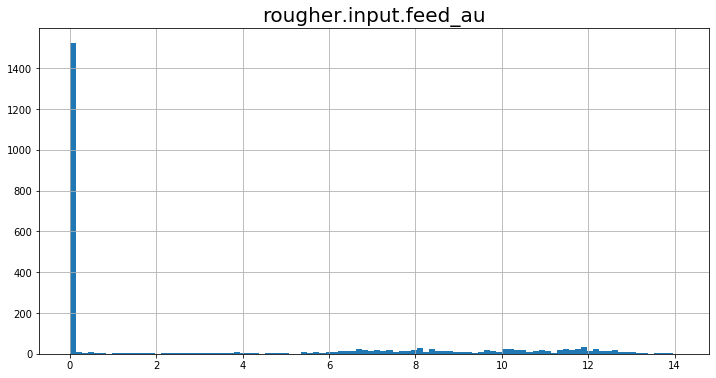

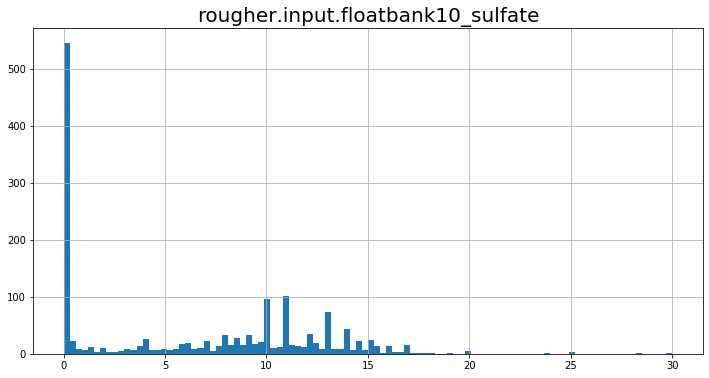

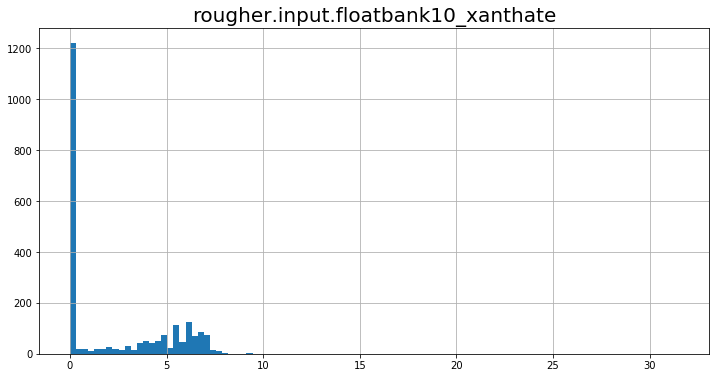

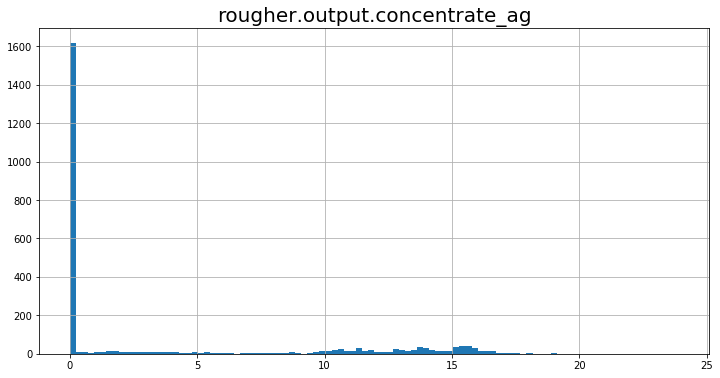

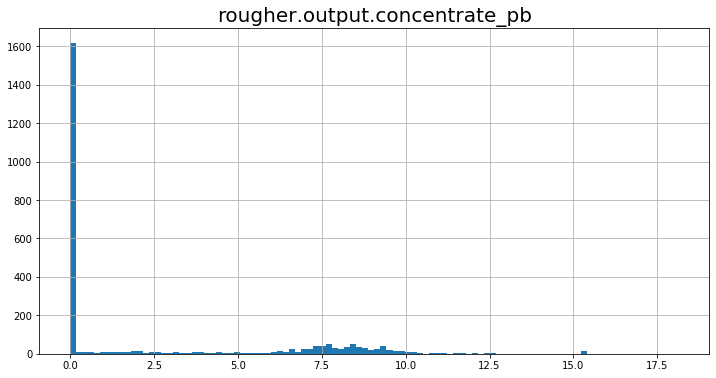

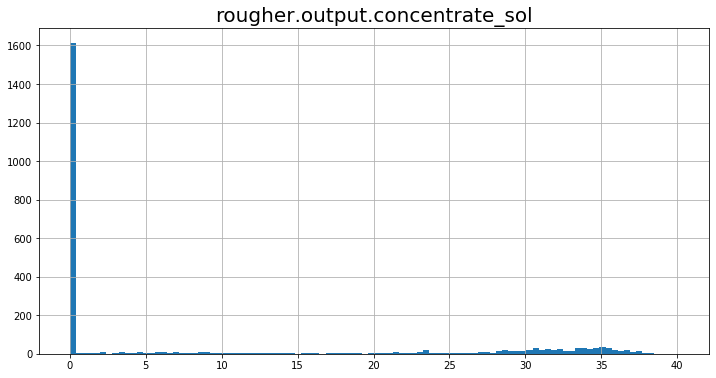

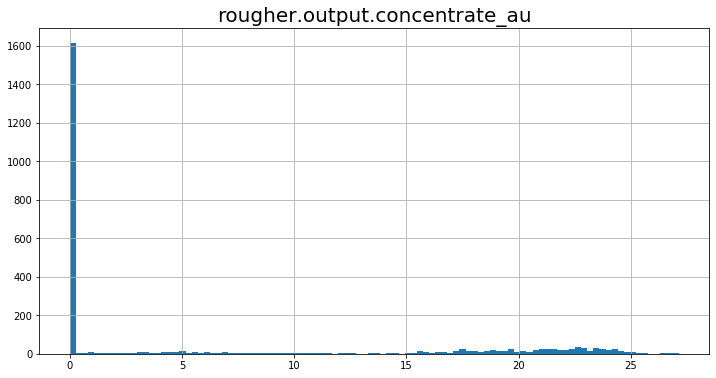

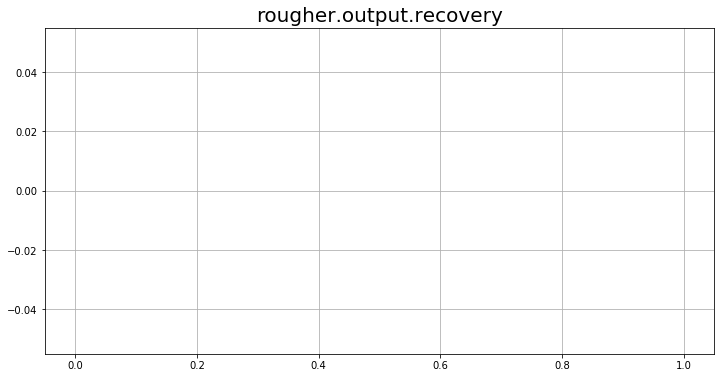

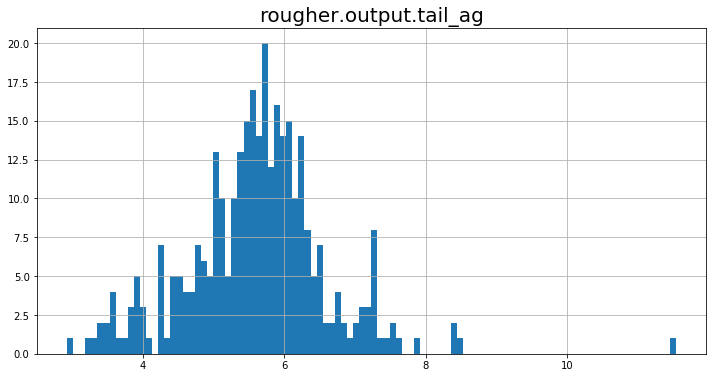

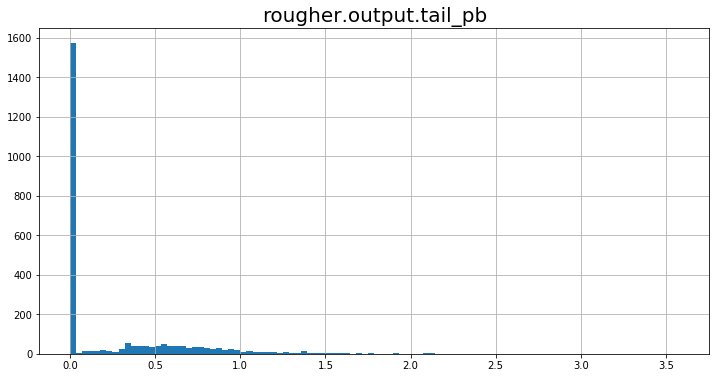

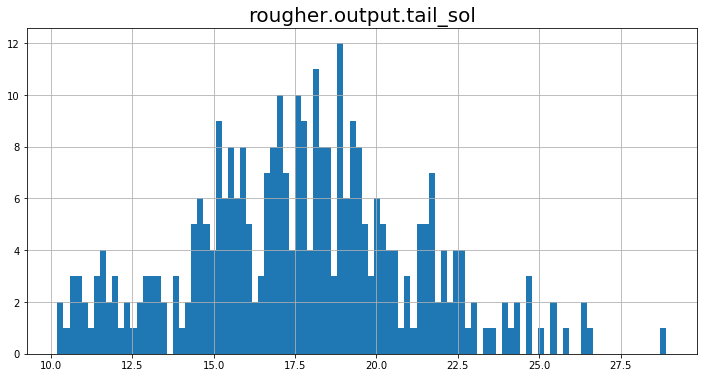

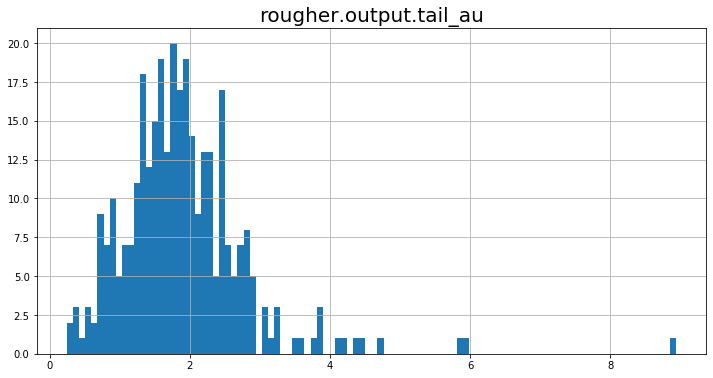

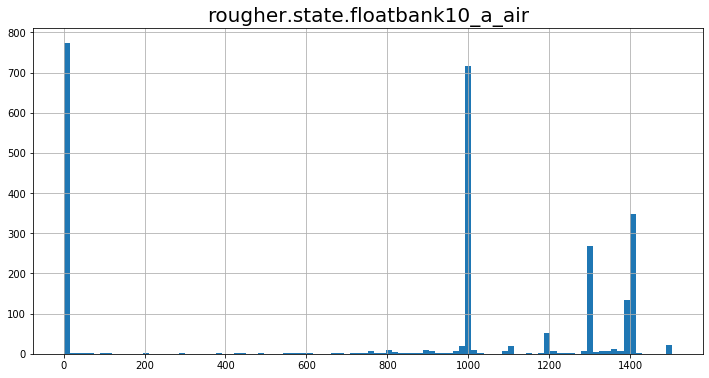

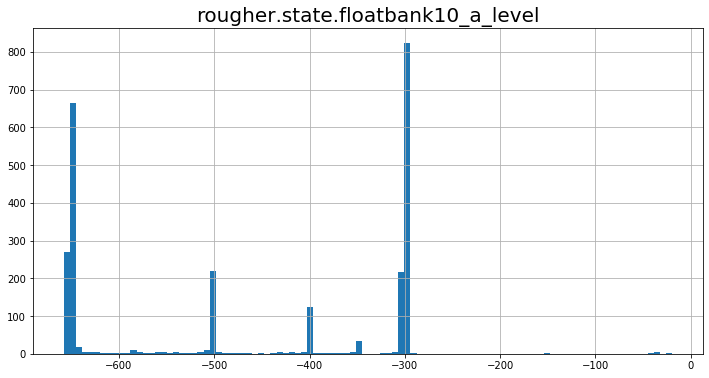

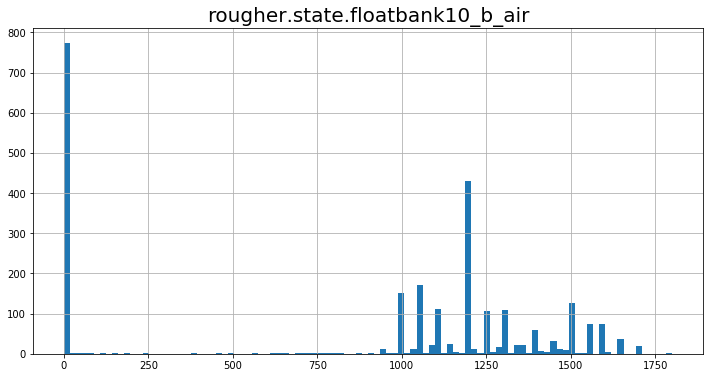

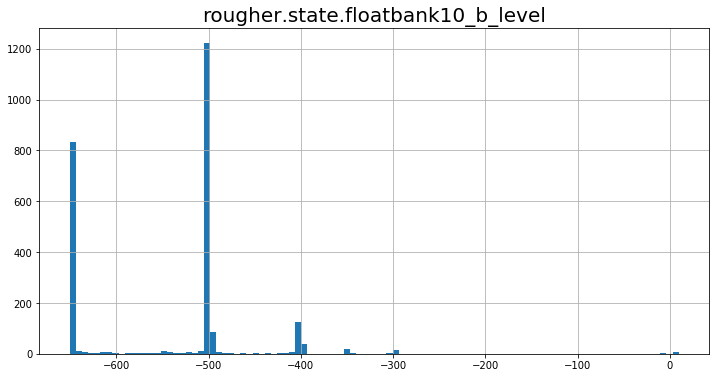

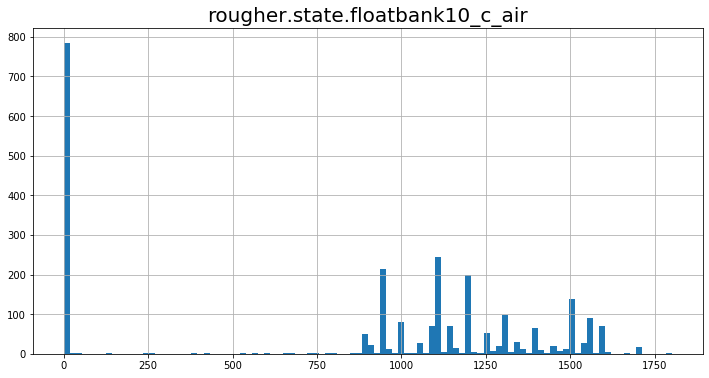

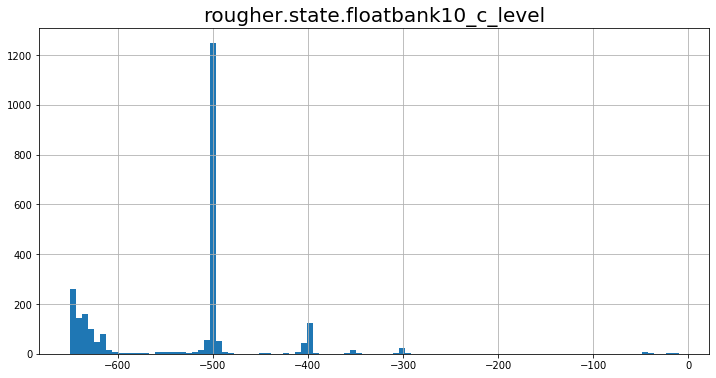

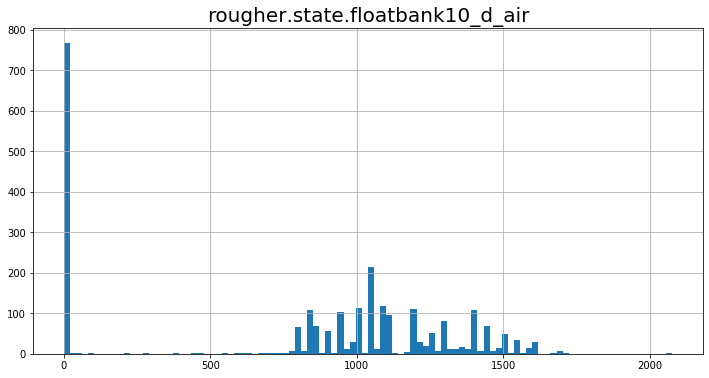

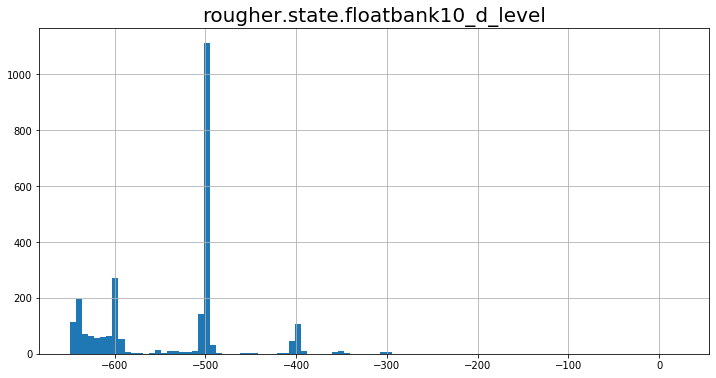

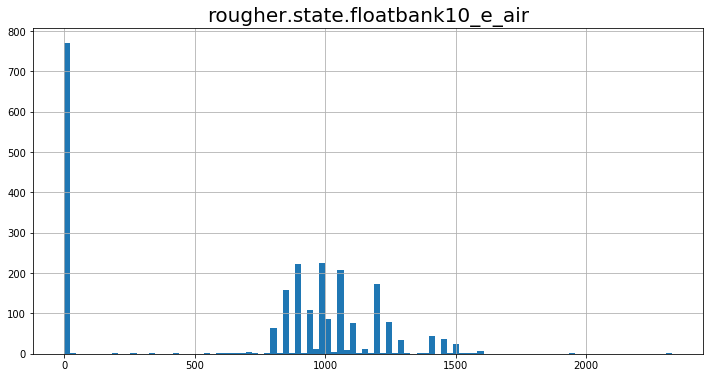

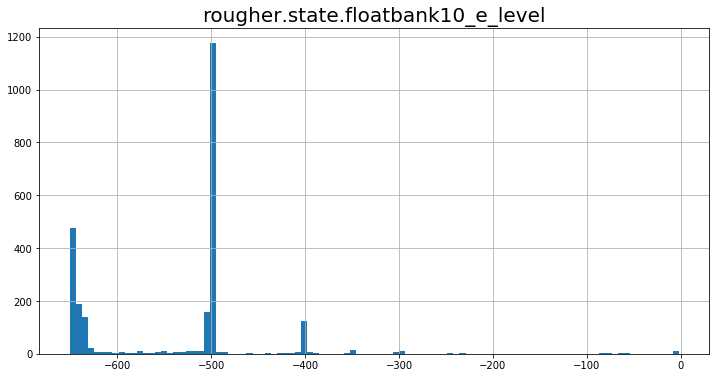

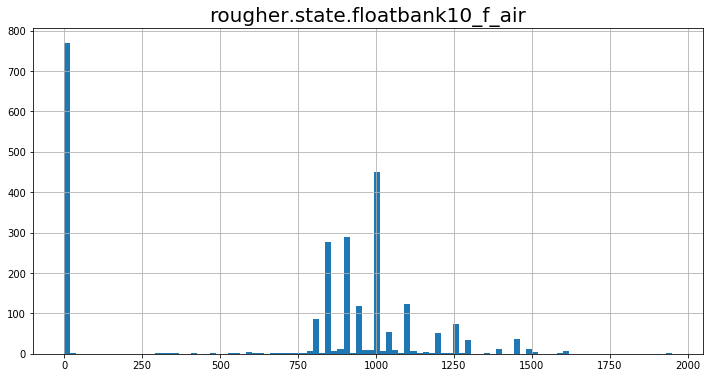

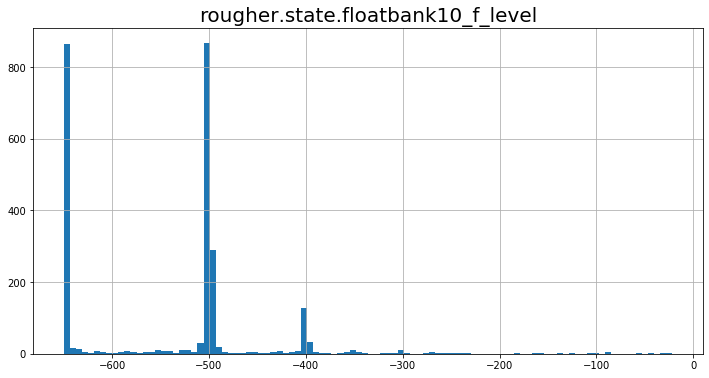

In [28]:
train_rougher_recovery_empty = train_rougher_columns_clean[train_rougher_columns_clean['rougher.output.recovery']
                                                           .isna() == True]

for column in list(train_rougher_recovery_empty.columns):
    plt.figure(figsize = (12,6))
    train_rougher_recovery_empty[column].hist(bins = 100)
    plt.title(column, fontsize = 20)
    plt.show

Первое, что бросается в глаза - огромное количество "околонулей" в одних признаках в сочетании с не меньшим числом пропусков в других. 

"Околонули" характерны для признаков с шильдиком "input", пропуски - для "output". Столбцы, описывающие "состояния" работающих установок, "в порядке". Гистограмма "recovery" пуста, как и планировалось.

Продолжая анализ, нам необходимо "свестись" ещё раз - а именно к 3 показателям - концентрации золота в сырье (input), в хвостах и в концентрате (оба - output), поскольку все они участвуют в расчете значения целевого признака "recovery". Как мы убедились ранее, он рассчитан верно, причем число (именно число!) рассчитанных "вручную" объектов не сильно отличалось от числа "объектов", с заполненным значением "recovery" во входных данных - следовательно мы можем предположить НЕвиновность процесса расчета в возникших пропусках. 

Именно поэтому, нам необходимо искать причины (или причины причин) возникших пропусков среди признаков, участвующих в расчете признака с пропусками. 

А вот обратившись к 3 озвученным выше параметрам мы сможем понять причины невозможности расчета и, при возможности, их устранить или предотвратить в будущем. 

Начнем со значений в столбце "сырьё".

Text(0.5, 1.0, 'rougher.input.feed_au')

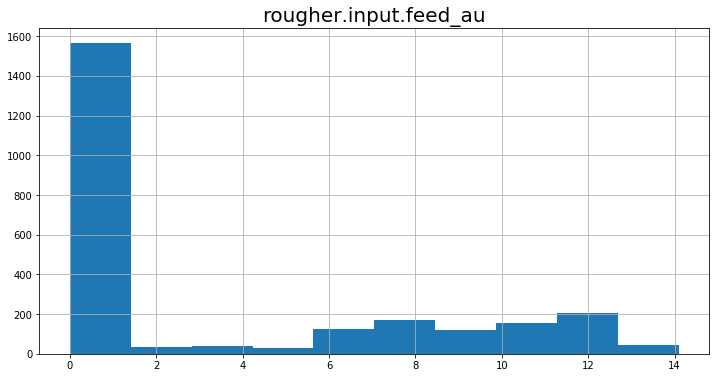

In [29]:
plt.figure(figsize = (12,6))
train_rougher_recovery_empty['rougher.input.feed_au'].hist(bins = 10)
plt.title('rougher.input.feed_au', fontsize = 20)

Как мы отмечали ранее, здесь действительно очень много "околонулей".

Приблизим нашу "лупу" и посмотрим на окрестности нуля.

Text(0.5, 1.0, 'rougher.input.feed_au')

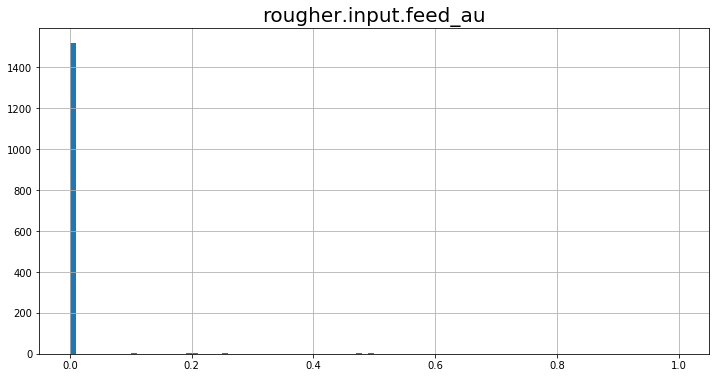

In [30]:
plt.figure(figsize = (12,6))
train_rougher_recovery_empty['rougher.input.feed_au'].hist(bins = 100, range = (0,1))
plt.title('rougher.input.feed_au', fontsize = 20)

Почти все значения в диапазоне (0,1) - нулевые. Можно ли обогатить золотую руду, не содержащую золота? Сомнительно. 

С другой стороны, можно сказать - "Но у нас же там может быть серебро или свинец! Зачем удалять?"

Ответ достаточно прост - у нас золотообогатительный комплекс. Не серебро и не свинец. Всё это - побочный продукт. Да, приятно, да, важно его учитывать. Но! Золото в приоритете. 

Потому все объекты со значениями содержания золота в сырье меньше единицы "выжигаем" из датасета и смотрим, что осталось.

Не понимая во всей полноте процесса работы данного "комбината" - откуда берутся значения концентрации золота в руде (возможно из некой лаборатории?), как и посредством чего (инструментально) собираются данные в имеющийся датасет и т.д., сложно установить точные причины возникновения пропусков. Однако, можно предположить следующие причины возникновения "нулей":
- работу флоатационных установок на "холостом ходу" - когда ничего не обрабатывается, а значения датчиков состояния (уровень и воздух) фиксируются - вот и получаются "пустые" строки;
- прерывание работы установки в процессе - когда "забыли, не долили, вспомнили что надо... и т.п.";
- человеческий фактор во всех его проявлениях;
- действительная работа установки на "пустой" руде - для отработки методики, проверки "точности" экспериментальных методов определения, работы датчиков и т.п. (хотя это крайне сомнительно, с учетом предполагаемого масштаба золотообогатительных производств и себестоимости соответствующих запусков - это вам не маленький свечной заводик).

In [31]:
train_rougher_recovery_no_feed_zero = train_rougher_recovery_empty[train_rougher_recovery_empty['rougher.input.feed_au'] > 1]
train_rougher_recovery_no_feed_zero.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 935 entries, 53 to 16701
Data columns (total 29 columns):
rougher.input.feed_ag                 935 non-null float64
rougher.input.feed_pb                 921 non-null float64
rougher.input.feed_rate               925 non-null float64
rougher.input.feed_size               927 non-null float64
rougher.input.feed_sol                834 non-null float64
rougher.input.feed_au                 935 non-null float64
rougher.input.floatbank10_sulfate     877 non-null float64
rougher.input.floatbank10_xanthate    927 non-null float64
rougher.output.concentrate_ag         935 non-null float64
rougher.output.concentrate_pb         935 non-null float64
rougher.output.concentrate_sol        888 non-null float64
rougher.output.concentrate_au         935 non-null float64
rougher.output.recovery               0 non-null float64
rougher.output.tail_ag                234 non-null float64
rougher.output.tail_pb                935 non-null float64
rougher.o

60% данных - пропуски.

Но со значениями "золотого сырья" мы "справились" - пропусков там больше нет - 935 значений из 935. 

Следующие на очереди - концентрат и "хвосты". Выделим интересующие нас признаки - "золотые" сырье, концентрат и "хвосты" в отдельный датасета и будем работать с ними "отдельно", дабы не таскать с собой постоянно ещё 26 признаков. Затем, после обработки "вернем" значения в соответствии с индексами объектов.

In [32]:
train_rougher_au = train_rougher_recovery_no_feed_zero.loc[:, ['rougher.input.feed_au',
                                                               'rougher.output.concentrate_au',
                                                               'rougher.output.tail_au']]
train_rougher_au

,rougher.input.feed_au,rougher.output.concentrate_au,rougher.output.tail_au
53,7.548341,3.507147,2.187465
129,2.436764,8.265500,NaN
130,3.818488,19.564930,NaN
131,3.331731,19.114878,NaN
132,6.203655,19.451740,NaN
...,...,...,...
16697,11.035269,6.038533,1.343570
16698,10.943209,10.712677,1.858404
16699,10.149224,0.010000,1.729189
16700,10.591710,0.010000,1.481931


Новый "косяк" - в ряде случае, у нас наблюдается не обогащение, а, напротив, обеднение золотосодержащей руды - когда содержание золота на выходе МЕНЬШЕ, чем содержание золота на входе. 

Как следствие, значения коэффициента обогащения в данном случае будет отрицательным, т.к. в числителе формулы "возникает" минус. Однако, это утверждение верно только для случае, когда в знаменателе получен плюс - т.е. когда содержание золота в сырье БОЛЬШЕ, чем в "хвосте". Поэтому мы не можем до конца быть уверены в том, что как в данных с "пропущенными" значениями концентрации, так и в "нормальных" данных отсутствуют ситуации "обеднения". Для этого нам необходимо проверить как "предобрабатываемые" объекты, так и "нормальные" объекты (для которых есть значения коэффициента обогащения).

Сделаем это, построив точечные графики зависимости "сырья" от "концентрации" и "сырья" от "хвоста" для 2 различных датасетов.  

Создадим отдельный датасет, в котором значения "коэффициента восстановления" на месте.

In [33]:
train_rougher_recovery_fill = train_rougher_columns_clean[train_rougher_columns_clean['rougher.output.recovery']
                                                           .isna() == False]
train_rougher_recovery_fill.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14287 entries, 0 to 16859
Data columns (total 29 columns):
rougher.input.feed_ag                 14287 non-null float64
rougher.input.feed_pb                 14164 non-null float64
rougher.input.feed_rate               14274 non-null float64
rougher.input.feed_size               14138 non-null float64
rougher.input.feed_sol                14191 non-null float64
rougher.input.feed_au                 14287 non-null float64
rougher.input.floatbank10_sulfate     14256 non-null float64
rougher.input.floatbank10_xanthate    14278 non-null float64
rougher.output.concentrate_ag         14287 non-null float64
rougher.output.concentrate_pb         14287 non-null float64
rougher.output.concentrate_sol        14261 non-null float64
rougher.output.concentrate_au         14287 non-null float64
rougher.output.recovery               14287 non-null float64
rougher.output.tail_ag                14286 non-null float64
rougher.output.tail_pb               

Как мы видим, здесь пропусков практически нет (за исключением "уровневого" столбца воздуха емкости №E). 

Строим графики.

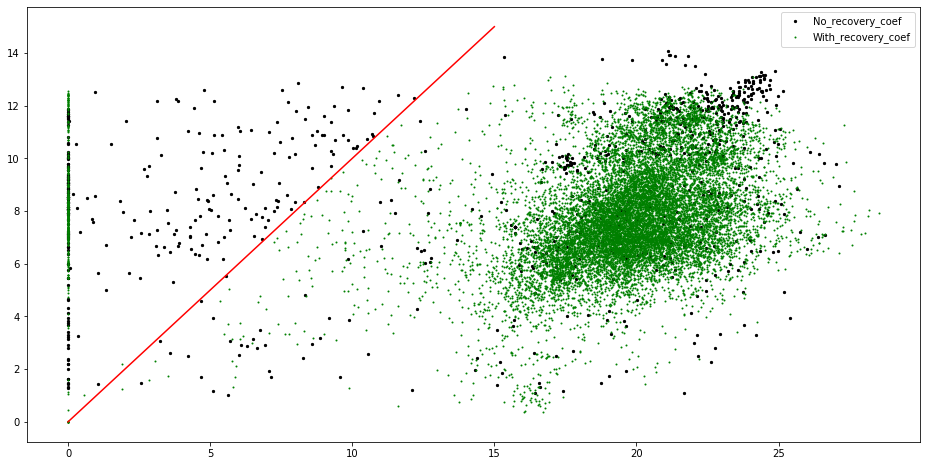

In [34]:
plt.figure(figsize = (16,8))
plt.scatter(train_rougher_au['rougher.output.concentrate_au'],
            train_rougher_au['rougher.input.feed_au'], color = 'black', s = 5)
plt.scatter(train_rougher_recovery_fill['rougher.output.concentrate_au'],
            train_rougher_recovery_fill['rougher.input.feed_au'], color = 'green', s = 1)
plt.legend(['No_recovery_coef', 'With_recovery_coef'])
x = np.linspace(0, 15, 100)
y = x
plt.plot(x,y, color = 'red')
plt.show()

Обратите внимание - в обоих датасетах присутствуют области, в которых значения содержания золота в концентрате равны нулю. При этом ТОЛЬКО в датасете с отсутствующими значениями коэффицента восстановления (за исключением буквально 10 объектов), имеются примеры "обеднения" золотой руды. 

Следовательно, можно предположить, что они там отсутствуют "не просто так". 

Теперь посмотрим на идентичный график с точки зрения "хвостов".

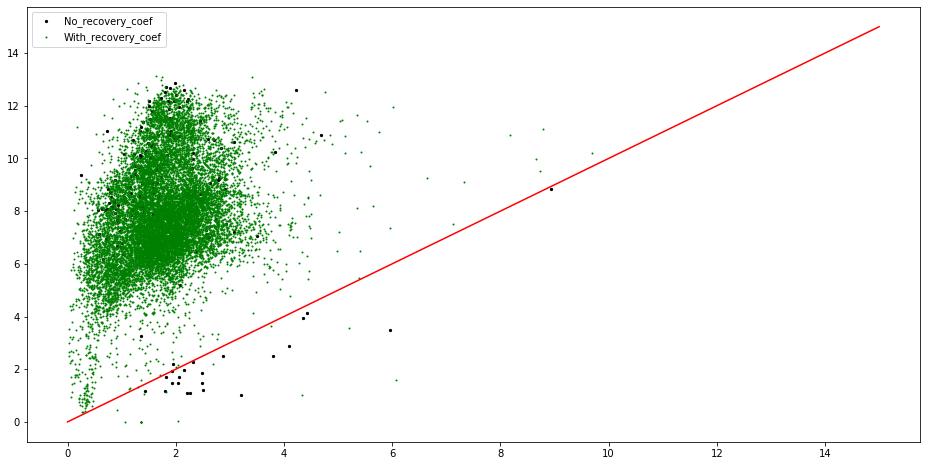

In [35]:
plt.figure(figsize = (16,8))
plt.scatter(train_rougher_au['rougher.output.tail_au'],
            train_rougher_au['rougher.input.feed_au'], color = 'black', s = 5)
plt.scatter(train_rougher_recovery_fill['rougher.output.tail_au'],
            train_rougher_recovery_fill['rougher.input.feed_au'], color = 'green', s = 1)
plt.legend(['No_recovery_coef', 'With_recovery_coef'])
x = np.linspace(0, 15, 100)
y = x
plt.plot(x,y, color = 'red')
plt.show()

Ситуация практически идентична. Пропуски - в случаях, когда мы отправляем в отвал материал, с большим содержанием золота, чем в исходном состоянии.  Что очень важно, в отличие от концентрата, нулевых значений здесь практически нет.

При этом в обоих случаях имеются "хорошие" данные, которые хотелось бы сохранить. 

Очень важный смысловой момент в данном проекте заключается в том, как должна работать предсказательная модель? А именно - должна ли она ТОЛЬКО прогнозировать различие между эффективным (100%) и неэффективным (5%) восстановлением или, она также должна предусматривать ситуации "обеднения" и не позволять запустить линию с соответствующими условиями? Т.е. это задача про "отбор лучшего" или "предотвращение беды"?

Теоретически, "перспективней" выглядит именно вариант №2. Однако, я считаю, что нам в этой ситуации не нужно "изобретать велосипед" и думать, что мы тут "самые умные". Наверняка технология УЖЕ отлажена до нужно степени и технологи предприятия прекрасно понимают, как делать НЕ НАДО. 

Следовательно, мы здесь только для того, чтобы помочь им понять, в каких условиях ЛУЧШЕ ВСЕГО запускать процесс обогащения - как лучше всего дробить руду, с какой скоростью её подавать и т.д. и т.п. Следовательно - дял обучения нам НЕ НУЖНЫ случаи "околонулевой" концентрации концентрата и сырья, "обеднения", "выброса лучшего" и т.п. Кроме того, если бы мы все-таки выбрали задачу 1 типа, нам бы в любом случае не хватило данных для обучения (объектов типа "обеднение" и т.п. всего несколько сотен).

Таким образом, ВСЕ описанные случаи должны быть устранены на этапе предобработки.

Вернемся к "исходному" датасету, устраним все "неполадки" и посмотрим, что же у нас останется. "Дискриминацию" по наличию коэффициента восстановления временно отменяем.

#### Нулевые значения.

In [36]:
train_rougher_no_zero = train_rougher_columns_clean[train_rougher_columns_clean['rougher.input.feed_au'] > 0.1]
train_rougher_no_zero = train_rougher_no_zero[train_rougher_no_zero['rougher.output.concentrate_au'] > 0.1]

train_rougher_no_zero

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
0,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.500771,7.101074,...,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636
1,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.615865,7.278807,...,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001
2,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.695753,7.216833,...,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147
3,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189,11.630094,6.203177,11.915047,7.175616,...,1600.059442,-450.619948,1600.012842,-449.910497,1597.725177,-450.130127,1400.943157,-450.030142,1400.234743,-449.790835
4,6.060915,1.786875,540.531893,56.047189,34.347666,5.663707,10.957755,6.198826,12.411054,7.240205,...,1600.208824,-449.599614,1600.357732,-450.034364,1599.759049,-449.909799,1401.560902,-448.877187,1401.160227,-450.407128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,6.091855,4.617558,560.889077,85.718304,37.369774,5.335862,7.762770,9.158609,11.124896,10.984003,...,1149.807890,-498.789721,1047.963596,-498.413079,946.640977,-499.152477,849.664935,-499.214461,849.758091,-497.448664
16856,6.121323,4.144989,559.031805,119.499241,38.591551,4.838619,7.356687,9.304952,11.425983,10.888213,...,1147.675196,-500.608341,1048.565741,-500.932810,949.773589,-500.023144,848.515225,-500.289405,850.013123,-496.822119
16857,5.970515,4.020002,555.682872,122.262690,40.074026,4.525061,6.586020,9.299606,8.523497,8.955135,...,1149.942902,-501.717903,1049.604390,-500.549053,952.702732,-502.352296,849.016017,-500.505677,850.455635,-506.897968
16858,6.048130,3.902537,544.731687,123.742430,39.713906,4.362781,6.210119,9.297709,11.658799,10.655377,...,1154.087804,-500.036580,1054.009756,-500.237335,944.138793,-496.866953,851.589767,-499.040466,851.345606,-499.122561


Минус 2000 объектов после устранения "околонулей" в концентрате и сырье. 

Для проверки взглянем на распределение значений данных признаков и отправимся дальше.

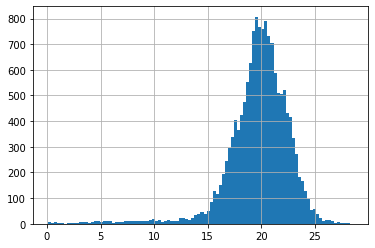

In [37]:
train_rougher_no_zero['rougher.output.concentrate_au'].hist(bins = 100)

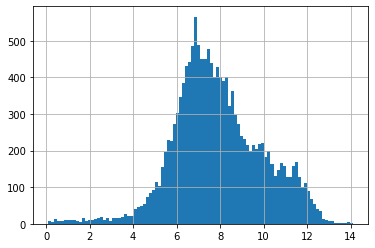

In [38]:
train_rougher_no_zero['rougher.input.feed_au'].hist(bins = 100)

Супер. Прочие "аномалии" вроде слишком длинного хвоста в направлении ноля обработаем в следующем разделе.

Теперь "обеднение" и "хвосты".

#### "Обеднение" и "хвосты"

In [39]:
train_rougher_no_poor = (train_rougher_no_zero[train_rougher_no_zero['rougher.input.feed_au'] 
                                               < train_rougher_no_zero['rougher.output.concentrate_au']]
                        )

train_rougher_no_poor.head()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
0,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.500771,7.101074,...,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636
1,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.615865,7.278807,...,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001
2,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.695753,7.216833,...,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147
3,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189,11.630094,6.203177,11.915047,7.175616,...,1600.059442,-450.619948,1600.012842,-449.910497,1597.725177,-450.130127,1400.943157,-450.030142,1400.234743,-449.790835
4,6.060915,1.786875,540.531893,56.047189,34.347666,5.663707,10.957755,6.198826,12.411054,7.240205,...,1600.208824,-449.599614,1600.357732,-450.034364,1599.759049,-449.909799,1401.560902,-448.877187,1401.160227,-450.407128


In [40]:
train_rougher_no_poor = (train_rougher_no_poor[train_rougher_no_poor['rougher.input.feed_au'] > 
                                              train_rougher_no_poor['rougher.output.tail_au']])
train_rougher_no_poor

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
0,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.500771,7.101074,...,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636
1,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.615865,7.278807,...,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001
2,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.695753,7.216833,...,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147
3,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189,11.630094,6.203177,11.915047,7.175616,...,1600.059442,-450.619948,1600.012842,-449.910497,1597.725177,-450.130127,1400.943157,-450.030142,1400.234743,-449.790835
4,6.060915,1.786875,540.531893,56.047189,34.347666,5.663707,10.957755,6.198826,12.411054,7.240205,...,1600.208824,-449.599614,1600.357732,-450.034364,1599.759049,-449.909799,1401.560902,-448.877187,1401.160227,-450.407128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,6.091855,4.617558,560.889077,85.718304,37.369774,5.335862,7.762770,9.158609,11.124896,10.984003,...,1149.807890,-498.789721,1047.963596,-498.413079,946.640977,-499.152477,849.664935,-499.214461,849.758091,-497.448664
16856,6.121323,4.144989,559.031805,119.499241,38.591551,4.838619,7.356687,9.304952,11.425983,10.888213,...,1147.675196,-500.608341,1048.565741,-500.932810,949.773589,-500.023144,848.515225,-500.289405,850.013123,-496.822119
16857,5.970515,4.020002,555.682872,122.262690,40.074026,4.525061,6.586020,9.299606,8.523497,8.955135,...,1149.942902,-501.717903,1049.604390,-500.549053,952.702732,-502.352296,849.016017,-500.505677,850.455635,-506.897968
16858,6.048130,3.902537,544.731687,123.742430,39.713906,4.362781,6.210119,9.297709,11.658799,10.655377,...,1154.087804,-500.036580,1054.009756,-500.237335,944.138793,-496.866953,851.589767,-499.040466,851.345606,-499.122561


Минуc ещё 800 объектов. Снова проверяем полученные значения с помощью точечных графиков.

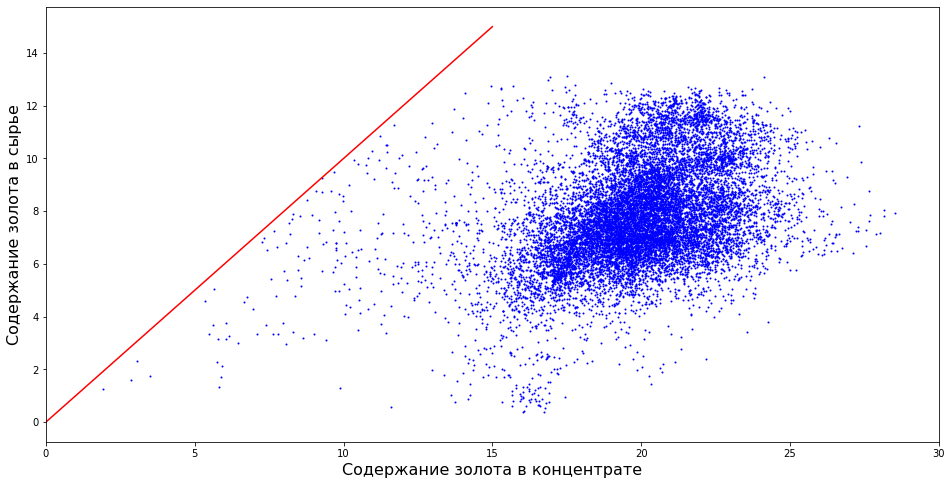

In [41]:
plt.figure(figsize = (16,8))
plt.scatter(train_rougher_no_poor['rougher.output.concentrate_au'],
            train_rougher_no_poor['rougher.input.feed_au'], color = 'blue', s = 1)
plt.xlim(0,30)
plt.xlabel('Содержание золота в концентрате', fontsize = 16)
plt.ylabel('Содержание золота в сырье', fontsize = 16)

x = np.linspace(0, 15, 100)
y = x
plt.plot(x,y, color = 'red')
plt.show()

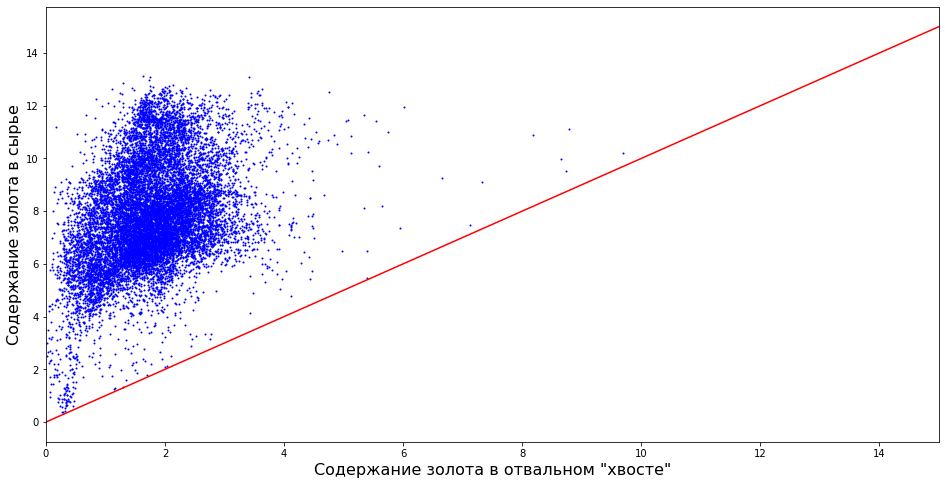

In [42]:
plt.figure(figsize = (16,8))
plt.scatter(train_rougher_no_poor['rougher.output.tail_au'],
            train_rougher_no_poor['rougher.input.feed_au'], color = 'blue', s = 1)
plt.xlim(0,15)
plt.xlabel('Содержание золота в отвальном "хвосте"', fontsize = 16)
plt.ylabel('Содержание золота в сырье', fontsize = 16)

x = np.linspace(0, 15, 100)
y = x
plt.plot(x,y, color = 'red')
plt.show()

Готово. Теперь нам необходимо разобраться с оставшимися пропусками. 

Как мы помним, вместо них у нас везде "по миллиону". Создадим отдельный датасет, где соберем ВСЕ строки, в которых есть хотя бы один миллион. Посмотрим на "масштаб проблемы" и определимся с дальнейшими действиями.

In [43]:
13958 - train_rougher_no_poor.count()

rougher.input.feed_ag                   0
rougher.input.feed_pb                 123
rougher.input.feed_rate                11
rougher.input.feed_size               148
rougher.input.feed_sol                 91
rougher.input.feed_au                   0
rougher.input.floatbank10_sulfate      30
rougher.input.floatbank10_xanthate      8
rougher.output.concentrate_ag           0
rougher.output.concentrate_pb           0
rougher.output.concentrate_sol         26
rougher.output.concentrate_au           0
rougher.output.recovery                 0
rougher.output.tail_ag                  1
rougher.output.tail_pb                  0
rougher.output.tail_sol                 0
rougher.output.tail_au                  0
rougher.state.floatbank10_a_air         1
rougher.state.floatbank10_a_level       1
rougher.state.floatbank10_b_air         1
rougher.state.floatbank10_b_level       1
rougher.state.floatbank10_c_air         1
rougher.state.floatbank10_c_level       1
rougher.state.floatbank10_d_air   

Итак, пропусков в "предобработанном" датасете практически нет, что радует. 

Но есть и некоторые исключения. Пройдемся по ним, рассматривая признаки по порядку и выбирая подходящие методы заполнения пропусков.

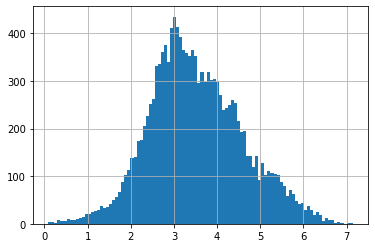

In [44]:
train_rougher_no_poor["rougher.input.feed_pb"].hist(bins = 100)

"Нормальность" распределения на лицо - при учете небольшого перекоса в праву сторону. Здесь вполне подойдет замена пропусков на медианные значения - само распределение от этого не изменится, а +123 значения в "копилку" - это существенно.

С другой стороны, в самом начале проекта есть важное указание - "Соседние по времени параметры часто похожи". От времени мы избавились, но вот индексы у нас по-прежнему на месте. Поэтому, теоретически, мы можем посмотреть на "изменение" рассматриваемого параметра во времени и, вероятно, в местах наличия "плато" (сравнительно ровного горизонтального участка графика) мы можем воспользоваться значениями "соседей" и заполнить пропуск "средним" значением. Посмотрим на график.

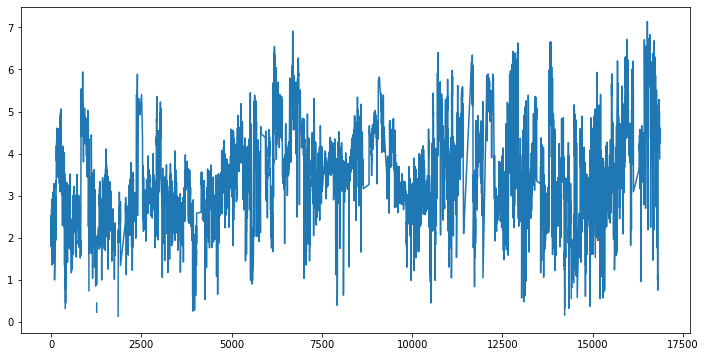

In [45]:
x = train_rougher_no_poor.index
y = train_rougher_no_poor['rougher.input.feed_pb']
plt.figure(figsize = (12,6))
plt.plot(x, y)

В ближайшем приближении можно отметить наличие участков с достаточно точно обозначенным трендом - возрастающим или убывающим. Т.е. перед нами типичный временной ряд. Следовательно, мы можем воспользоваться методом замены "соседним" значением и не получить существенного изменения распределения значений, а значит и не сильно прибавить в "ошибке". 

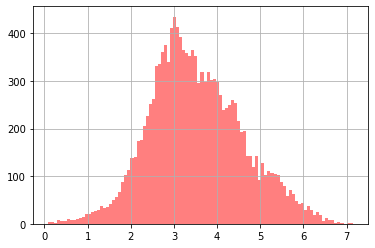

In [46]:
train_rougher_no_poor["rougher.input.feed_pb"].hist(bins = 100, alpha = 0.5, color = 'red')

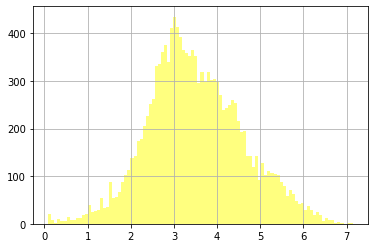

In [47]:
train_rougher_no_poor["rougher.input.feed_pb"] = train_rougher_no_poor["rougher.input.feed_pb"].fillna(method = 'ffill')
train_rougher_no_poor["rougher.input.feed_pb"].hist(bins = 100, alpha = 0.5, color = 'yellow')

Как мы видим, основные изменения после замены заключаются в появлении небольших пиков в диапазоне значений (1,2). Нас это вполне устраивает, поэтому, поскольку все остальные признаки также могут быть представлены как типичные временные ряды, мы можем провести заполнение пропусков с помощью метода "соседних" значений для всех них, не существенно потеряв в точности. Сделаем это.

In [48]:
def forward_fill(data, column):
    data[column] = data[column].fillna(method = "ffill")

In [49]:
forward_fill(train_rougher_no_poor, list(train_rougher_no_poor.columns))

train_rougher_no_poor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13958 entries, 0 to 16859
Data columns (total 29 columns):
rougher.input.feed_ag                 13958 non-null float64
rougher.input.feed_pb                 13958 non-null float64
rougher.input.feed_rate               13958 non-null float64
rougher.input.feed_size               13958 non-null float64
rougher.input.feed_sol                13958 non-null float64
rougher.input.feed_au                 13958 non-null float64
rougher.input.floatbank10_sulfate     13958 non-null float64
rougher.input.floatbank10_xanthate    13958 non-null float64
rougher.output.concentrate_ag         13958 non-null float64
rougher.output.concentrate_pb         13958 non-null float64
rougher.output.concentrate_sol        13958 non-null float64
rougher.output.concentrate_au         13958 non-null float64
rougher.output.recovery               13958 non-null float64
rougher.output.tail_ag                13958 non-null float64
rougher.output.tail_pb               

С этапом флоатации покончено. Переходим к первичной-вторичной очистке.

### 1.3.2 Первичная и вторичная очистка

In [50]:
gold_data_train_cleaner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 51 columns):
final.output.concentrate_ag                   16788 non-null float64
final.output.concentrate_pb                   16788 non-null float64
final.output.concentrate_sol                  16490 non-null float64
final.output.concentrate_au                   16789 non-null float64
final.output.recovery                         15339 non-null float64
final.output.tail_ag                          16794 non-null float64
final.output.tail_pb                          16677 non-null float64
final.output.tail_sol                         16715 non-null float64
final.output.tail_au                          16794 non-null float64
primary_cleaner.input.sulfate                 15553 non-null float64
primary_cleaner.input.depressant              15598 non-null float64
primary_cleaner.input.feed_size               16860 non-null float64
primary_cleaner.input.xanthate                15875 non-null fl

Первое, что нам необходимо сделать - это проверить "корректность" расчета коэффициента восстановления. Да, в задании этого пункта нет, однако, это необходимо для понимания того, как рассчитывается итоговый коэффициент восстановления и какие входные параметры могут быть использованы при его определении. 

Затем нам необходимо будет "обрезать" имеющийся датасет по индексам, полученным ранее для датасета этапа флоатации. Мы делаем это, в связи с тем, что процесс обогащения неразрывен - он включает в себя ЕДИНОВРЕМЕННО флоатацию и 2 этапа очистки - т.е. если у нас будут объекты, у которых "отдельно" флоатация или "отдельно" очищение, то мы не сможем определить для них искомую метрику качества - она складывается из 2 частей.

Следовательно - если у нас при обработке этапа очистки получится ещё меньше объектов, чем для этапа флоатации, мы будем вынуждены впоследствии "обрезать" и этот датасет - для сохранения полноценных "длинных" объектов. Такие дела. 

Но сперва - расчет коэффициента и определение точности расчета на основе MAE.

Искомый признак - в столбце "final.output.recovery".

Столбцы используемые при расчете:

- сырье (черновой концентрат) - вероятно, искомое значение находится в признаке "rougher.output.concentrate_au" - его нужно взять из датасета по флоатации, т.к. конечный продукт этапа флоатации используется в качестве сырья на этапе очистки. Хотя это не точно, т.к. вполне возможно, что в качестве входных значений используются значения содержания золота в концентрате после ПЕРВОГО ЭТАПА ОЧИСТКИ - признак "primary_cleaner.output.concentrate_au";
- концентрат - вероятно, это признак, обозначенный "final.output.concentrate_au";
- хвост - здесь пока не ясно, какой их "хвостов" использовать при расчете коэффициента восстановления, поскольку их у нас целых 3 и мне не до конца ясны их "отношения". По аналогии с концентратом, для расчета итогового коэффициента восстановления, воспользуемся признаком, обозначенным "final.output.tail_au".

Вопросов больше чем ответов. Расчет поможет нам понять логику определения коэффициента восстановления золота на финальном этапе.

Для проверки вынесем все интересующие нас признаки в отдельный датасет. 

In [51]:
final_gold_recovery_coef_check = pd.DataFrame()
final_gold_recovery_coef_check['feed'] = train_rougher_no_poor['rougher.output.concentrate_au']
final_gold_recovery_coef_check['concentrate'] = gold_data_train_cleaner['final.output.concentrate_au']
final_gold_recovery_coef_check['tail']= gold_data_train_cleaner['final.output.tail_au']
final_gold_recovery_coef_check['recovery'] = gold_data_train_cleaner['final.output.recovery']

final_gold_recovery_coef_check.head()

,feed,concentrate,tail,recovery
0,19.793808,42.192020,2.143149,70.541216
1,20.050975,42.701629,2.224930,69.266198
2,19.737170,42.657501,2.257889,68.116445
3,19.320810,42.689819,2.146849,68.347543
4,19.216101,42.774141,2.055292,66.927016


Теперь рассчитаем значение коэффициента восстановления.

In [52]:
final_gold_recovery_coef_check['recovery_calc'] = (final_gold_recovery_coef_check['concentrate'] * 
                                         (final_gold_recovery_coef_check['feed'] -
                                          final_gold_recovery_coef_check['tail']) * 100 / 
                                        final_gold_recovery_coef_check['feed'] / 
                                        (final_gold_recovery_coef_check['concentrate'] -
                                         final_gold_recovery_coef_check['tail']))
final_gold_recovery_coef_check.head()

,feed,concentrate,tail,recovery,recovery_calc
0,19.793808,42.192020,2.143149,70.541216,93.944554
1,20.050975,42.701629,2.224930,69.266198,93.790501
2,19.737170,42.657501,2.257889,68.116445,93.509750
3,19.320810,42.689819,2.146849,68.347543,93.595268
4,19.216101,42.774141,2.055292,66.927016,93.811976


Мимо. Поскольку "предзаданный" коэффициент восстановления ниже расчетного, очевидно, что нам следует скорректировать "сырьё". Возьмем в качестве значений сырья значения концентрации после первичной очистки. 

In [53]:
final_gold_recovery_coef_check['feed_2nd'] = gold_data_train_cleaner['primary_cleaner.output.concentrate_au']

final_gold_recovery_coef_check['recovery_calc_2nd'] = (final_gold_recovery_coef_check['concentrate'] * 
                                         (final_gold_recovery_coef_check['feed_2nd'] -
                                          final_gold_recovery_coef_check['tail']) * 100 / 
                                        final_gold_recovery_coef_check['feed_2nd'] / 
                                        (final_gold_recovery_coef_check['concentrate'] -
                                         final_gold_recovery_coef_check['tail']))
final_gold_recovery_coef_check.head()

,feed,concentrate,tail,recovery,recovery_calc,feed_2nd,recovery_calc_2nd
0,19.793808,42.192020,2.143149,70.541216,93.944554,34.174427,98.744534
1,20.050975,42.701629,2.224930,69.266198,93.790501,34.118526,98.617181
2,19.737170,42.657501,2.257889,68.116445,93.509750,33.969464,98.570585
3,19.320810,42.689819,2.146849,68.347543,93.595268,28.260743,97.296409
4,19.216101,42.774141,2.055292,66.927016,93.811976,33.044932,98.513891


Снова мимо. Вероятно, коэффициент восстановления ФИНАЛЬНЫЙ рассчитывает по ВСЕМУ процессу - воспользуемся значениями содержания золота с СЫРЬЕ - в золотосодержащей руде, а не концентрате.

Для лучшего восприятия, расположим столбцы в логически верном порядке.

In [54]:
final_gold_recovery_coef_check['feed_ore'] = train_rougher_no_poor['rougher.input.feed_au']

final_gold_recovery_coef_check['recovery_calc_ore'] = (final_gold_recovery_coef_check['concentrate'] * 
                                         (final_gold_recovery_coef_check['feed_ore'] -
                                          final_gold_recovery_coef_check['tail']) * 100 / 
                                        final_gold_recovery_coef_check['feed_ore'] / 
                                        (final_gold_recovery_coef_check['concentrate'] -
                                         final_gold_recovery_coef_check['tail']))

clmns = final_gold_recovery_coef_check.columns.tolist()
clmns

['feed',
 'concentrate',
 'tail',
 'recovery',
 'recovery_calc',
 'feed_2nd',
 'recovery_calc_2nd',
 'feed_ore',
 'recovery_calc_ore']

In [55]:
clmns = ['feed','feed_2nd','feed_ore',
         'concentrate','tail','recovery',
         'recovery_calc','recovery_calc_2nd','recovery_calc_ore']

final_gold_recovery_coef_check = final_gold_recovery_coef_check[clmns]

final_gold_recovery_coef_check.head()

,feed,feed_2nd,feed_ore,concentrate,tail,recovery,recovery_calc,recovery_calc_2nd,recovery_calc_ore
0,19.793808,34.174427,6.486150,42.192020,2.143149,70.541216,93.944554,98.744534,70.541216
1,20.050975,34.118526,6.478583,42.701629,2.224930,69.266198,93.790501,98.617181,69.266198
2,19.737170,33.969464,6.362222,42.657501,2.257889,68.116445,93.509750,98.570585,68.116445
3,19.320810,28.260743,6.118189,42.689819,2.146849,68.347543,93.595268,97.296409,68.347543
4,19.216101,33.044932,5.663707,42.774141,2.055292,66.927016,93.811976,98.513891,66.927016


Бинго!

Но в таком случае множество "промежуточных" признаков теряет всяческий смысл в процессе расчета модели, поскольку итоговый коэффициент в любом случае рассчитывается на основе значений ИЗНАЧАЛЬНОГО состояния золотосодержащей руды. В любом случае, это не имеет значения - будем работать с тем, что есть.

Отправляемся дальше - найдем MAE для полученных значений. Пропуски пока просто удаляем.

In [56]:
final_gold_recovery_coef_check = final_gold_recovery_coef_check.dropna()

mean_absolute_error(final_gold_recovery_coef_check['recovery'], final_gold_recovery_coef_check['recovery_calc_ore'])

9.814029183467597e-15

Точность расчета вновь выше всяких похвал. Теперь предобработка.

In [57]:
train_cleaner_as_rougher = pd.DataFrame(data = gold_data_train_cleaner, index = train_rougher_no_poor.index)
train_cleaner_as_rougher.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13958 entries, 0 to 16859
Data columns (total 51 columns):
final.output.concentrate_ag                   13953 non-null float64
final.output.concentrate_pb                   13953 non-null float64
final.output.concentrate_sol                  13729 non-null float64
final.output.concentrate_au                   13954 non-null float64
final.output.recovery                         13845 non-null float64
final.output.tail_ag                          13958 non-null float64
final.output.tail_pb                          13844 non-null float64
final.output.tail_sol                         13950 non-null float64
final.output.tail_au                          13958 non-null float64
primary_cleaner.input.sulfate                 13939 non-null float64
primary_cleaner.input.depressant              13924 non-null float64
primary_cleaner.input.feed_size               13958 non-null float64
primary_cleaner.input.xanthate                13859 non-null fl

На этапах очистки не наблюдается признаков группы "calculation" - удалять нечего. Даты мы удалили ранее.

Проверим на наличие нулевых значений и прочих "непотребств" целевые признаки данного этапа - непосредственно связанные с золотом:
- final.output.concentrate_au;
- final.output.tail_au;
- primary_cleaner.output.concentrate_au;
- primary_cleaner.output.tail_au;
- secondary_cleaner.output.tail_au.

"Отсутствие" заведомо недостоверных значений среди рассматриваемых признаков - важная часть успешной реализации всего проекта. Смотрим.

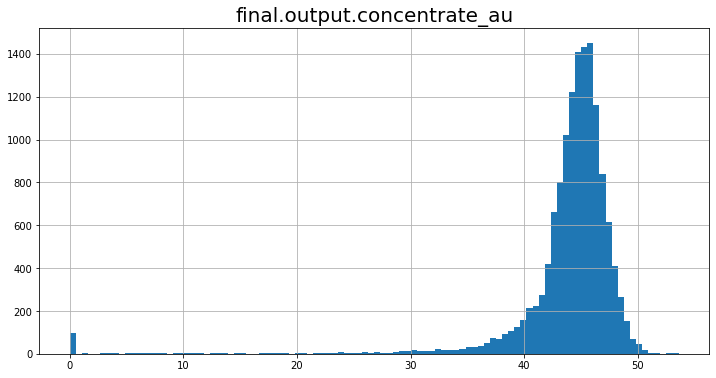

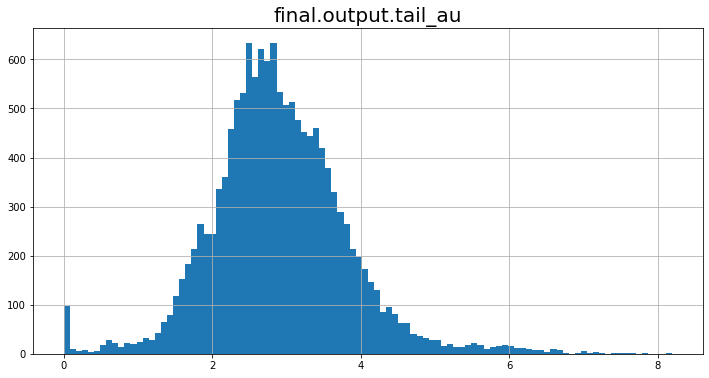

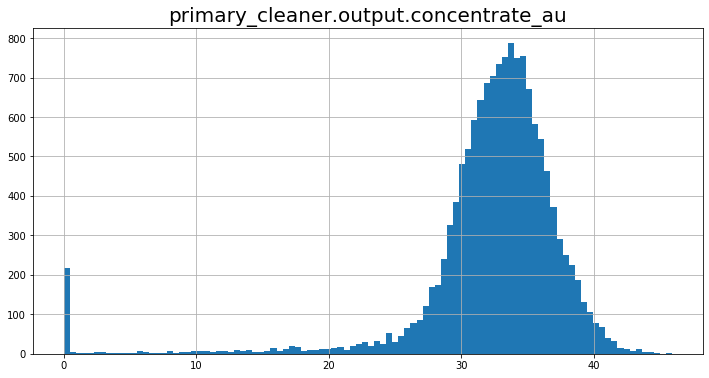

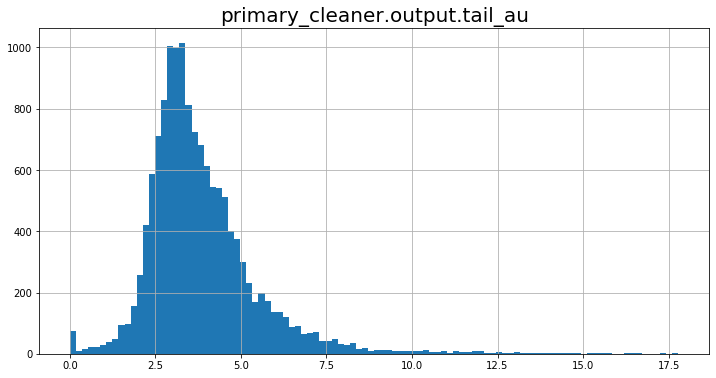

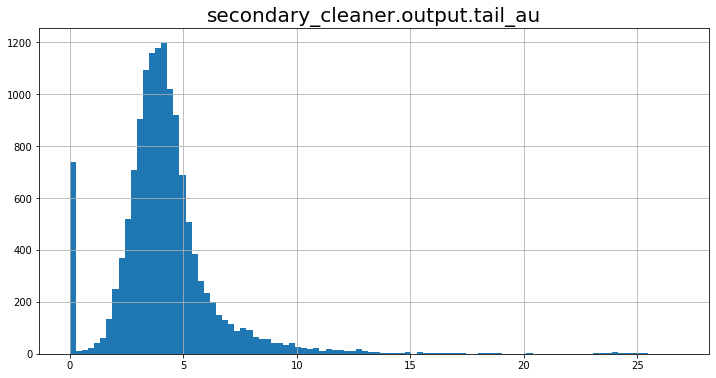

In [58]:
def hist_plotter(dataset):
    for column in list(dataset.columns):
        plt.figure(figsize = (12,6))
        dataset[column].hist(bins = 100)
        plt.title(column, fontsize = 20)
        plt.show()

au_list = ['final.output.concentrate_au',
           'final.output.tail_au',
           'primary_cleaner.output.concentrate_au',
           'primary_cleaner.output.tail_au',
           'secondary_cleaner.output.tail_au']

hist_plotter(train_cleaner_as_rougher[au_list])

Удаления наверняка заслуживают нулевые значения признака "final.output.concentrate_au", поскольку их отсутствие не позволяет нам расчитать значение искомого признака. Нулевые же значения в прочих признаках могут быть заменены по аналогии с пропусками. Посмотрим на временной ряд (кажется это называется именно так) прочих параметров после удаления нулей из столбца "final.output.concentrate_au".

In [59]:
train_cleaner_no_conc_zero = train_cleaner_as_rougher[train_cleaner_as_rougher['final.output.concentrate_au'] > 0.1]
train_cleaner_no_conc_zero

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,123.381787,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
16856,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,120.878188,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
16857,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,105.666118,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
16858,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,98.880538,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


Ещё примерно 100 значений за бортом. 

Продолжаем.

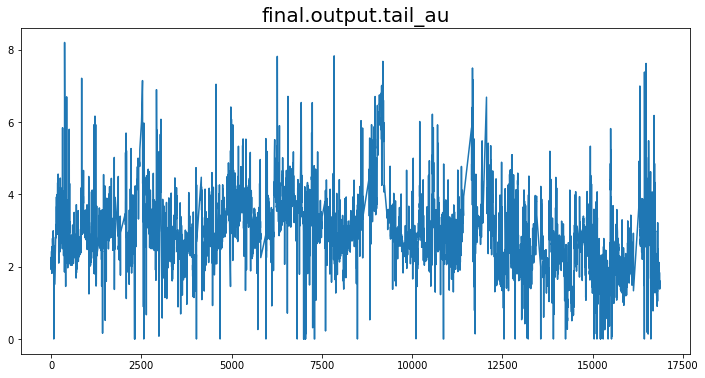

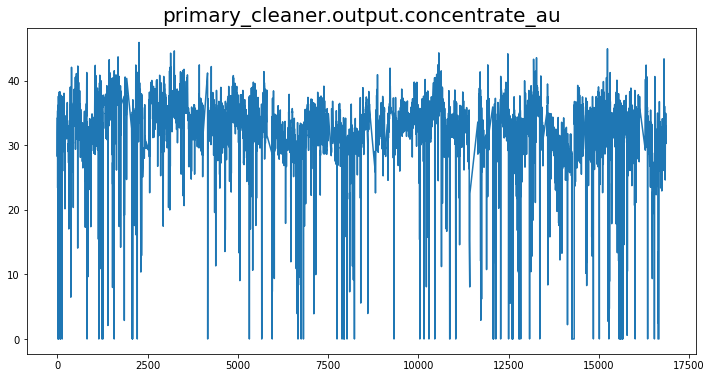

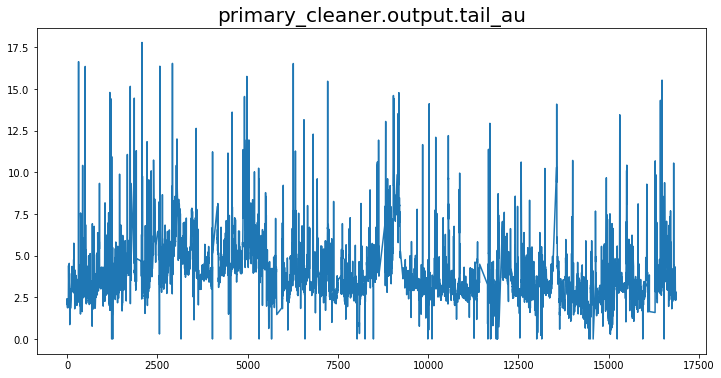

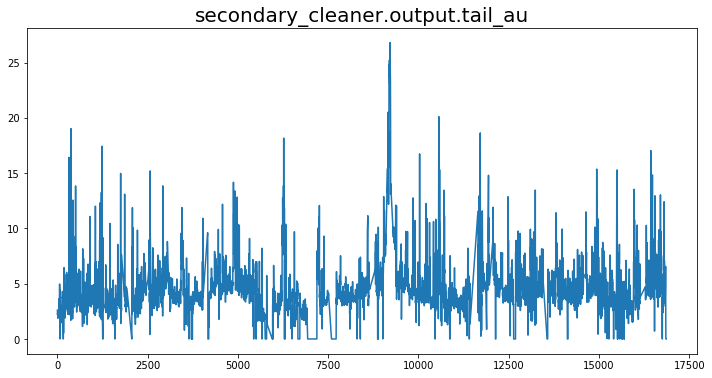

In [60]:
def feature_polyline_plotter(data):
    for column in list(data.columns):
        x = data.index
        y = data[column]
        plt.figure(figsize = (12,6))
        plt.title(column, fontsize = 20)
        plt.plot(x, y)
        plt.show()

au_plot_list = ['final.output.tail_au', 
                'primary_cleaner.output.concentrate_au', 
                'primary_cleaner.output.tail_au', 
                'secondary_cleaner.output.tail_au']
    
feature_polyline_plotter(train_cleaner_no_conc_zero[au_plot_list])


Полагаю, что для этих признаков замена нулей "соседним" значением будет достаточно адекватным решением, поскольку это позволит сохранить более 700 объектов "в деле". Сделаем это и посмотрим, как изменится характер распределения.

C:\Dev\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


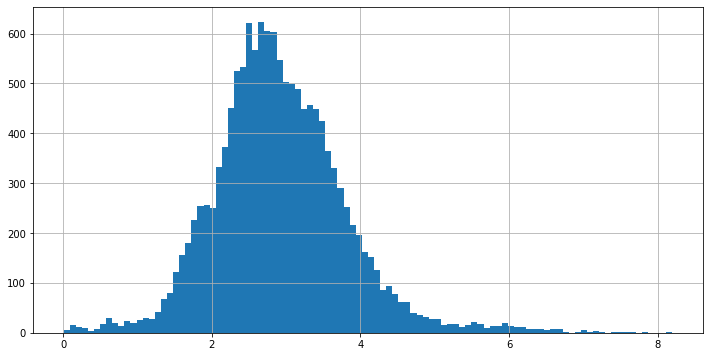

In [61]:
def forward_zero_fill(data, column):
    data[column] = data[column].replace([0,1], method = 'ffill')
    
forward_zero_fill(train_cleaner_no_conc_zero, 'final.output.tail_au')
plt.figure(figsize = (12,6))
train_cleaner_no_conc_zero['final.output.tail_au'].hist(bins = 100)


С первым признаком всё прошло прекрасно - характер распределения практически не изменился. Пробуем сделать тоже самое для остальных признаков.

C:\Dev\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


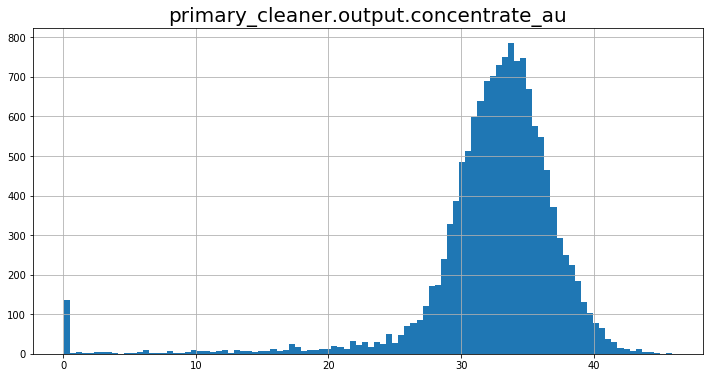

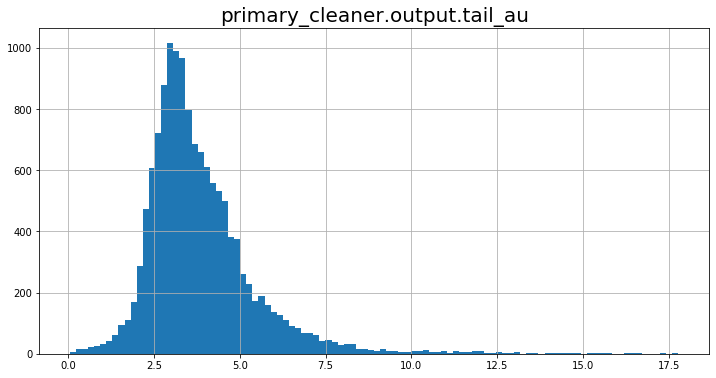

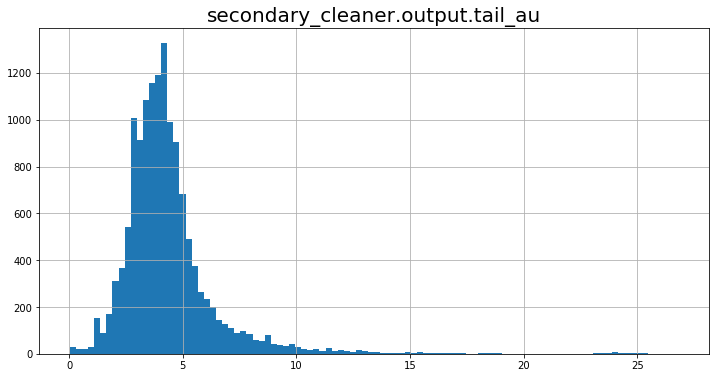

In [62]:
list_au_3 = ['primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_au', 'secondary_cleaner.output.tail_au']

forward_zero_fill(train_cleaner_no_conc_zero, list_au_3)

hist_plotter(train_cleaner_no_conc_zero[list_au_3])

Изменений в распределениях данных практически нет. При это сохранились околонулевые значения для признака 'primary_cleaner.output.concentrate_au'. Посмотрим, что такое "незаменимое осталось".

In [63]:
(train_cleaner_no_conc_zero[
    train_cleaner_no_conc_zero['primary_cleaner.output.concentrate_au'] < 1]
 ['primary_cleaner.output.concentrate_au'].head(10)
)

1265     0.663736
6753     0.737878
7938     0.936814
7939     0.936814
7940     0.936814
7946     0.439876
7947     0.439876
10157    0.056590
10158    0.056590
12498    0.010000
Name: primary_cleaner.output.concentrate_au, dtype: float64

Очень странно. Откуда здесь нули, если они должны были быть устранены посредством замены на "соседа". Вероятно, в каком-то случае не оказалось "подходящего" соседа и им стало значения < 1. В таком случае, придется "расчистить" плацдарм от этих значений привычным удалением.

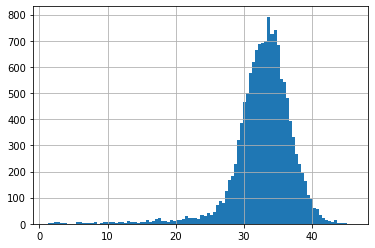

In [64]:
train_cleaner_no_zero = train_cleaner_no_conc_zero[train_cleaner_no_conc_zero['primary_cleaner.output.concentrate_au'] > 1]
train_cleaner_no_zero['primary_cleaner.output.concentrate_au'].hist(bins = 100)

In [65]:
train_cleaner_no_zero

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,123.381787,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
16856,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,120.878188,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
16857,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,105.666118,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
16858,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,98.880538,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


Не забываем про необходимость "обрезки" значений для случаев, когда вместо "обогащения" происходит "обеднение" концентрата или когда в отвал отправляется материал, с концентрацией золота БОЛЬШЕЙ, чем у исходного сырья. Этапов таких у нас 2, соответственно "корректировок" будет также 2. 

#### Первичная очистка

In [66]:
train_rougher_no_poor = pd.DataFrame(data = train_rougher_no_poor, index = train_cleaner_no_zero.index)

train_cleaner_no_poor = (train_cleaner_no_zero[train_cleaner_no_zero['primary_cleaner.output.concentrate_au'] > 
                                              train_rougher_no_poor['rougher.output.concentrate_au']])
train_cleaner_no_poor

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,123.381787,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
16856,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,120.878188,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
16857,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,105.666118,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
16858,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,98.880538,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


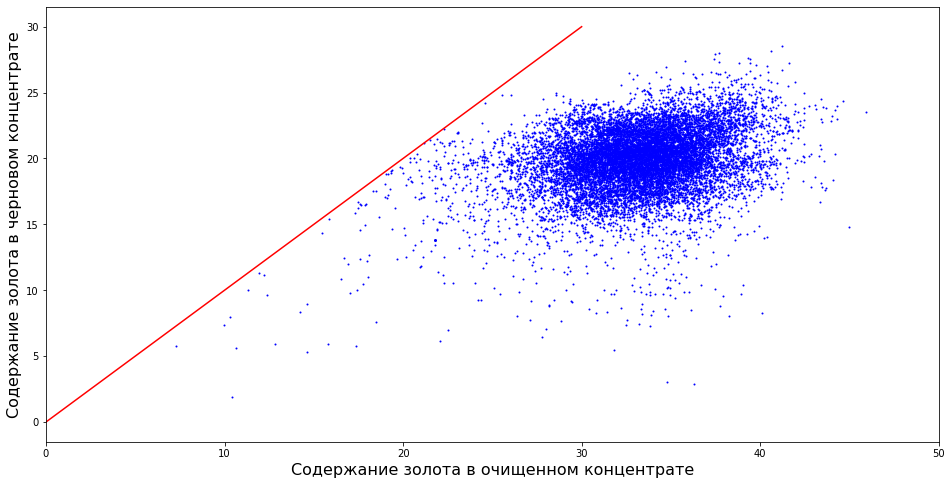

In [67]:
train_rougher_no_poor = pd.DataFrame(data = train_rougher_no_poor, index = train_cleaner_no_poor.index)

plt.figure(figsize = (16,8))
plt.scatter(train_cleaner_no_poor['primary_cleaner.output.concentrate_au'],
            train_rougher_no_poor['rougher.output.concentrate_au'],
            color = 'blue', s = 1)
plt.xlim(0,50)
plt.xlabel('Содержание золота в очищенном концентрате', fontsize = 16)
plt.ylabel('Содержание золота в черновом концентрате', fontsize = 16)

x = np.linspace(0, 30, 100)
y = x
plt.plot(x,y, color = 'red')
plt.show()

Ещё 250 значений отправляются в лучший мир.

Теперь хвосты.

In [68]:
train_cleaner_no_poor = (train_cleaner_no_poor[train_cleaner_no_poor['primary_cleaner.output.tail_au'] < 
                                              train_rougher_no_poor['rougher.output.concentrate_au']])

train_rougher_no_poor = pd.DataFrame(data = train_rougher_no_poor, index = train_cleaner_no_poor.index)

train_cleaner_no_poor

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,123.381787,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
16856,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,120.878188,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
16857,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,105.666118,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
16858,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,98.880538,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


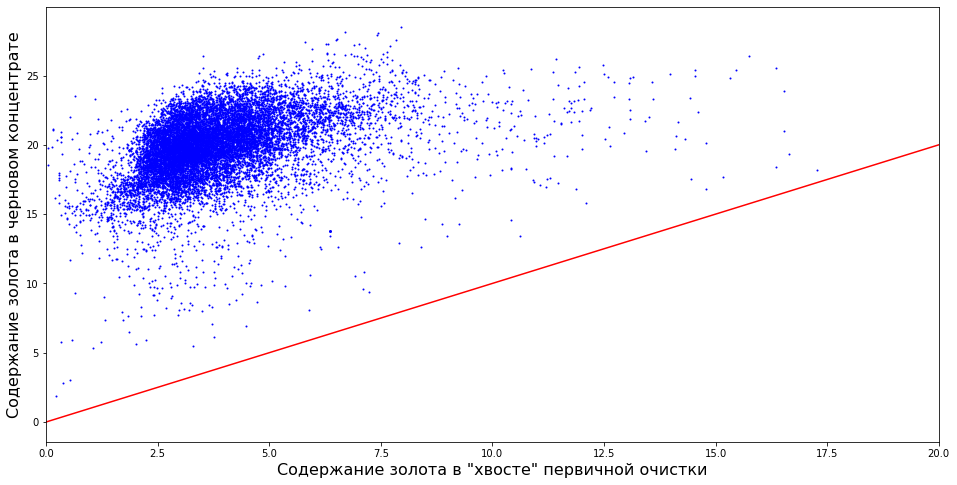

In [69]:
plt.figure(figsize = (16,8))
plt.scatter(train_cleaner_no_poor['primary_cleaner.output.tail_au'],
            train_rougher_no_poor['rougher.output.concentrate_au'],
            color = 'blue', s = 1)
plt.xlim(0,20)
plt.xlabel('Содержание золота в "хвосте" первичной очистки', fontsize = 16)
plt.ylabel('Содержание золота в черновом концентрате', fontsize = 16)

x = np.linspace(0, 20, 100)
y = x
plt.plot(x,y, color = 'red')
plt.show()

#### Вторичная очистка

In [70]:
train_cleaner_no_poor_2nd = (train_cleaner_no_poor[train_cleaner_no_poor['final.output.concentrate_au'] > 
                                                   train_cleaner_no_poor['primary_cleaner.output.concentrate_au']])

train_cleaner_no_poor_2nd

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,123.381787,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
16856,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,120.878188,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
16857,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,105.666118,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
16858,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,98.880538,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


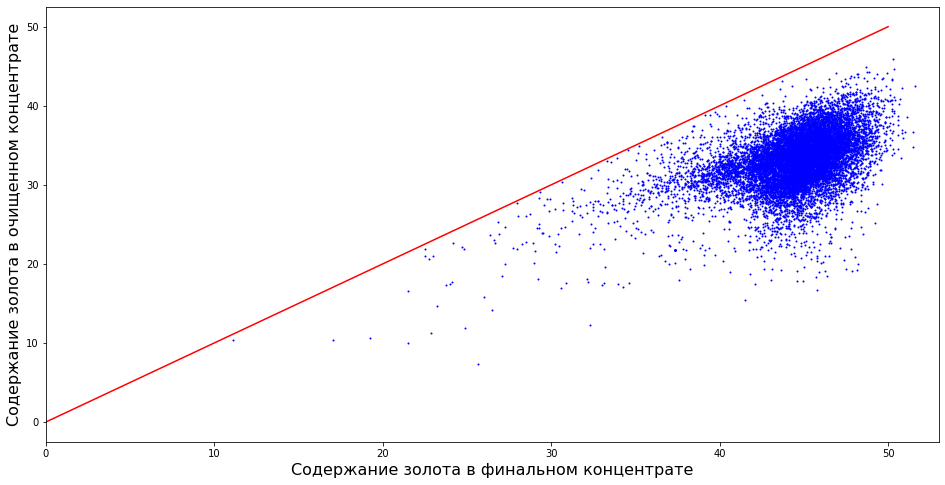

In [71]:
plt.figure(figsize = (16,8))
plt.scatter(train_cleaner_no_poor_2nd['final.output.concentrate_au'],
            train_cleaner_no_poor_2nd['primary_cleaner.output.concentrate_au'],
            color = 'blue', s = 1)
plt.xlim(0,53)
plt.xlabel('Содержание золота в финальном концентрате', fontsize = 16)
plt.ylabel('Содержание золота в очищенном концентрате', fontsize = 16)

x = np.linspace(0, 50, 100)
y = x
plt.plot(x,y, color = 'red')
plt.show()

In [72]:
train_cleaner_no_poor_2nd = (train_cleaner_no_poor_2nd[train_cleaner_no_poor_2nd['secondary_cleaner.output.tail_au'] < 
                                                       train_cleaner_no_poor_2nd['primary_cleaner.output.concentrate_au']])

train_cleaner_no_poor_2nd

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,123.381787,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
16856,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,120.878188,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
16857,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,105.666118,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
16858,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,98.880538,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


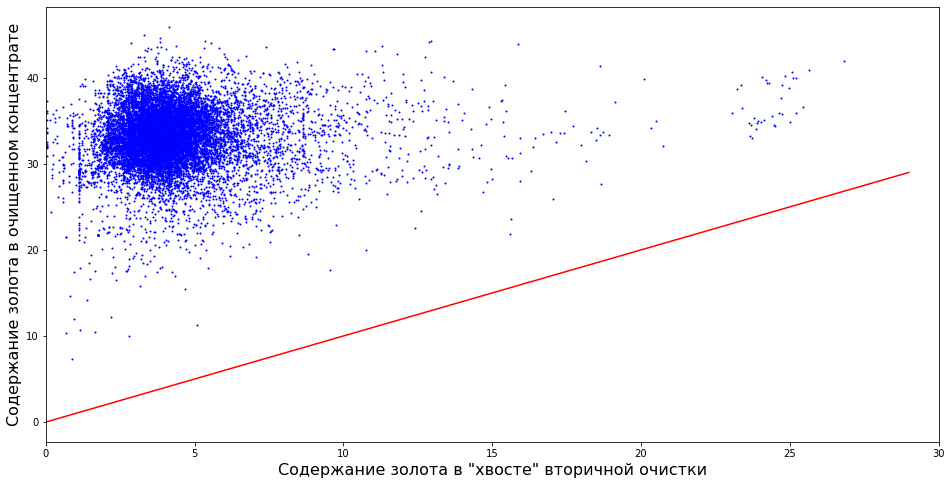

In [73]:
plt.figure(figsize = (16,8))
plt.scatter(train_cleaner_no_poor_2nd['secondary_cleaner.output.tail_au'],
            train_cleaner_no_poor_2nd['primary_cleaner.output.concentrate_au'],
            color = 'blue', s = 1)
plt.xlim(0,30)
plt.xlabel('Содержание золота в "хвосте" вторичной очистки', fontsize = 16)
plt.ylabel('Содержание золота в очищенном концентрате', fontsize = 16)

x = np.linspace(0, 29, 100)
y = x
plt.plot(x,y, color = 'red')
plt.show()

Готово. 

13292 объекта. Заполним пропуски путем вставки "соседей" - как мы помним, в нашем случае это вполне приемлемый метод и "обрежем" по новым границам датасет этапа флоатации.

In [74]:
forward_fill(train_cleaner_no_poor_2nd, train_cleaner_no_poor_2nd.columns)
train_cleaner_no_poor_2nd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13292 entries, 0 to 16859
Data columns (total 51 columns):
final.output.concentrate_ag                   13292 non-null float64
final.output.concentrate_pb                   13292 non-null float64
final.output.concentrate_sol                  13292 non-null float64
final.output.concentrate_au                   13292 non-null float64
final.output.recovery                         13292 non-null float64
final.output.tail_ag                          13292 non-null float64
final.output.tail_pb                          13292 non-null float64
final.output.tail_sol                         13292 non-null float64
final.output.tail_au                          13292 non-null float64
primary_cleaner.input.sulfate                 13292 non-null float64
primary_cleaner.input.depressant              13292 non-null float64
primary_cleaner.input.feed_size               13292 non-null float64
primary_cleaner.input.xanthate                13292 non-null fl

In [75]:
train_rougher_fill = pd.DataFrame(data = train_rougher_no_poor, index = train_cleaner_no_poor_2nd.index)
train_rougher_fill

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
0,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.500771,7.101074,...,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636
1,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.615865,7.278807,...,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001
2,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.695753,7.216833,...,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147
3,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189,11.630094,6.203177,11.915047,7.175616,...,1600.059442,-450.619948,1600.012842,-449.910497,1597.725177,-450.130127,1400.943157,-450.030142,1400.234743,-449.790835
4,6.060915,1.786875,540.531893,56.047189,34.347666,5.663707,10.957755,6.198826,12.411054,7.240205,...,1600.208824,-449.599614,1600.357732,-450.034364,1599.759049,-449.909799,1401.560902,-448.877187,1401.160227,-450.407128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,6.091855,4.617558,560.889077,85.718304,37.369774,5.335862,7.762770,9.158609,11.124896,10.984003,...,1149.807890,-498.789721,1047.963596,-498.413079,946.640977,-499.152477,849.664935,-499.214461,849.758091,-497.448664
16856,6.121323,4.144989,559.031805,119.499241,38.591551,4.838619,7.356687,9.304952,11.425983,10.888213,...,1147.675196,-500.608341,1048.565741,-500.932810,949.773589,-500.023144,848.515225,-500.289405,850.013123,-496.822119
16857,5.970515,4.020002,555.682872,122.262690,40.074026,4.525061,6.586020,9.299606,8.523497,8.955135,...,1149.942902,-501.717903,1049.604390,-500.549053,952.702732,-502.352296,849.016017,-500.505677,850.455635,-506.897968
16858,6.048130,3.902537,544.731687,123.742430,39.713906,4.362781,6.210119,9.297709,11.658799,10.655377,...,1154.087804,-500.036580,1054.009756,-500.237335,944.138793,-496.866953,851.589767,-499.040466,851.345606,-499.122561


In [76]:
train_cleaner_fill = pd.DataFrame(data = train_cleaner_no_poor_2nd, index = train_rougher_fill.index)
train_cleaner_fill

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,123.381787,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
16856,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,120.878188,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
16857,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,105.666118,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
16858,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,98.880538,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


Этап предобработки завершен.

# 2. Анализ данных

## 2.1 Изменение концентрации металлов в процессе очистки

### 2.1.1 Золото (Au)

Предобработка данных - сложный, нудный и ленивый этап. Не то, что анализ данных!

Первое, что нам необходимо - построить (мысленно) - процесс очистки металлов и параметры, которые нам необходимы для анализа.

1. Сырье - тут всё понятно - концентрация золота в руде
2. Грубый концентрат - После обогащения на этапе флоатации
3. Концентрат первичной очистки - очевидно (!) после первичной очистки
4. Итоговый концентрат.

Перенося эту последовательность на признаки, получаем:

1. rougher.input.feed_au
2. rougher.output.concentrate_au
3. primary_cleaner.output.concentrate_au
4. final.output.concentrate_au

In [77]:
au_conc_analysis = pd.DataFrame(data = [])
au_conc_analysis['feed'] = train_rougher_fill['rougher.input.feed_au']
au_conc_analysis['rough_conc'] = train_rougher_fill['rougher.output.concentrate_au']
au_conc_analysis['prim_clean_conc'] = train_cleaner_fill['primary_cleaner.output.concentrate_au']
au_conc_analysis['final_conc'] = train_cleaner_fill['final.output.concentrate_au']

au_conc_analysis.head()

,feed,rough_conc,prim_clean_conc,final_conc
0,6.486150,19.793808,34.174427,42.192020
1,6.478583,20.050975,34.118526,42.701629
2,6.362222,19.737170,33.969464,42.657501
3,6.118189,19.320810,28.260743,42.689819
4,5.663707,19.216101,33.044932,42.774141


На мой взгляд, наиболее информативным в нашем случае является график плотностей - он поможет увидеть процесс "движения" концентрации от начала до конца всего производственного цикла.

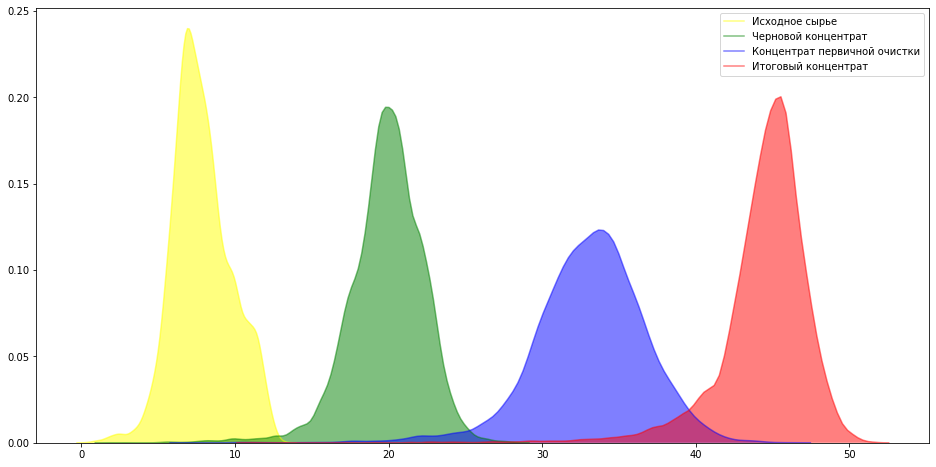

In [78]:
plt.figure(figsize = (16,8))
sns.kdeplot(au_conc_analysis['feed'], shade=True, color="yellow", label="Исходное сырье", alpha=0.5)
sns.kdeplot(au_conc_analysis['rough_conc'], shade=True, color="green", label="Черновой концентрат", alpha=0.5)
sns.kdeplot(au_conc_analysis['prim_clean_conc'], shade=True, color="blue", label="Концентрат первичной очистки", alpha=0.5)
sns.kdeplot(au_conc_analysis['final_conc'], shade=True, color="red", label="Итоговый концентрат", alpha=0.5)

Очевидно, что чем "выше" вздымается кривая распределения, тем ближе друг к другу будут расположены границы 25 и 75 квартиля. Следовательно, в нашем случае, из полученных распределений можно предположить большую ВОСПРОИЗВОДИМОСТЬ и стабильность процесса, т.к. с чем большей вероятностью мы можем получить ОДИН И ТОТ ЖЕ результат (в данном случае, вещество с определенным содержанием золота), тем "целесообразней" данный процесс к осуществлению. Безусловно, если нас устраивают его среднее и медианное значения. 

В дополнение к графикам плотности добавим "ящиков с усами" - для лучшего понимания распределения значений.

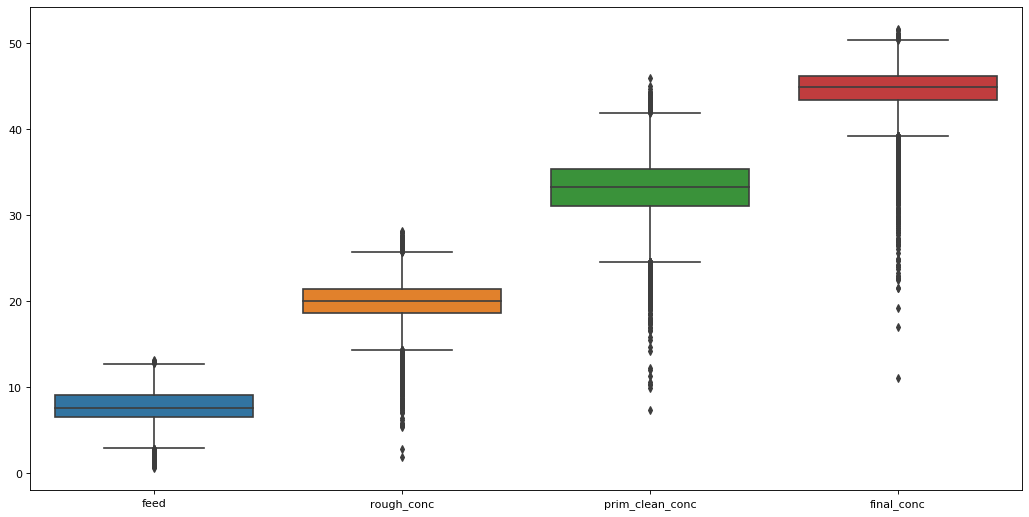

In [79]:
plt.figure(figsize=(16,8), dpi= 80)
sns.boxplot(data=au_conc_analysis, notch=False)

Как я и говорил - даже визуально хорошо видно, что ширина межквартильного размаха для сырья существенно меньше, чем для концентрата первичной обработки. 

Соберем статистические показатели (медиана, среднее, стандартное отклонение, 1 и 99 квартили) рассматриваемых признаков в таблицу и посмотрим на них ещё раз.

In [80]:
au_stats = pd.DataFrame(data = [], columns = au_conc_analysis.columns, index = ['mean', 'median', 'std', 'Q1%', 'Q99%'])

def stats_fill(data, filled_table):
    for column in list(data.columns):
        filled_table.loc['mean', column] = data[column].mean()
        filled_table.loc['median', column] = data[column].median()
        filled_table.loc['std', column] = data[column].std()
        filled_table.loc['Q1%', column] = data[column].quantile(0.01)
        filled_table.loc['Q99%', column] = data[column].quantile(0.99)
    return filled_table

au_stats = stats_fill(au_conc_analysis, au_stats)
au_stats

,feed,rough_conc,prim_clean_conc,final_conc
mean,7.86089,19.8873,33.1166,44.4612
median,7.63893,20.0202,33.3011,44.9015
std,1.88935,2.39727,3.55503,2.88334
Q1%,3.48199,12.5021,22.3175,34.1327
Q99%,12.1078,24.8608,40.7349,49.3038


Выдвинутое ранее предположение подтверждается значениями стандартного отклонения и размахом между 1 и 99 квартилем. 

Переходим к анализу аналогичных показателей у серебра и свинца.

### 2.1.2 Серебро (Ag)

In [81]:
ag_conc_analysis = pd.DataFrame(data = [])
ag_conc_analysis['feed'] = train_rougher_fill['rougher.input.feed_ag']
ag_conc_analysis['rough_conc'] = train_rougher_fill['rougher.output.concentrate_ag']
ag_conc_analysis['prim_clean_conc'] = train_cleaner_fill['primary_cleaner.output.concentrate_ag']
ag_conc_analysis['final_conc'] = train_cleaner_fill['final.output.concentrate_ag']

ag_conc_analysis.head()

,feed,rough_conc,prim_clean_conc,final_conc
0,6.100378,11.500771,8.547551,6.055403
1,6.161113,11.615865,8.558743,6.029369
2,6.116455,11.695753,8.603505,6.055926
3,6.043309,11.915047,7.221879,6.047977
4,6.060915,12.411054,9.089428,6.148599


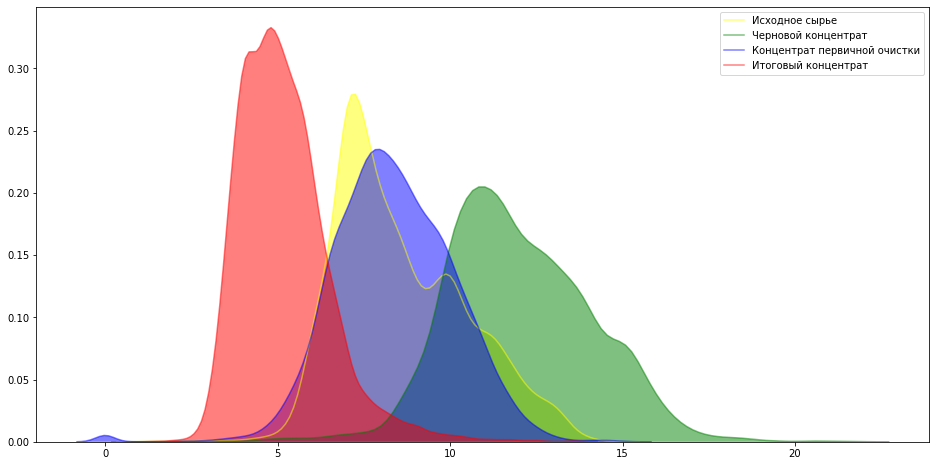

In [82]:
plt.figure(figsize = (16,8))
sns.kdeplot(ag_conc_analysis['feed'], shade=True, color="yellow", label="Исходное сырье", alpha=0.5)
sns.kdeplot(ag_conc_analysis['rough_conc'], shade=True, color="green", label="Черновой концентрат", alpha=0.5)
sns.kdeplot(ag_conc_analysis['prim_clean_conc'], shade=True, color="blue", label="Концентрат первичной очистки", alpha=0.5)
sns.kdeplot(ag_conc_analysis['final_conc'], shade=True, color="red", label="Итоговый концентрат", alpha=0.5)

Процесс изменения содержания серебра в смеси существенно отличается от изменения содержания золота. Если в первом случае мы наблюдали непрерывный рост (что логично - золотообогатительный комплекс, как бы), то в случае серебра ситуация немного иная. 

Размышляя на логикой процессов, происходящих на различных этапах, можно предположить следующее:
1. На этапе флоатации происходит очистка исходной руды от МАКСИМАЛЬНО ИНОРОДНЫХ примесей - серебро, относимое как и золото к благородным и драгоценным металлам, оказывается в этой ситуации "своим" и практически не удаляется из состава - есть много чего ещё, что необходимо "удалить". Как следствие - рост содержания серебра примерно с 7 до 12%;
2. На этапах очистки, когда удалять уже особо нечего, ситуация коренным образом меняется. Если раньше серебро - "наш друг", то сейчас, мы его "предаем" и всячески пытаемся исключить из состава нашей смеси - как следствие, наблюдается постепенное падение содержания серебра с 12 сначала до 8, а потом и до 5% в составе финального материала.

При этом важно отметить, что здесь, напротив, наибольшую воспроизводимость с точки зрения содержания серебра имеет финальный материал - для него "пик" кривой распределения наивысший - доля среднего и медианного значений существенно выше, чем остальных.

"Ящик с усами" здесь строить нет особого смысла, поэтому просто соберем в таблицу интересующие нас статистические значения.

In [83]:
ag_stats = pd.DataFrame(data = [], columns = ag_conc_analysis.columns, index = ['mean', 'median', 'std', 'Q1%', 'Q99%'])

ag_stats = stats_fill(ag_conc_analysis, ag_stats)
ag_stats

,feed,rough_conc,prim_clean_conc,final_conc
mean,8.57169,12.023,8.37497,5.17427
median,8.15482,11.7945,8.29933,5.00216
std,1.87339,2.08383,1.72162,1.29849
Q1%,5.43001,7.0864,4.59305,3.07038
Q99%,13.1816,16.9366,12.2779,9.43926


### 2.1.3 Свинец (Pb)

In [84]:
pb_conc_analysis = pd.DataFrame(data = [])
pb_conc_analysis['feed'] = train_rougher_fill['rougher.input.feed_pb']
pb_conc_analysis['rough_conc'] = train_rougher_fill['rougher.output.concentrate_pb']
pb_conc_analysis['prim_clean_conc'] = train_cleaner_fill['primary_cleaner.output.concentrate_pb']
pb_conc_analysis['final_conc'] = train_cleaner_fill['final.output.concentrate_pb']

pb_conc_analysis.head()

,feed,rough_conc,prim_clean_conc,final_conc
0,2.284912,7.101074,10.389648,9.889648
1,2.266033,7.278807,10.497069,9.968944
2,2.159622,7.216833,10.354494,10.213995
3,2.037807,7.175616,8.496563,9.977019
4,1.786875,7.240205,9.986786,10.142511


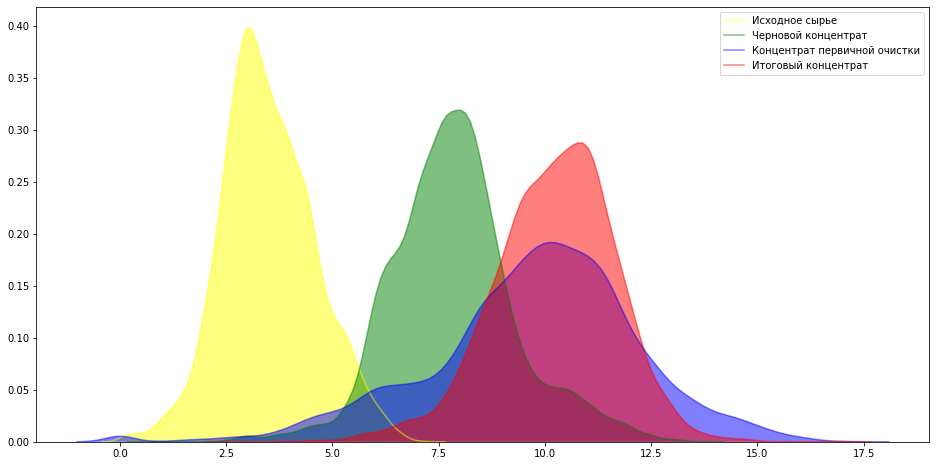

In [85]:
plt.figure(figsize = (16,8))
sns.kdeplot(pb_conc_analysis['feed'], shade=True, color="yellow", label="Исходное сырье", alpha=0.5)
sns.kdeplot(pb_conc_analysis['rough_conc'], shade=True, color="green", label="Черновой концентрат", alpha=0.5)
sns.kdeplot(pb_conc_analysis['prim_clean_conc'], shade=True, color="blue", label="Концентрат первичной очистки", alpha=0.5)
sns.kdeplot(pb_conc_analysis['final_conc'], shade=True, color="red", label="Итоговый концентрат", alpha=0.5)

По аналогии с золотом и серебром, содержание свинца растет на этапе флоатации и получения чернового концентрата. Первичная очистка также приводит к небольшому приросту содержания свинца. Однако, при этом наблюдается наблюдается существенное снижение воспроизводимости на этом этапе - почти в 2 раза (с точки зрения пиковой плотности распределения значений). Вторичная очистка не сопровождается существенным изменением среднего и медианного значений, однако, воспроизводимость значений на этом этапе существенно растет, что подтверждается уменьшением значения стандартного отклонения.

Соберем таблицу по свинцу и посмотрим на полученные результаты с ещё одного ракурса.

In [86]:
pb_stats = pd.DataFrame(data = [], columns = pb_conc_analysis.columns, index = ['mean', 'median', 'std', 'Q1%', 'Q99%'])

pb_stats = stats_fill(pb_conc_analysis, pb_stats)
pb_stats

,feed,rough_conc,prim_clean_conc,final_conc
mean,3.49978,7.84593,9.7482,10.2379
median,3.40573,7.79529,9.97091,10.3328
std,1.08432,1.46745,2.45313,1.42059
Q1%,1.01891,4.21604,2.96112,6.38152
Q99%,6.13122,11.8481,15.0381,13.2824


На основании полученных данных мы с достаточной степенью точности можем говорить о характере протекающих процессов и том, какой из этапов необходимо "добалансировать". Объединим полученные значения (просуммируем) и посмотрим, как меняется содержание и распределение значений ценных металлов (целиком) на протяжении всего технологического процесса.

In [87]:
prec_met_stats = pd.DataFrame(data = [], columns = au_conc_analysis.columns, index = ['au', 'ag', 'pb'])
prec_met_stats.loc['au',:] = au_stats.loc['mean',:]
prec_met_stats.loc['ag',:] = ag_stats.loc['mean',:]
prec_met_stats.loc['pb',:] = pb_stats.loc['mean',:]
prec_met_stats

,feed,rough_conc,prim_clean_conc,final_conc
au,7.86089,19.8873,33.1166,44.4612
ag,8.57169,12.023,8.37497,5.17427
pb,3.49978,7.84593,9.7482,10.2379


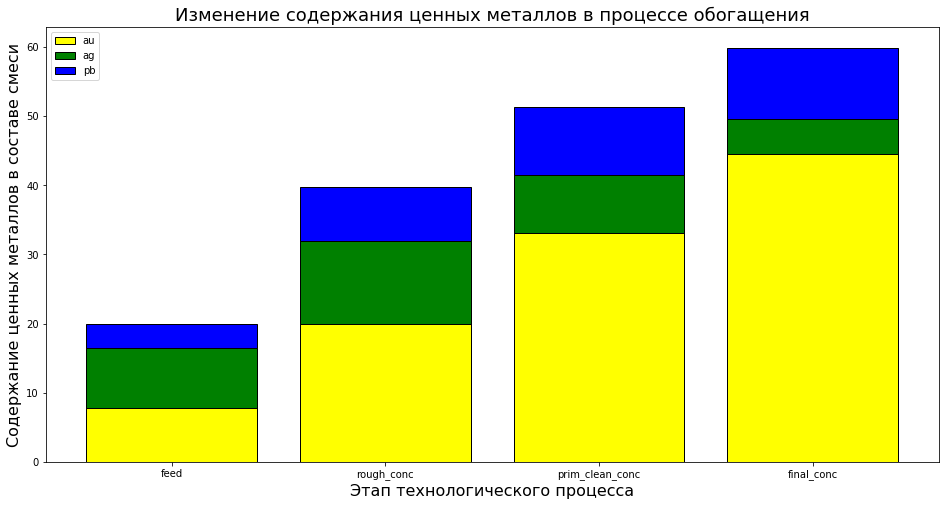

In [88]:
plt.figure(figsize = (16,8))

plt.bar(list(prec_met_stats.columns), prec_met_stats.loc['au',:],color='yellow',edgecolor='black')
plt.bar(list(prec_met_stats.columns), prec_met_stats.loc['ag',:],color='green',
        edgecolor='black', bottom = prec_met_stats.loc['au',:])
plt.bar(list(prec_met_stats.columns), prec_met_stats.loc['pb',:],color='blue',
        edgecolor='black', bottom = (prec_met_stats.loc['au',:] + prec_met_stats.loc['ag',:]))

plt.xlabel('Этап технологического процесса', fontsize=16)
plt.ylabel('Содержание ценных металлов в составе смеси', fontsize=16)
plt.title('Изменение содержания ценных металлов в процессе обогащения',fontsize=18)
plt.legend(prec_met_stats.index,loc=2)


Таким образом, обобщая полученные данные, можно утверждать, что в процессе обогащения золотосодержащей руды наблюдается постепенный рост доли ценных металлов с 20 до 60%, причем содержание золота увеличивается в среднем в 5.5 раз - с 8% до 45%. 

При этом, наиболее "нестабильным" с точки зрения имеющихся данных, представляется смесь, полученная по результатам первичной очистки. Как следствие, повышение стабильности смеси на данном этапе может позволить повысить качество конечного продукта и среднюю (выручку?) предприятия. 

## 2.2 Распределение размеров гранул

Сравните распределения размеров гранул сырья на обучающей и тестовой выборках.

Искомые значения содержатся в столбце "rougher.input.feed_size". Благо, он имеется и в обучающей и в тестовой выборке (было бы странно, если бы его не было :) ).

In [89]:
train_gran_size = pd.DataFrame(data = train_rougher_fill['rougher.input.feed_size'])
train_gran_size.columns = ['train']
test_gran_size = pd.DataFrame(data = gold_data_test['rougher.input.feed_size']).dropna()
test_gran_size.columns = ['test']
test_gran_size.head()

,test
0,62.710452
1,61.961163
2,66.903807
3,59.865919
4,63.315324


(0, 150)

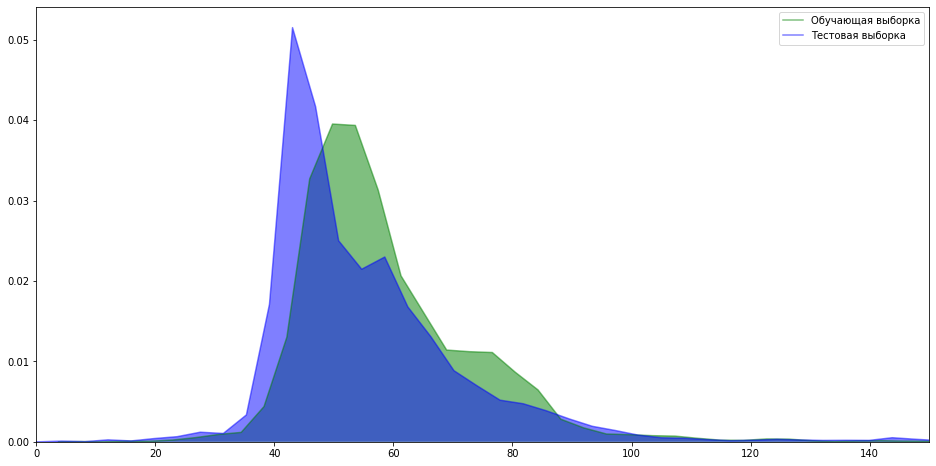

In [90]:
plt.figure(figsize = (16,8))
sns.kdeplot(train_gran_size['train'], shade=True, color="green", label="Обучающая выборка", alpha=0.5)
sns.kdeplot(test_gran_size['test'], shade=True, color="blue", label="Тестовая выборка", alpha=0.5)

# обрежем хвост, простирающийся до 500 координаты, для наглядности
plt.xlim(0,150)

Хвосты полученных распределений, простирающиеся аж до 500 координаты по оси X я обрезал для большей наглядности.

Визуальный анализ данных - "на глазок" - прекраснейший метод на планете Земля. Но здесь нам потребуется сформулировать гипотезу и статистически её проверить. Отдадим решение важных вопросов статистической машине!

Итак, нулевая гипотеза в нашем случае будет звучать следующим образом:

> H0 - Средние значения генеральных совокупностей размеров гранул тестовой и обучающей выборок равны.

Тогда альтернативная гипотеза звучит следующим образом:

> H1 - Средние значения генеральных совокупностей размеров гранул тестовой и обучающей выборок НЕ равны.

In [91]:
results = st.ttest_ind(test_gran_size['test'], train_gran_size['train'])
results.pvalue

5.916882308134261e-32

К сожалению (или к счастью?), нулевая гипотеза опровергнута - средние значения полученных выборок различаются НЕ СЛУЧАЙНО. Вероятность этого практически отсутствует - 10 в (минус)32 степени - это практически отсутствует. 

Следовательно, мы не можем так сходу использовать имеющиеся данные для разработки и обучения моделей. Что нам делать? 

Если честно - точного ответа я не знаю. Есть только версии - ими и займемся.

Первое - устранить из обеих выборок аномальные значения, подрезать хвосты по 1 и 99 квартилям и попробовать ещё раз.
Дальше - будем думать.

Для начала соберем статистические показатели имещихся датасетов в таблицу.

In [92]:
test_train_stats = pd.DataFrame(data = [], columns = ['test', 'train'], index = ['mean', 'median', 'std', 'Q1%', 'Q99%'])

test_train_stats = stats_fill(test_gran_size,test_train_stats)
test_train_stats = stats_fill(train_gran_size,test_train_stats)

test_train_stats

,test,train
mean,55.9375,60.1818
median,50.002,55.2668
std,22.7243,23.0186
Q1%,28.7235,35.8986
Q99%,130.017,127.701


С точки зрения статистических показателей, обучающая выборка в среднем содержит большие по размеру гранулы. Удалим аномальные значения и посмотрим, как изменятся стат. показатели после этого.

In [93]:
q1_test = test_gran_size['test'].quantile(0.01)
q99_test = test_gran_size['test'].quantile(0.99)

test_gran_size_clean = test_gran_size[test_gran_size['test'] > q1_test]
test_gran_size_clean = test_gran_size_clean[test_gran_size_clean['test'] < q99_test]
test_gran_size_clean.head()

,test
0,62.710452
1,61.961163
2,66.903807
3,59.865919
4,63.315324


In [94]:
q1_train = train_gran_size['train'].quantile(0.01)
q99_train = train_gran_size['train'].quantile(0.99)

train_gran_size_clean = train_gran_size[train_gran_size['train'] > q1_train]
train_gran_size_clean = train_gran_size_clean[train_gran_size_clean['train'] < q99_train]
train_gran_size_clean.head()

,train
0,55.486599
1,57.278666
2,57.510649
3,57.792734
4,56.047189


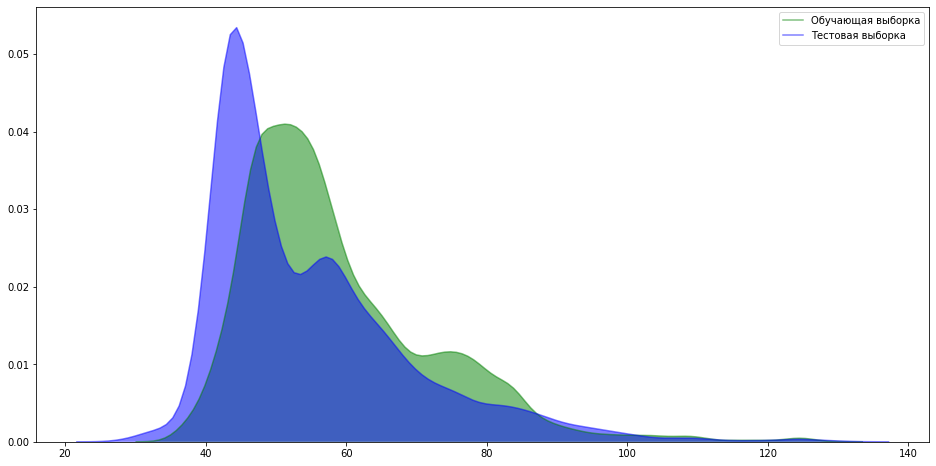

In [95]:
plt.figure(figsize = (16,8))
sns.kdeplot(train_gran_size_clean['train'], shade=True, color="green", label="Обучающая выборка", alpha=0.5)
sns.kdeplot(test_gran_size_clean['test'], shade=True, color="blue", label="Тестовая выборка", alpha=0.5)


In [96]:
results = st.ttest_ind(test_gran_size_clean['test'], train_gran_size_clean['train'])
results.pvalue

3.350600471477727e-76

In [97]:
test_train_stats_clean = pd.DataFrame(data = [], columns = ['test', 'train'], index = ['mean', 'median', 'std', 'Q1%', 'Q99%'])

test_train_stats_clean = stats_fill(test_gran_size_clean,test_train_stats_clean)
test_train_stats_clean = stats_fill(train_gran_size_clean,test_train_stats_clean)

test_train_stats_clean

,test,train
mean,54.7848,58.8044
median,50.002,55.2668
std,14.1397,13.4315
Q1%,36.4859,39.208
Q99%,99.9054,103.302


Как пел в одной из песен Нойз МС - "Ничего нового!", так и у нас - ничего нового. Средние выборок НЕ равны и это НЕ случайно. Тем не менее, границы 1 и 99 квартилей находятся крайне близко друг к другу, поэтому СХОДУ утверждать, что результаты на тестовой выборке будут хуже (так часто бывает), чем на обучающей - не будем. Проверим это в "боевых условиях".

А пока продолжим анализ данных, не забыва "обрезать" датасеты по полученным индексам.

In [98]:
train_cleaner_clean_size = pd.DataFrame(data = train_cleaner_fill, index = train_gran_size_clean.index)
train_cleaner_clean_size

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,123.381787,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
16856,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,120.878188,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
16857,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,105.666118,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
16858,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,98.880538,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


In [99]:
train_rougher_clean_size = pd.DataFrame(data = train_rougher_fill, index = train_gran_size_clean.index)
train_rougher_clean_size

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
0,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.500771,7.101074,...,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636
1,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.615865,7.278807,...,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001
2,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.695753,7.216833,...,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147
3,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189,11.630094,6.203177,11.915047,7.175616,...,1600.059442,-450.619948,1600.012842,-449.910497,1597.725177,-450.130127,1400.943157,-450.030142,1400.234743,-449.790835
4,6.060915,1.786875,540.531893,56.047189,34.347666,5.663707,10.957755,6.198826,12.411054,7.240205,...,1600.208824,-449.599614,1600.357732,-450.034364,1599.759049,-449.909799,1401.560902,-448.877187,1401.160227,-450.407128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,6.091855,4.617558,560.889077,85.718304,37.369774,5.335862,7.762770,9.158609,11.124896,10.984003,...,1149.807890,-498.789721,1047.963596,-498.413079,946.640977,-499.152477,849.664935,-499.214461,849.758091,-497.448664
16856,6.121323,4.144989,559.031805,119.499241,38.591551,4.838619,7.356687,9.304952,11.425983,10.888213,...,1147.675196,-500.608341,1048.565741,-500.932810,949.773589,-500.023144,848.515225,-500.289405,850.013123,-496.822119
16857,5.970515,4.020002,555.682872,122.262690,40.074026,4.525061,6.586020,9.299606,8.523497,8.955135,...,1149.942902,-501.717903,1049.604390,-500.549053,952.702732,-502.352296,849.016017,-500.505677,850.455635,-506.897968
16858,6.048130,3.902537,544.731687,123.742430,39.713906,4.362781,6.210119,9.297709,11.658799,10.655377,...,1154.087804,-500.036580,1054.009756,-500.237335,944.138793,-496.866953,851.589767,-499.040466,851.345606,-499.122561


In [100]:
test_data_clean_size = pd.DataFrame(data = gold_data_test, index = test_gran_size_clean.index)
test_data_clean_size = test_data_clean_size.dropna()
test_data_clean_size

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5851,2017-12-31 19:59:59,173.957757,15.963399,8.070000,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,...,13.995957,-500.157454,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909
5852,2017-12-31 20:59:59,172.910270,16.002605,8.070000,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,...,16.749781,-496.031539,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761
5853,2017-12-31 21:59:59,171.135718,15.993669,8.070000,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,...,19.994130,-499.791312,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882
5854,2017-12-31 22:59:59,179.697158,15.438979,8.070000,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,...,19.958760,-499.958750,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284


## 2.3 Исследование суммарной концентрации веществ на всех этапах

Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

Мы уже делали подобный график для ценных металлов - серебра, золота и свинца. Однако, не учитывали ещё одну составляющую, обозначенную в датасетах индексом "sol". Что это такое я не особо понимаю, но, судя по тому, что оно там ВООБЩЕ есть, включим и его в анализ. 

Для начала нам необходимо собрать суммарные значения рассматриваемых показателей в различных состояниях в отдельный датасет.

In [101]:
full_conc_data = pd.DataFrame(data = [], columns = ['feed', 'rough_conc', 'prim_clean_conc', 'final_conc'])

full_conc_data['feed'] = (train_rougher_clean_size['rougher.input.feed_au'] + 
                         train_rougher_clean_size['rougher.input.feed_ag'] + 
                         train_rougher_clean_size['rougher.input.feed_pb'] + 
                         train_rougher_clean_size['rougher.input.feed_sol'])

full_conc_data['rough_conc'] = (train_rougher_clean_size['rougher.output.concentrate_au'] + 
                                train_rougher_clean_size['rougher.output.concentrate_ag'] + 
                                train_rougher_clean_size['rougher.output.concentrate_pb'] + 
                                train_rougher_clean_size['rougher.output.concentrate_sol'])

full_conc_data['prim_clean_conc'] = (train_cleaner_clean_size['primary_cleaner.output.concentrate_au'] + 
                                     train_cleaner_clean_size['primary_cleaner.output.concentrate_ag'] + 
                                     train_cleaner_clean_size['primary_cleaner.output.concentrate_pb'] + 
                                     train_cleaner_clean_size['primary_cleaner.output.concentrate_sol'])

full_conc_data['final_conc'] = (train_cleaner_clean_size['final.output.concentrate_au'] + 
                                train_cleaner_clean_size['final.output.concentrate_ag'] + 
                                train_cleaner_clean_size['final.output.concentrate_pb'] + 
                                train_cleaner_clean_size['final.output.concentrate_sol'])

full_conc_data

,feed,rough_conc,prim_clean_conc,final_conc
0,51.680034,66.424950,72.640924,63.644396
1,50.659114,67.012710,72.543485,63.957723
2,50.609929,66.103793,72.095042,64.311180
3,51.061546,65.752751,59.957723,63.573449
4,47.859163,65.908382,71.321010,64.004667
...,...,...,...,...
16855,53.415050,70.781325,59.001692,68.098589
16856,53.696482,70.539603,59.703912,68.274362
16857,54.589604,55.376330,59.561096,68.226068
16858,54.027355,69.201689,57.216686,68.200449


Основной недостаток графиков плотности - по ним достаточно сложно выявлять существующие аномалии распределений - вроде двойных пиков, зубцов и т.п. Поэтому воспользуемся гистограммами.

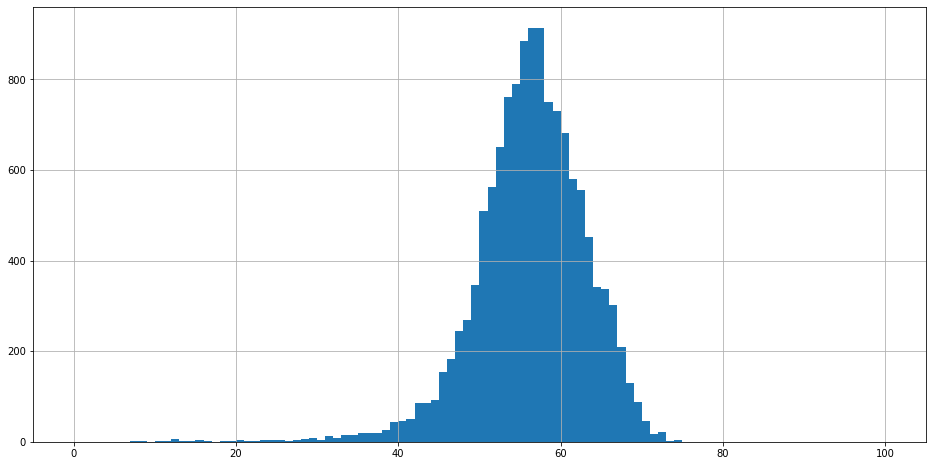

In [102]:
plt.figure(figsize = (16,8))
full_conc_data['feed'].hist(bins = 100, range = (0,100))

Сырьевой этап. Помимо длинного "хвоста" в направлении начала координат, распределение значений абсолютно стандартно.

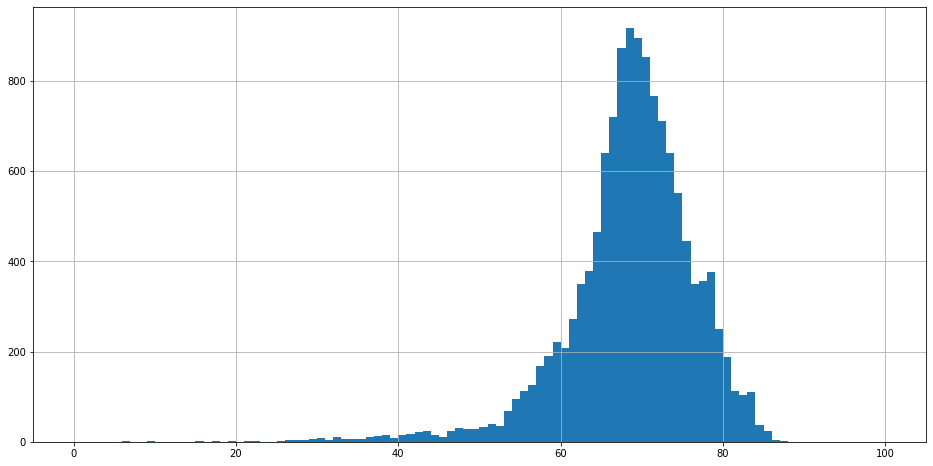

In [103]:
plt.figure(figsize = (16,8))
full_conc_data['rough_conc'].hist(bins = 100, range = (0,100))

Черновой концентрат по сравнению с сырьем содержит большую долю ФИКСИРУЕМЫХ веществ - тех, чья концентрация 1) важна экономически, 2) больше определенно порогового значения, 3) важна технологически. При это мы также наблюдаем знакомый нам по сырьевому материалу "хвост, а в дополнение к нему небольшой пик в районе 78% концентрации. 

И если к хвостам особых вопросов нет - их обработать проблемы не составит, то вот "минипик" не совсем очевиден. Попробуем построить аналогичную гистограмму по необработанным данным - на основе данных из "исходного" файла. И сравним их.

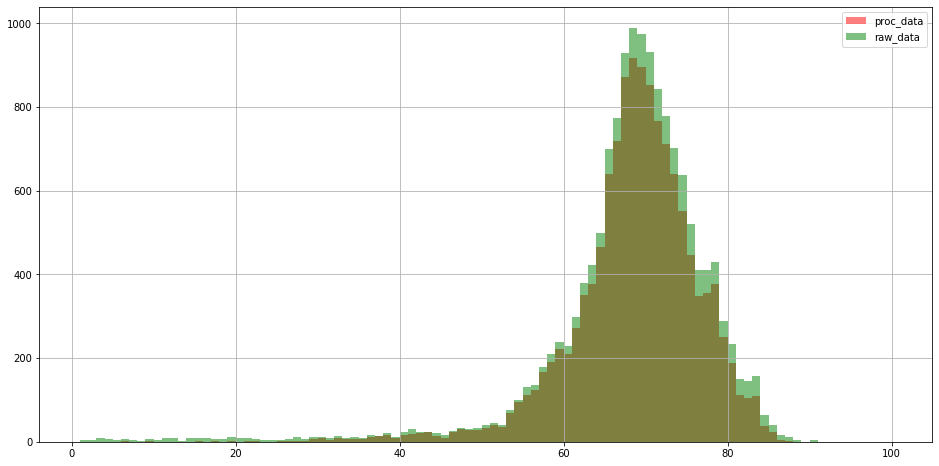

In [104]:
gold_data_train_sum = pd.DataFrame(data = [], columns = ['rough_conc_sum'])
gold_data_train_sum['rough_conc_sum'] = (gold_data_train['rougher.output.concentrate_au'] + 
                                         gold_data_train['rougher.output.concentrate_ag'] + 
                                         gold_data_train['rougher.output.concentrate_pb'] + 
                                         gold_data_train['rougher.output.concentrate_sol'])

plt.figure(figsize = (16,8))

# нули скрываем - они нам не нужны.
full_conc_data['rough_conc'].hist(bins = 99, range = (1,100), color = 'red', alpha = 0.5)
gold_data_train_sum['rough_conc_sum'].hist(bins = 99, range = (1,100), color = 'green', alpha = 0.5)
plt.legend(['proc_data', 'raw_data'])

В целом - разницы нет никакой, а "минипик" по-прежнему на месте. Вероятно, это указатель на возможное "слияние" 2 различных нормальных распределений и, как следствие, существование 2 принципиально различных по своей сути (!) процессов, причем первый встречается не в пример чаще второго, однако, второй позволяет получать в среднем ЛУЧШИЕ результаты. Однако, "расследование" этого вопроса требует дополнительных сведений со стороны производителя - а этого у нас, к сожалению нет.

Переходим к концентрату первичной обработки.

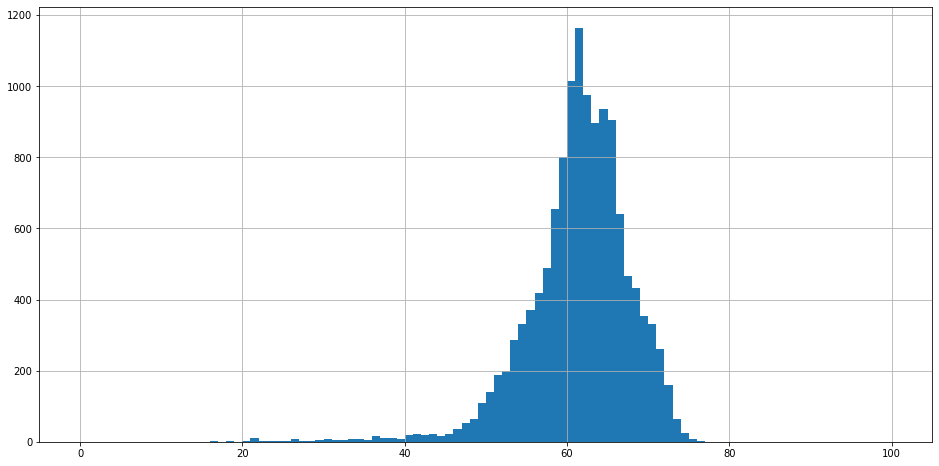

In [105]:
plt.figure(figsize = (16,8))
full_conc_data['prim_clean_conc'].hist(bins = 100, range = (0,100))

После первичной очистки мы, с одной стороны, наблюдаем небольшое снижение доли "контролируемых" веществ. С другой стороны, именно здесь наряду с небольшим хвостом и появляется то, что можно назвать аномалией - а именно, двойной пик. Предположение всё тоже - сочетание на графике 2 различных процессов, причем в этом случае они примерно "равны" по частоте проявления, но не равны по значению целевого показателя - концентрации "контролируемых" веществ. 

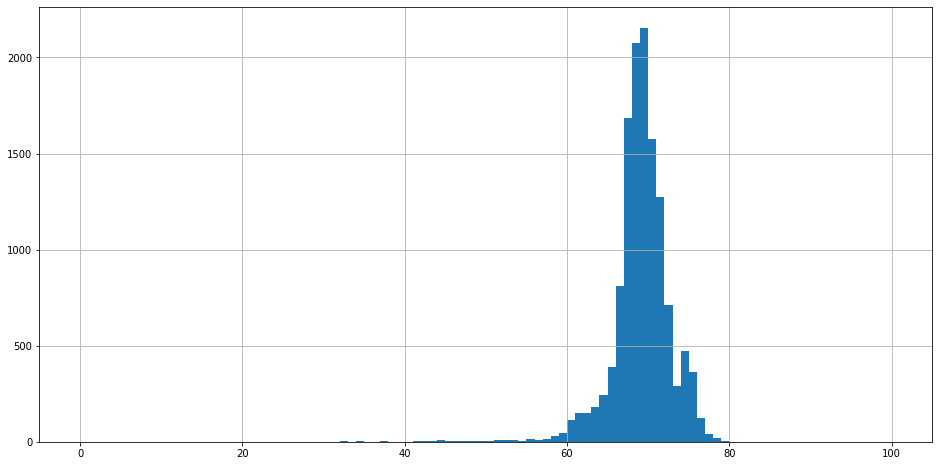

In [106]:
plt.figure(figsize = (16,8))
full_conc_data['final_conc'].hist(bins = 100, range = (0,100))

Артефакты те же - небольшой пик в области "высоких" значений концентрации + хвост. Возможные причины те же.

### 2.3.1 Обсуждение аномалий

Безусловно, наличие на кривых распредления дополнительных пиков представляет собой артефакт - аномалию, с которой неободимо как-то взаимодействовать. Тем не менее, в нашем случае, я считаю, что нет необходимости что-либо с ними делать, поскольку они не вносят существенного "разрдрая" в возможный процесс обучения модели - просто обучения будет включать в себя (само того не понимая) прогнозирование значений с учетом 2 возможных механизмов протекания процесса. 

Хотя, конечно, в идеальном мире, датасеты должны быть разделены, а модели обучены раздельно. Однако, нам эта опция не доступна (я не знаю как её реализовать).

Хвосты удаляем - причем сделать это стоит в границах не 1%, а как минимум (5 / 2 = ) 2.5% доверительного интервала. Они слишком малочислены и будут вносить лишь шум в процесс обучения модели. Эту гипотезу мы сможем подтвердить, обучив модели на 2 датасетах - с хвостами и без них.

In [107]:
quantile_0025_feed = full_conc_data['feed'].quantile(0.025)
full_conc_data_feed = full_conc_data[full_conc_data['feed'] > quantile_0025_feed]
full_conc_data_feed

,feed,rough_conc,prim_clean_conc,final_conc
0,51.680034,66.424950,72.640924,63.644396
1,50.659114,67.012710,72.543485,63.957723
2,50.609929,66.103793,72.095042,64.311180
3,51.061546,65.752751,59.957723,63.573449
4,47.859163,65.908382,71.321010,64.004667
...,...,...,...,...
16855,53.415050,70.781325,59.001692,68.098589
16856,53.696482,70.539603,59.703912,68.274362
16857,54.589604,55.376330,59.561096,68.226068
16858,54.027355,69.201689,57.216686,68.200449


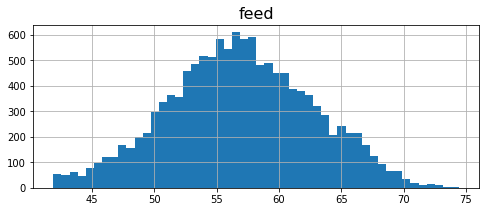

In [108]:
plt.figure(figsize = (8,3))
full_conc_data_feed['feed'].hist(bins = 50)
plt.title('feed', fontsize = 16)
plt.show()

Идеально.

In [109]:
quantile_0025_rough = full_conc_data['rough_conc'].quantile(0.025)
full_conc_data_rough = full_conc_data[full_conc_data['rough_conc'] > quantile_0025_rough]

quantile_0025_prim = full_conc_data['prim_clean_conc'].quantile(0.025)
full_conc_data_prim = full_conc_data[full_conc_data['prim_clean_conc'] > quantile_0025_prim]

quantile_0025_final = full_conc_data['final_conc'].quantile(0.025)
full_conc_data_final = full_conc_data[full_conc_data['final_conc'] > quantile_0025_final]

Объединим полученные датасеты (в каждом удален СВОЙ хвост) по ОБЩИМ индексам и посмотрим, что получилось / осталось.

In [110]:
full_concentrate_data = pd.concat([full_conc_data_feed['feed'], 
                                   full_conc_data_rough['rough_conc'], 
                                   full_conc_data_prim['prim_clean_conc'], 
                                   full_conc_data_final['final_conc']], axis = 1, join = 'inner')
full_concentrate_data

,feed,rough_conc,prim_clean_conc,final_conc
0,51.680034,66.424950,72.640924,63.644396
1,50.659114,67.012710,72.543485,63.957723
2,50.609929,66.103793,72.095042,64.311180
3,51.061546,65.752751,59.957723,63.573449
4,47.859163,65.908382,71.321010,64.004667
...,...,...,...,...
16855,53.415050,70.781325,59.001692,68.098589
16856,53.696482,70.539603,59.703912,68.274362
16857,54.589604,55.376330,59.561096,68.226068
16858,54.027355,69.201689,57.216686,68.200449


Осталось 12057 значений. Проверим наши "достижения, построив гистограммы распределения.

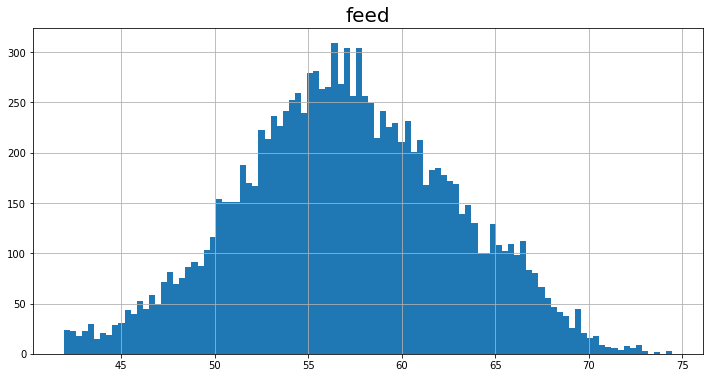

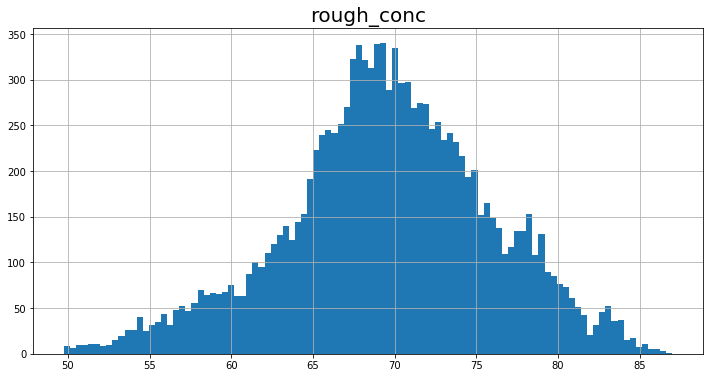

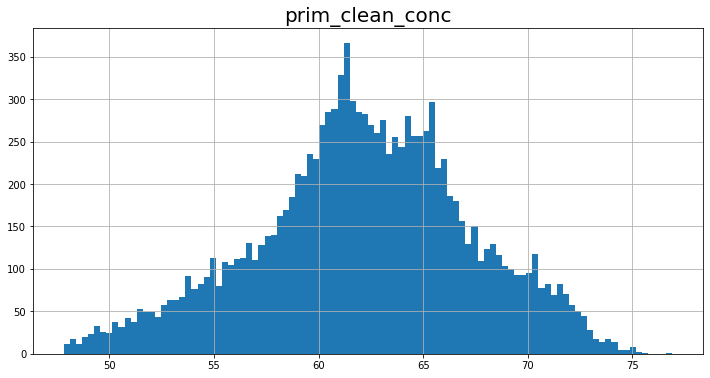

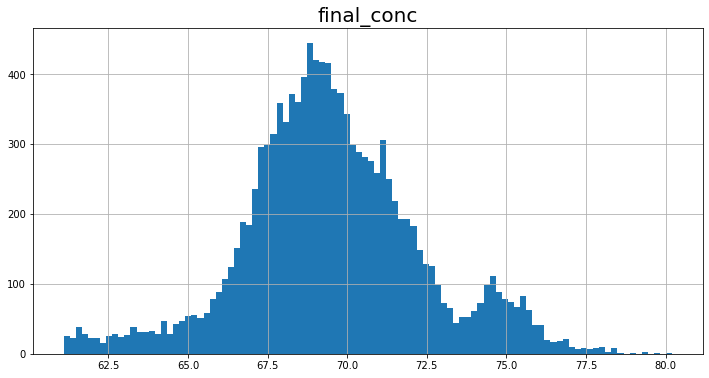

In [111]:
hist_plotter(full_concentrate_data)

Готово. На "очищенных" данных также стал заметен второй пик на на графике для сырья с вершиной в районе 65%.

Таким образом, наиболее РАБОЧАЯ версия на данный момент следующая - аномальный "пик" на кривых распределения ПОЛНОГО содержания металлов в составе смеси соответствует ДРУГОМУ исходному сырью - содержащему другое СРЕДНЕЕ соотношение исходных элементов. 

Второй тип сырья (с меньшим по числу значений пиком) позволяет получить ЛУЧШИЙ итоговый результат с т. зрения восстановления исходного сырья до концентрата (68% у 1го против 74 у 2го). В теории, наилучшим вариантом было бы УЗНАТЬ, как "проходит" граница между исходным сырьем и разработать 2 отдельные модели для оценки каждой из них. Это позволило бы получать БОЛЕЕ точный прогнозные значения. Однако, чего нет, того нет (по-крайней мере в нашем контексте "учебного" проекта).

С другой стороны - и это становится ясно, если вспомнить гистограмму плотности для РАЗМЕРОВ исходного сырья (см. ниже), вполне возможно, что такое расхождение соотвествует различному РАЗМЕРУ исходного сырье. Как следствие - вполне вероятно, что гранулы БОЛЬШЕГО размера позволяют получить ЛУЧШИЙ финальный концентрат и на исследование этого момента стоит сделать упор при дальнейшем развитии технологий обогащения. Однако, это пока только версия.

"Допиливаем" обучающие датасеты по новым границам и переходим к разработке модели машинного обучения.

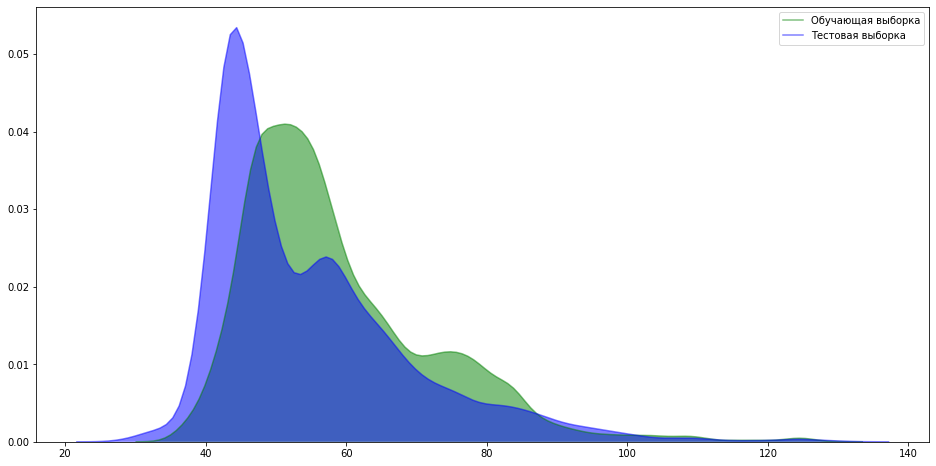

In [112]:
plt.figure(figsize = (16,8))
sns.kdeplot(train_gran_size_clean['train'], shade=True, color="green", label="Обучающая выборка", alpha=0.5)
sns.kdeplot(test_gran_size_clean['test'], shade=True, color="blue", label="Тестовая выборка", alpha=0.5)


In [113]:
data_rougher_train = pd.DataFrame(data = train_rougher_clean_size, index = full_concentrate_data.index)
len(data_rougher_train)

12057

In [114]:
data_cleaner_train = pd.DataFrame(data = train_cleaner_clean_size, index = full_concentrate_data.index)
data_cleaner_train.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


# 3. Модель

## 3.1 Функция для вычисления sMAPE

Напишите функцию для вычисления итоговой sMAPE.

На вход функция будет принимать 2 массива значений - "реальный" и "предсказанный".

In [115]:
def sMAPE_calc(true_data, pred_data):
    sMAPE = 0
    sum_data = pd.DataFrame(data = [], columns = ['numer', 'denom', 'div'])
           
    sum_data['numer'] = abs(true_data - pred_data)
    sum_data['denom'] = (abs(true_data) + abs(pred_data)) / 2
    sum_data['div'] = sum_data['numer'] / sum_data['denom']

    sMAPE = sum_data['div'].sum() * 100 / len(true_data)
        
    return sMAPE

## 3.2 Разработка предсказательное модели

Первое, что нам необходимо сделать - это понять, что мы собственно будем предсказывать?

Ответ дан в самом задании - предсказать нам необходимо значения коэффициентов восстановления руды на этапах флоатации и очистки.

Начнем с этапа флоатации - там и признаков поменьше и по логике процесса он первее всех. 

В первую очередь, нам необходимо подготовить датасет - освободить его от признаков, которые не будут принимать участие в работе модели. Определить их проще простого - их ТОЧНО НЕТ в тестовом датасете. Следовательно, на пересечении наборов признаков тестового и обучающего датасетов лежит истина.

Соберем соответствующий список.

In [116]:
train_clmns_clean = pd.Series(data_rougher_train.columns)
test_clmns_clean = pd.Series(test_data_clean_size.columns)

clmns_delta_new = train_clmns_clean.isin(test_clmns_clean)
train_rougher_columns_list = list(train_clmns_clean[clmns_delta_new[clmns_delta_new == True].index])
train_rougher_columns_list

['rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_level',
 'rougher.state.floatbank10_d_air',
 'rougher.state.floatbank10_d_level',
 'rougher.state.floatbank10_e_air',
 'rougher.state.floatbank10_e_level',
 'rougher.state.floatbank10_f_air',
 'rougher.state.floatbank10_f_level']

Остались только "инпуты" и "стейты" - никаких "аутпутов". Что логично. Нам нужно уметь прогнозировать по ИСХОДНЫМ данным, а никак не по УЖЕ ГОТОВОМУ. По нему прогнозы составлять не нужно - там уже всё и так понятно. 

Собираем тренировочный датасет.

In [117]:
rougher_train_features = pd.DataFrame(data = data_rougher_train, columns = train_rougher_columns_list)
rougher_train_features

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
0,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636
1,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,1000.286398,-400.065196,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001
2,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,999.719565,-400.074028,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147
3,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189,11.630094,6.203177,999.814770,-400.200179,1600.059442,-450.619948,1600.012842,-449.910497,1597.725177,-450.130127,1400.943157,-450.030142,1400.234743,-449.790835
4,6.060915,1.786875,540.531893,56.047189,34.347666,5.663707,10.957755,6.198826,999.678690,-399.752729,1600.208824,-449.599614,1600.357732,-450.034364,1599.759049,-449.909799,1401.560902,-448.877187,1401.160227,-450.407128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,6.091855,4.617558,560.889077,85.718304,37.369774,5.335862,7.762770,9.158609,1199.245914,-300.845518,1149.807890,-498.789721,1047.963596,-498.413079,946.640977,-499.152477,849.664935,-499.214461,849.758091,-497.448664
16856,6.121323,4.144989,559.031805,119.499241,38.591551,4.838619,7.356687,9.304952,1196.569267,-299.512227,1147.675196,-500.608341,1048.565741,-500.932810,949.773589,-500.023144,848.515225,-500.289405,850.013123,-496.822119
16857,5.970515,4.020002,555.682872,122.262690,40.074026,4.525061,6.586020,9.299606,1204.866639,-299.235675,1149.942902,-501.717903,1049.604390,-500.549053,952.702732,-502.352296,849.016017,-500.505677,850.455635,-506.897968
16858,6.048130,3.902537,544.731687,123.742430,39.713906,4.362781,6.210119,9.297709,1201.904177,-299.907308,1154.087804,-500.036580,1054.009756,-500.237335,944.138793,-496.866953,851.589767,-499.040466,851.345606,-499.122561


20 признаков, 12+ тысяч объектов, всё верно. Теперь выделим целевой признак и поместим его в отдельный датасет.

In [118]:
rougher_train_target = data_rougher_train['rougher.output.recovery']
rougher_train_target

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Name: rougher.output.recovery, Length: 12057, dtype: float64

Поскольку целевой признак качества складывается из 2 частей, сперва соберем все нужные исходные датасеты и лишь затем отправимся в направлении обучения и проверки моделей.

Логика сбора данных та же, только источник чуть другой.

In [119]:
train_clmns_cleaner = pd.Series(data_cleaner_train.columns)
test_clmns_clean = pd.Series(test_data_clean_size.columns)

clmns_delta_newer = train_clmns_cleaner.isin(test_clmns_clean)

train_cleaner_columns_list = list(train_clmns_cleaner[clmns_delta_newer[clmns_delta_newer == True].index])
train_cleaner_columns_list

['primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'secondary_cleaner.state.floatbank2_a_air',
 'secondary_cleaner.state.floatbank2_a_level',
 'secondary_cleaner.state.floatbank2_b_air',
 'secondary_cleaner.state.floatbank2_b_level',
 'secondary_cleaner.state.floatbank3_a_air',
 'secondary_cleaner.state.floatbank3_a_level',
 'secondary_cleaner.state.floatbank3_b_air',
 'secondary_cleaner.state.floatbank3_b_level',
 'secondary_cleaner.state.floatbank4_a_air',
 'secondary_cleaner.state.floatbank4_a_level',
 'secondary_cleaner.state.floatbank4_b_air',
 

30 признаков. Однако! Поскольку ИТОГОВЫЙ - ФИНАЛЬНЫЙ коэффициент восстановления рассчитывается с учетом значений концентрации ценных металлов в СЫРЬЕ, я считаю верным и необходимым ввести соответствующие значения и в данный датасет. Это 4 признака - по 1 на каждый из ценных металлов. 

Верность моего решения покажет sMAPE. А пока подготовим 2 датасета - первый из 30 признаков, второй из 34 признаков (+ 4 концентрации сырья).

In [120]:
cleaner_train_features_1 = pd.DataFrame(data = data_cleaner_train, columns = train_cleaner_columns_list)
cleaner_train_features_1

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,-500.888152,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,123.381787,8.028927,6.50,1.304232,1648.421193,-400.382169,1648.742005,-400.359661,1648.578230,-399.363624,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
16856,120.878188,7.962636,6.50,1.302419,1649.820162,-399.930973,1649.357538,-399.721222,1648.656192,-401.195834,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
16857,105.666118,7.955111,6.50,1.315926,1649.166761,-399.888631,1649.196904,-399.677571,1647.896999,-399.988275,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
16858,98.880538,7.984164,6.50,1.241969,1646.547763,-398.977083,1648.212240,-400.383265,1648.917387,-399.521344,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


In [121]:
add_features_cleaner = rougher_train_features.loc[:, ['rougher.input.feed_au', 'rougher.input.feed_ag',
                                                      'rougher.input.feed_pb', 'rougher.input.feed_sol']]


cleaner_train_features_2 = pd.concat([cleaner_train_features_1, add_features_cleaner], axis = 1, join = 'inner')
cleaner_train_features_2

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol
0,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,...,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,6.486150,6.100378,2.284912,36.808594
1,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,...,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,6.478583,6.161113,2.266033,35.753385
2,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,...,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,6.362222,6.116455,2.159622,35.971630
3,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,...,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,6.118189,6.043309,2.037807,36.862241
4,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,-500.888152,...,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,5.663707,6.060915,1.786875,34.347666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,123.381787,8.028927,6.50,1.304232,1648.421193,-400.382169,1648.742005,-400.359661,1648.578230,-399.363624,...,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428,5.335862,6.091855,4.617558,37.369774
16856,120.878188,7.962636,6.50,1.302419,1649.820162,-399.930973,1649.357538,-399.721222,1648.656192,-401.195834,...,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608,4.838619,6.121323,4.144989,38.591551
16857,105.666118,7.955111,6.50,1.315926,1649.166761,-399.888631,1649.196904,-399.677571,1647.896999,-399.988275,...,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452,4.525061,5.970515,4.020002,40.074026
16858,98.880538,7.984164,6.50,1.241969,1646.547763,-398.977083,1648.212240,-400.383265,1648.917387,-399.521344,...,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471,4.362781,6.048130,3.902537,39.713906


In [122]:
cleaner_train_target = data_cleaner_train['final.output.recovery']
cleaner_train_target

0        70.541216
1        69.266198
2        68.116445
3        68.347543
4        66.927016
           ...    
16855    73.755150
16856    69.049291
16857    67.002189
16858    65.523246
16859    70.281454
Name: final.output.recovery, Length: 12057, dtype: float64

С обучающими данными разобрались.

Итого, у нас есть 2 (3) разделенных датасета для обучения и валидации результатов:
- rougher_train_features и rougher_train_target
- cleaner_train_features_1 (cleaner_train_features_2) и cleaner_train_target

Нарежем их на обучающий и валидационные датасеты и начнем "веселье". Для пятикратной проверки в процессе кросс-валидации делим в соотношении 80:20.

In [123]:
(r_features_train, r_features_valid,
 r_target_train, r_target_valid) = train_test_split(rougher_train_features,
                                                     rougher_train_target, test_size=0.2, random_state=11111)
r_features_train.shape

(9645, 20)

In [124]:
r_target_valid.shape

(2412,)

Время моделей. 

Их будет 3 типа:
- линейная регрессия
- обучающее древо
- случайный лес

### 3.2.1 Линейная регрессия

In [125]:
model_linreg = LinearRegression()
model_linreg.fit(r_features_train, r_target_train)
    
predicted_valid_rougher = model_linreg.predict(r_features_valid)
predicted_valid_r = pd.Series(data = predicted_valid_rougher)
predicted_valid_r

0       81.267236
1       93.866909
2       73.700643
3       92.588246
4       82.012508
          ...    
2407    79.490928
2408    84.566176
2409    77.757311
2410    79.602372
2411    77.349966
Length: 2412, dtype: float64

In [126]:
r_target_valid = r_target_valid.reset_index(drop = True)
r_target_valid

0       79.894172
1       88.281415
2       74.210288
3       93.848407
4       76.793932
          ...    
2407    84.306873
2408    85.527120
2409    78.091674
2410    77.161725
2411    80.692044
Name: rougher.output.recovery, Length: 2412, dtype: float64

In [127]:
sMAPE_linreg_rougher = sMAPE_calc(r_target_valid, predicted_valid_r)
sMAPE_linreg_rougher

4.723484472495802

Линейная регрессия выдала нам значение sMAPE равное 4.72%. Много это или мало, точно это или не точно пока непонятно - сравнивать то не с чем. Но перед этим воспользуемся кросс-валидацией и "подтвердим" полученный результат.

In [128]:
cv_prediction_linreg_rougher = cross_val_predict(model_linreg, rougher_train_features, y = rougher_train_target, cv = 5)
cv_prediction_linreg_rougher = pd.Series(cv_prediction_linreg_rougher)
cv_prediction_linreg_rougher

0        82.600998
1        82.076490
2        82.226562
3        82.278293
4        81.201313
           ...    
12052    84.930089
12053    84.200512
12054    84.628561
12055    84.337686
12056    85.081538
Length: 12057, dtype: float64

Итак, у нас есть предсказания для всего датасета целиком - можно было даже самому ничего не делить. Найдем sMAPE для полученных предсказания.

In [129]:
%%time
rougher_train_target_ser = pd.Series(rougher_train_target).reset_index(drop = True)
sMAPE_linreg_rougher_cv = sMAPE_calc(rougher_train_target_ser, cv_prediction_linreg_rougher)
sMAPE_linreg_rougher_cv

Wall time: 11 ms


6.326090309681216

А вот для всего датасета в целом, значение sMAPE оказалось больше, чем для 1 его части. Так и запишем. Куда? Конечно же в сводную таблицу.

In [130]:
sMAPE_table = pd.DataFrame(data = [], columns = ['model_name', 'rougher_sMAPE', 'cleaner_sMAPE', 'final_sMAPE'])

def sMAPE_table_filler(number, model_name, stage, sMAPE):
    sMAPE_table.loc[number, 'model_name'] = model_name
    if stage == 'rougher':
        sMAPE_table.loc[number, 'rougher_sMAPE'] = sMAPE
    else:
        sMAPE_table.loc[number, 'cleaner_sMAPE'] = sMAPE
    return sMAPE_table
    
sMAPE_table_filler(0, 'Линейная регрессия','rougher', sMAPE_linreg_rougher_cv)

,model_name,rougher_sMAPE,cleaner_sMAPE,final_sMAPE
0,Линейная регрессия,6.32609,NaN,NaN


Теперь сделаем все тоже самое для стадии очистки.

In [131]:
cv_prediction_linreg_cleaner_1 = cross_val_predict(model_linreg, cleaner_train_features_1, y = cleaner_train_target, cv = 5)
cv_prediction_linreg_cleaner_1 = pd.Series(cv_prediction_linreg_cleaner_1)
cv_prediction_linreg_cleaner_1

0        66.050123
1        66.210782
2        66.114332
3        66.192863
4        66.280387
           ...    
12052    65.580589
12053    65.457468
12054    68.131829
12055    66.816020
12056    63.934518
Length: 12057, dtype: float64

In [132]:
%%time
cleaner_train_target_ser = pd.Series(cleaner_train_target).reset_index(drop = True)
sMAPE_linreg_cleaner_cv_1 = sMAPE_calc(cleaner_train_target_ser, cv_prediction_linreg_cleaner_1)
sMAPE_linreg_cleaner_cv_1

Wall time: 11.5 ms


8.982655957210488

In [133]:
sMAPE_table_filler(0, 'Линейная регрессия','cleaner', sMAPE_linreg_cleaner_cv_1)

,model_name,rougher_sMAPE,cleaner_sMAPE,final_sMAPE
0,Линейная регрессия,6.32609,8.98266,NaN


А теперь для второго датасета.

In [134]:
cv_prediction_linreg_cleaner_2 = cross_val_predict(model_linreg, cleaner_train_features_2, y = cleaner_train_target, cv = 5)
cv_prediction_linreg_cleaner_2 = pd.Series(cv_prediction_linreg_cleaner_2)
cv_prediction_linreg_cleaner_2

0        66.902275
1        67.104551
2        67.134384
3        67.177940
4        66.690225
           ...    
12052    56.991726
12053    57.141373
12054    58.692350
12055    57.562450
12056    55.375545
Length: 12057, dtype: float64

In [135]:
%%time
cleaner_train_target_ser = pd.Series(cleaner_train_target).reset_index(drop = True)
sMAPE_linreg_cleaner_cv_2 = sMAPE_calc(cleaner_train_target_ser, cv_prediction_linreg_cleaner_2)
sMAPE_linreg_cleaner_cv_2

Wall time: 16 ms


9.396331482791977

In [136]:
sMAPE_table_filler(1, 'Линейная регрессия_2','cleaner', sMAPE_linreg_cleaner_cv_2)
sMAPE_table_filler(1, 'Линейная регрессия_2','rougher', sMAPE_linreg_rougher_cv)

,model_name,rougher_sMAPE,cleaner_sMAPE,final_sMAPE
0,Линейная регрессия,6.32609,8.98266,NaN
1,Линейная регрессия_2,6.32609,9.39633,NaN


Переходим к решающему дереву.

### 3.2.2 Решающее дерево

Я точно знаю, что мне будет необходимо определить не только sMAPE, но и глубину решающего древа. Поэтому, я сразу напишу соответствующую функцию, которая будет это делать. Без лишних строк кода и слов - встречайте, функция!!1

In [137]:
%%time

def dectree_hyper_finder(features, target, min_depth, max_depth, step):
    sMAPE_min = 100
    depth_target = 0
    for depth in range(min_depth, max_depth+1, step):
        
#         обучаем параллельно с кросс-валидацией
        model_dectree = DecisionTreeRegressor(max_depth = depth, random_state = 11111)
        cv_prediction_dectree = cross_val_predict(model_dectree, features, y = target, cv = 5)
        cv_prediction_dectree_ser = pd.Series(cv_prediction_dectree)

#         определяем sMAPE для полученного предсказания
        
        target_ser = pd.Series(target).reset_index(drop = True)
        sMAPE_dectree_cv = sMAPE_calc(target_ser, cv_prediction_dectree_ser)
        
#         ищем глубину с минимальным значением sMAPE
        if sMAPE_dectree_cv < sMAPE_min:
            sMAPE_min = sMAPE_dectree_cv
            depth_target = depth
    
    return sMAPE_min, depth_target

dectree_hyper_finder(rougher_train_features, rougher_train_target, 2, 52, 5)    

Wall time: 12 s


(6.596479215083383, 2)

In [138]:
sMAPE_dectree_rougher, dectree_best_depth = dectree_hyper_finder(rougher_train_features, rougher_train_target, 2, 7, 1)
sMAPE_dectree_rougher, dectree_best_depth

(6.469470361544692, 5)

Решающее древо с глубиной равной 5 позволяет получить наименьшее значение ошибки sMAPE. Занесем в таблицу и продолжим дальше.

In [139]:
sMAPE_table_filler(2, 'Решающее древо','rougher', sMAPE_dectree_rougher)

,model_name,rougher_sMAPE,cleaner_sMAPE,final_sMAPE
0,Линейная регрессия,6.32609,8.98266,NaN
1,Линейная регрессия_2,6.32609,9.39633,NaN
2,Решающее древо,6.46947,NaN,NaN


Теперь для стадии очистки.

In [140]:
%%time
dectree_hyper_finder(cleaner_train_features_1, cleaner_train_target, 2, 52, 5)    

Wall time: 18.9 s


(10.25362266380069, 2)

In [141]:
%%time
sMAPE_dectree_cleaner_1, dectree_best_depth = dectree_hyper_finder(cleaner_train_features_1, cleaner_train_target, 2, 7, 1)
sMAPE_dectree_cleaner_1, dectree_best_depth

Wall time: 3.64 s


(10.25362266380069, 2)

In [142]:
sMAPE_table_filler(2, 'Решающее древо','cleaner', sMAPE_dectree_cleaner_1)

,model_name,rougher_sMAPE,cleaner_sMAPE,final_sMAPE
0,Линейная регрессия,6.32609,8.98266,NaN
1,Линейная регрессия_2,6.32609,9.39633,NaN
2,Решающее древо,6.46947,10.2536,NaN


Второй датасет.

In [143]:
%%time
dectree_hyper_finder(cleaner_train_features_2, cleaner_train_target, 2, 52, 5)    

Wall time: 21.6 s


(8.907110923061303, 2)

In [144]:
sMAPE_dectree_cleaner_2, dectree_best_depth = dectree_hyper_finder(cleaner_train_features_2, cleaner_train_target, 2, 7, 1)
sMAPE_dectree_cleaner_2, dectree_best_depth

(8.907110923061303, 2)

In [145]:
sMAPE_table_filler(3, 'Решающее древо_2','rougher', sMAPE_dectree_rougher)
sMAPE_table_filler(3, 'Решающее древо_2','cleaner', sMAPE_dectree_cleaner_2)

,model_name,rougher_sMAPE,cleaner_sMAPE,final_sMAPE
0,Линейная регрессия,6.32609,8.98266,NaN
1,Линейная регрессия_2,6.32609,9.39633,NaN
2,Решающее древо,6.46947,10.2536,NaN
3,Решающее древо_2,6.46947,8.90711,NaN


А теперь случайный лес.

### 3.2.2 Случайный лес

И нам снова нужна функция для автоматизации поиска соответствующих параметров. Напишем, запустим, посмотрим.

In [146]:
def rndforest_est_finder(features, target, min_est, max_est, step):
    sMAPE_min = 100
    est_target = 0
    for estim in range(min_est, max_est+1, step):
        
#         обучаем параллельно с кросс-валидацией
        model_rndforest = RandomForestRegressor(n_estimators = estim, random_state = 11111)
        cv_prediction_rndforest = cross_val_predict(model_rndforest, features, y = target, cv = 5)
        cv_prediction_rndforest_ser = pd.Series(cv_prediction_rndforest)

#         определяем sMAPE для полученного предсказания
        
        target_ser = pd.Series(target).reset_index(drop = True)
        sMAPE_rndforest_cv = sMAPE_calc(target_ser, cv_prediction_rndforest_ser)
        
#         ищем глубину с минимальным значением sMAPE
        if sMAPE_rndforest_cv < sMAPE_min:
            sMAPE_min = sMAPE_rndforest_cv
            est_target = estim
    
    return sMAPE_min, est_target

In [147]:
%%time
rndforest_est_finder(rougher_train_features, rougher_train_target, 2, 22, 5)    

Wall time: 45.1 s


(6.086970533750738, 17)

In [148]:
%%time
rndforest_est_finder(rougher_train_features, rougher_train_target, 12, 22, 2)   

Wall time: 1min 12s


(6.070371460995027, 18)

In [149]:
%%time
rndforest_est_finder(rougher_train_features, rougher_train_target, 16, 20, 1)   

Wall time: 1min


(6.070371460995027, 18)

Решателей в лесу посчитали, теперь найдем глубину.

In [150]:
def rndforest_depth_finder(features, target, estimators, min_depth, max_depth, step):
    sMAPE_min = 100
    depth_target = 0
    for depth in range(min_depth, max_depth+1, step):
        
#         обучаем параллельно с кросс-валидацией
        model_rndforest = RandomForestRegressor(n_estimators = estimators, max_depth = depth, random_state = 11111)
        cv_prediction_rndforest = cross_val_predict(model_rndforest, features, y = target, cv = 5)
        cv_prediction_rndforest_ser = pd.Series(cv_prediction_rndforest)

#         определяем sMAPE для полученного предсказания
        
        target_ser = pd.Series(target).reset_index(drop = True)
        sMAPE_rndforest_cv = sMAPE_calc(target_ser, cv_prediction_rndforest_ser)
        
#         ищем глубину с минимальным значением sMAPE
        if sMAPE_rndforest_cv < sMAPE_min:
            sMAPE_min = sMAPE_rndforest_cv
            depth_target = depth
    
    return sMAPE_min, depth_target

In [151]:
%%time
rndforest_depth_finder(rougher_train_features, rougher_train_target, 18, 2, 32, 5)

Wall time: 1min 3s


(6.106088922767085, 7)

In [152]:
%%time
rndforest_depth_finder(rougher_train_features, rougher_train_target, 18, 2, 12, 2)

Wall time: 34.2 s


(6.011280645574828, 10)

In [153]:
%%time
sMAPE_rndforest_rougher, rndforest_best_depth = rndforest_depth_finder(rougher_train_features,
                                                                       rougher_train_target, 18, 8, 12, 1)
sMAPE_rndforest_rougher, rndforest_best_depth

Wall time: 38.8 s


(6.011280645574828, 10)

In [154]:
sMAPE_table_filler(4, 'Случайный лес','rougher', sMAPE_rndforest_rougher)

,model_name,rougher_sMAPE,cleaner_sMAPE,final_sMAPE
0,Линейная регрессия,6.32609,8.98266,NaN
1,Линейная регрессия_2,6.32609,9.39633,NaN
2,Решающее древо,6.46947,10.2536,NaN
3,Решающее древо_2,6.46947,8.90711,NaN
4,Случайный лес,6.01128,NaN,NaN


И для стадии очистки. 

Первый вариант данных.

In [155]:
%%time
rndforest_est_finder(cleaner_train_features_1, cleaner_train_target, 2, 22, 5)    

Wall time: 2min 4s


(12.64227485855033, 22)

In [156]:
%%time
rndforest_est_finder(cleaner_train_features_1, cleaner_train_target, 17, 27, 2)    

Wall time: 6min 49s


(12.595660585632107, 23)

In [157]:
%%time
rndforest_est_finder(cleaner_train_features_1, cleaner_train_target, 21, 25, 1)    

Wall time: 5min 59s


(12.595660585632107, 23)

> С вами снова Дмитрий из будущего. Пишу этот комментарий после оптимизации функции расчета sMAPE. В случае случайного леса, львиную долю времени занимает именно обучение модели и прогнозирование результатов - здесь снижение длительности работы ячейки существенно ниже, чем для решающего древа. Это важно!

Теперь глубина.

In [158]:
%%time
rndforest_depth_finder(cleaner_train_features_1, cleaner_train_target, 23, 2, 32, 5)

Wall time: 5min 50s


(11.172042631339778, 2)

In [159]:
%%time
sMAPE_rndforest_cleaner_1, rndforest_best_depth =  rndforest_depth_finder(cleaner_train_features_1,
                                                                          cleaner_train_target, 23, 2, 7, 1 )
sMAPE_rndforest_cleaner_1, rndforest_best_depth

Wall time: 1min 55s


(11.172042631339778, 2)

In [160]:
sMAPE_table_filler(4, 'Случайный лес','cleaner', sMAPE_rndforest_cleaner_1)

,model_name,rougher_sMAPE,cleaner_sMAPE,final_sMAPE
0,Линейная регрессия,6.32609,8.98266,NaN
1,Линейная регрессия_2,6.32609,9.39633,NaN
2,Решающее древо,6.46947,10.2536,NaN
3,Решающее древо_2,6.46947,8.90711,NaN
4,Случайный лес,6.01128,11.172,NaN


Толпа глупых деревьев глубиной 2 позволила получить пока что "худшие" результаты на этапе очистки.

Посмотрим, что мы сможем получить для второго датасета.

In [161]:
%%time
rndforest_est_finder(cleaner_train_features_2, cleaner_train_target, 2, 22, 5)    

Wall time: 3min 44s


(11.62006790930402, 22)

In [162]:
%%time
rndforest_est_finder(cleaner_train_features_2, cleaner_train_target, 17, 27, 2)    

Wall time: 7min 12s


(11.63223777936713, 21)

In [163]:
%%time
rndforest_est_finder(cleaner_train_features_2, cleaner_train_target, 19, 23, 1)    

Wall time: 5min 20s


(11.62006790930402, 22)

И снова глубина.

Но на этот раз - "последняя".

In [164]:
%%time
rndforest_depth_finder(cleaner_train_features_2, cleaner_train_target, 22, 2, 32, 5)

Wall time: 5min 40s


(8.523029131321564, 2)

In [165]:
%%time
sMAPE_rndforest_cleaner_2, rndforest_best_depth = rndforest_depth_finder(cleaner_train_features_2, 
                                                                         cleaner_train_target, 22, 2, 7, 1)
sMAPE_rndforest_cleaner_2, rndforest_best_depth

Wall time: 1min 30s


(8.523029131321564, 2)

In [166]:
sMAPE_table_filler(5, 'Случайный лес_2','rougher', sMAPE_rndforest_rougher)
sMAPE_table_filler(5, 'Случайный лес_2','cleaner', sMAPE_rndforest_cleaner_2)

,model_name,rougher_sMAPE,cleaner_sMAPE,final_sMAPE
0,Линейная регрессия,6.32609,8.98266,NaN
1,Линейная регрессия_2,6.32609,9.39633,NaN
2,Решающее древо,6.46947,10.2536,NaN
3,Решающее древо_2,6.46947,8.90711,NaN
4,Случайный лес,6.01128,11.172,NaN
5,Случайный лес_2,6.01128,8.52303,NaN


Победа!

Теперь найдем итоговое значение sMAPE для различных моделей и "входных" датасетов и перейдем к тестированию полученных моделей.

In [167]:
sMAPE_table['final_sMAPE'] = sMAPE_table['rougher_sMAPE'] * 0.25 + sMAPE_table['cleaner_sMAPE'] * 0.75
sMAPE_table.sort_values(by = 'final_sMAPE')

,model_name,rougher_sMAPE,cleaner_sMAPE,final_sMAPE
5,Случайный лес_2,6.01128,8.52303,7.89509
3,Решающее древо_2,6.46947,8.90711,8.2977
0,Линейная регрессия,6.32609,8.98266,8.31851
1,Линейная регрессия_2,6.32609,9.39633,8.62877
2,Решающее древо,6.46947,10.2536,9.30758
4,Случайный лес,6.01128,11.172,9.88185


Итоговая таблица - на экране.

Наилучшие результаты на обучающей выборке (с учетом кросс-валидации) получены для модели случайног леса с 34 признаками.
Однако по времени работы данная модель уступает как решающему древу, так и линейной регрессии. Тем не менее, выводы можно будет сделать только после тестирования полученных моделей.

> Я буду очень благодарен, если вы предложите мне альтернативные модели, способы оптимизации всего того, что я сделал - в первую очередь, для сокращения времени обработки всей этой радости.

## 3.3 Тестирование

Для тестирования нам потребуется не только "входные" данные из тестового датасета, но и "реальные" значения. Их можно получить из датасета с шильдиком "full". Этим сейчас и займемся - получим необходимые нам "true" значения для этапов флоатации и очистки. 

Для этого нам потребуется обратиться к значениям столбца "дата", посколько дата - это единственный вариант найти нужные нам объекты (после предобработки, удаления пропусков и т.д.). 

Откроем датасет "full".

In [168]:
# gold_data_full = pd.read_csv('/datasets/gold_recovery_full.csv')
# gold_data_full.head()

gold_data_full = pd.read_csv('gold_recovery_full.csv')
gold_data_full

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22711,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
22712,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
22713,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
22714,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


Как я и говорил - по индексам извлечь отсюда интересующие нас значения мы не сможем. Поэтому, воспользуемся столбцом дата. Но перед этим удадим из обработанного тестового датасета все пропуски и добавим в него столбец с датой-временем.

Значения содержатся в датасете "test_data_clean_size".

In [169]:
recovery_data_full = pd.DataFrame(data = [])
recovery_data_full['date'] = gold_data_full['date']
recovery_data_full['rougher.output.recovery'] = gold_data_full['rougher.output.recovery']
recovery_data_full['final.output.recovery'] = gold_data_full['final.output.recovery']

recovery_data_full.index = list(recovery_data_full['date'])
recovery_data_full = recovery_data_full.drop(['date'], axis = 1)
recovery_data_full

,rougher.output.recovery,final.output.recovery
2016-01-15 00:00:00,87.107763,70.541216
2016-01-15 01:00:00,86.843261,69.266198
2016-01-15 02:00:00,86.842308,68.116445
2016-01-15 03:00:00,87.226430,68.347543
2016-01-15 04:00:00,86.688794,66.927016
...,...,...
2018-08-18 06:59:59,89.574376,73.755150
2018-08-18 07:59:59,87.724007,69.049291
2018-08-18 08:59:59,88.890579,67.002189
2018-08-18 09:59:59,89.858126,65.523246


In [170]:
test_data_helper = pd.DataFrame(data = test_data_clean_size)
test_data_helper['date'] = gold_data_test['date']
test_data_helper.index = list(test_data_helper['date'])
test_data_helper

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
2016-09-01 00:59:59,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:59:59,2017-12-31 19:59:59,173.957757,15.963399,8.070000,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,...,13.995957,-500.157454,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909
2017-12-31 20:59:59,2017-12-31 20:59:59,172.910270,16.002605,8.070000,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,...,16.749781,-496.031539,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761
2017-12-31 21:59:59,2017-12-31 21:59:59,171.135718,15.993669,8.070000,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,...,19.994130,-499.791312,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882
2017-12-31 22:59:59,2017-12-31 22:59:59,179.697158,15.438979,8.070000,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,...,19.958760,-499.958750,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284


In [171]:
test_target = pd.DataFrame(data = recovery_data_full, index = test_data_helper.index)
test_target

,rougher.output.recovery,final.output.recovery
2016-09-01 00:59:59,89.993421,70.273583
2016-09-01 01:59:59,88.089657,68.910432
2016-09-01 02:59:59,88.412756,68.143213
2016-09-01 03:59:59,87.360133,67.776393
2016-09-01 04:59:59,83.236367,61.467078
...,...,...
2017-12-31 19:59:59,95.172585,68.919891
2017-12-31 20:59:59,94.575036,68.440582
2017-12-31 21:59:59,93.018138,67.092759
2017-12-31 22:59:59,92.599042,68.061186


In [172]:
rougher_test_target = pd.Series(data = test_target['rougher.output.recovery']).reset_index(drop = True)
rougher_test_target

0       89.993421
1       88.089657
2       88.412756
3       87.360133
4       83.236367
          ...    
5323    95.172585
5324    94.575036
5325    93.018138
5326    92.599042
5327    91.177695
Name: rougher.output.recovery, Length: 5328, dtype: float64

In [173]:
cleaner_test_target = pd.Series(data = test_target['final.output.recovery']).reset_index(drop = True)
cleaner_test_target

0       70.273583
1       68.910432
2       68.143213
3       67.776393
4       61.467078
          ...    
5323    68.919891
5324    68.440582
5325    67.092759
5326    68.061186
5327    71.699976
Name: final.output.recovery, Length: 5328, dtype: float64

Готово! 2 датасета с "обнуленными" индексами получены. Теперь нам необходимо получить датасеты для прогнозирования значений.

Их по-прежнему будет 3 штуки - 1 для флоатации, 2 для очистки.

In [174]:
rougher_test_features = pd.DataFrame(data = test_data_clean_size,
                                     columns = rougher_train_features.columns).reset_index(drop = True)
rougher_test_features = rougher_test_features.dropna()
rougher_test_features

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
0,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807
1,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514
2,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340
3,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.503052,1001.930679,-400.437573,950.735324,-399.802986
4,11.327427,4.767383,488.248117,63.315324,41.269161,11.290425,13.607257,5.738081,996.541302,-350.562517,1304.658848,-399.511519,1306.455515,-399.050685,1248.699349,-400.876894,1058.839106,-398.988239,949.645313,-399.277632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5323,11.638973,4.695306,521.685155,66.758479,42.022027,10.554544,10.109194,7.203935,1399.935264,-299.999637,1049.641991,-500.074887,951.923857,-499.648793,852.337438,-498.464443,851.436769,-500.285584,851.461345,-499.735650
5324,11.338091,4.478381,530.195798,62.560684,41.096377,10.254051,9.979495,7.200895,1406.122319,-299.057200,1055.715243,-498.250207,956.850266,-497.403941,855.386714,-495.702676,852.071335,-499.442753,851.328986,-496.579809
5325,11.285908,4.405327,546.306868,73.647513,41.095485,10.169094,10.182219,7.196255,1396.203070,-300.210722,1047.879742,-499.604248,948.963429,-499.549567,856.325597,-500.095616,850.614597,-499.473713,850.279578,-498.508374
5326,11.289710,4.343488,547.331405,78.066446,41.715740,10.071156,10.730915,7.200058,1403.942288,-300.030119,1049.802289,-499.795576,950.769390,-500.374645,847.647198,-499.920332,849.413040,-500.380529,850.075026,-500.478250


In [175]:
cleaner_test_features_1 = pd.DataFrame(data = test_data_clean_size,
                                     columns = cleaner_train_features_1.columns).reset_index(drop = True)
cleaner_test_features_1

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5323,173.957757,15.963399,8.070000,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,-499.599127,...,13.995957,-500.157454,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909
5324,172.910270,16.002605,8.070000,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,-503.587739,...,16.749781,-496.031539,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761
5325,171.135718,15.993669,8.070000,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,-520.667442,...,19.994130,-499.791312,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882
5326,179.697158,15.438979,8.070000,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,-487.479567,...,19.958760,-499.958750,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284


In [176]:
cleaner_test_features_2 = pd.DataFrame(data = test_data_clean_size,
                                     columns = cleaner_train_features_2.columns).reset_index(drop = True)
cleaner_test_features_2

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,12.084103,13.128569,5.636710,42.022440
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,11.918977,13.036280,5.526065,41.187903
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,12.091332,13.138412,5.426561,42.546294
3,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,12.181597,12.400507,5.114758,41.060195
4,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,11.290425,11.327427,4.767383,41.269161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5323,173.957757,15.963399,8.070000,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,-499.599127,...,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909,10.554544,11.638973,4.695306,42.022027
5324,172.910270,16.002605,8.070000,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,-503.587739,...,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761,10.254051,11.338091,4.478381,41.096377
5325,171.135718,15.993669,8.070000,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,-520.667442,...,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882,10.169094,11.285908,4.405327,41.095485
5326,179.697158,15.438979,8.070000,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,-487.479567,...,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284,10.071156,11.289710,4.343488,41.715740


Готово. Последний этап - определить значение sMAPE для полученных датасетов и занести значения в итоговую таблицу.

In [177]:
def sMAPE_table_filler_test(model, row_number, test_features, test_target, stage):
    
    test_predictions = model.predict(test_features)
    test_pred_ser = pd.Series(data = test_predictions)
    sMAPE = sMAPE_calc(test_target, test_predictions)
        
    if stage == 'rougher':
        sMAPE_table.loc[row_number, 'rougher_sMAPE_test'] = sMAPE
    else:
        sMAPE_table.loc[row_number, 'cleaner_sMAPE_test'] = sMAPE

    return sMAPE_table

In [178]:
model_linreg_rougher_0 = LinearRegression()
model_linreg_rougher_0.fit(rougher_train_features, rougher_train_target)

sMAPE_table_filler_test(model_linreg_rougher_0, 0, rougher_test_features,
                        test_target['rougher.output.recovery'], 'rougher')

sMAPE_table_filler_test(model_linreg_rougher_0, 1, rougher_test_features,
                        test_target['rougher.output.recovery'], 'rougher')

,model_name,rougher_sMAPE,cleaner_sMAPE,final_sMAPE,rougher_sMAPE_test
0,Линейная регрессия,6.32609,8.98266,8.31851,7.983624
1,Линейная регрессия_2,6.32609,9.39633,8.62877,7.983624
2,Решающее древо,6.46947,10.2536,9.30758,NaN
3,Решающее древо_2,6.46947,8.90711,8.2977,NaN
4,Случайный лес,6.01128,11.172,9.88185,NaN
5,Случайный лес_2,6.01128,8.52303,7.89509,NaN


In [179]:
model_linreg_cleaner_0 = LinearRegression()
model_linreg_cleaner_0.fit(cleaner_train_features_1, cleaner_train_target)

sMAPE_table_filler_test(model_linreg_cleaner_0, 0, cleaner_test_features_1,
                        test_target['final.output.recovery'], 'cleaner')

,model_name,rougher_sMAPE,cleaner_sMAPE,final_sMAPE,rougher_sMAPE_test,cleaner_sMAPE_test
0,Линейная регрессия,6.32609,8.98266,8.31851,7.983624,9.353949
1,Линейная регрессия_2,6.32609,9.39633,8.62877,7.983624,NaN
2,Решающее древо,6.46947,10.2536,9.30758,NaN,NaN
3,Решающее древо_2,6.46947,8.90711,8.2977,NaN,NaN
4,Случайный лес,6.01128,11.172,9.88185,NaN,NaN
5,Случайный лес_2,6.01128,8.52303,7.89509,NaN,NaN


In [180]:
model_linreg_cleaner_1 = LinearRegression()
model_linreg_cleaner_1.fit(cleaner_train_features_2, cleaner_train_target)

sMAPE_table_filler_test(model_linreg_cleaner_1, 1, cleaner_test_features_2,
                        test_target['final.output.recovery'], 'cleaner')

,model_name,rougher_sMAPE,cleaner_sMAPE,final_sMAPE,rougher_sMAPE_test,cleaner_sMAPE_test
0,Линейная регрессия,6.32609,8.98266,8.31851,7.983624,9.353949
1,Линейная регрессия_2,6.32609,9.39633,8.62877,7.983624,8.942566
2,Решающее древо,6.46947,10.2536,9.30758,NaN,NaN
3,Решающее древо_2,6.46947,8.90711,8.2977,NaN,NaN
4,Случайный лес,6.01128,11.172,9.88185,NaN,NaN
5,Случайный лес_2,6.01128,8.52303,7.89509,NaN,NaN


Решающее древо. Гиперпараметры лучшей модели были подобраны нами ранее.

> Сейчас понял, что можно было сделать - для упрощения всей этой истории так, чтобы функция, находящаяя гиперпараметры по минимальному значению sMAPE возвращала ещё и обученную модель. Тогда некоторое число строк кода можно было бы избежать.

In [181]:
model_dectree_rougher_2 = DecisionTreeRegressor(max_depth = 5, random_state = 11111)
model_dectree_rougher_2.fit(rougher_train_features, rougher_train_target)

sMAPE_table_filler_test(model_dectree_rougher_2, 2, rougher_test_features,
                        test_target['rougher.output.recovery'], 'rougher')

sMAPE_table_filler_test(model_dectree_rougher_2, 3, rougher_test_features,
                        test_target['rougher.output.recovery'], 'rougher')

,model_name,rougher_sMAPE,cleaner_sMAPE,final_sMAPE,rougher_sMAPE_test,cleaner_sMAPE_test
0,Линейная регрессия,6.32609,8.98266,8.31851,7.983624,9.353949
1,Линейная регрессия_2,6.32609,9.39633,8.62877,7.983624,8.942566
2,Решающее древо,6.46947,10.2536,9.30758,8.073427,NaN
3,Решающее древо_2,6.46947,8.90711,8.2977,8.073427,NaN
4,Случайный лес,6.01128,11.172,9.88185,NaN,NaN
5,Случайный лес_2,6.01128,8.52303,7.89509,NaN,NaN


In [182]:
model_dectree_cleaner_2 = DecisionTreeRegressor(max_depth = 2, random_state = 11111)
model_dectree_cleaner_2.fit(cleaner_train_features_1, cleaner_train_target)

sMAPE_table_filler_test(model_dectree_cleaner_2, 2, cleaner_test_features_1,
                        test_target['final.output.recovery'], 'cleaner')

,model_name,rougher_sMAPE,cleaner_sMAPE,final_sMAPE,rougher_sMAPE_test,cleaner_sMAPE_test
0,Линейная регрессия,6.32609,8.98266,8.31851,7.983624,9.353949
1,Линейная регрессия_2,6.32609,9.39633,8.62877,7.983624,8.942566
2,Решающее древо,6.46947,10.2536,9.30758,8.073427,9.513737
3,Решающее древо_2,6.46947,8.90711,8.2977,8.073427,NaN
4,Случайный лес,6.01128,11.172,9.88185,NaN,NaN
5,Случайный лес_2,6.01128,8.52303,7.89509,NaN,NaN


In [183]:
model_dectree_cleaner_3 = DecisionTreeRegressor(max_depth = 2, random_state = 11111)
model_dectree_cleaner_3.fit(cleaner_train_features_2, cleaner_train_target)

sMAPE_table_filler_test(model_dectree_cleaner_3, 3, cleaner_test_features_2,
                        test_target['final.output.recovery'], 'cleaner')

,model_name,rougher_sMAPE,cleaner_sMAPE,final_sMAPE,rougher_sMAPE_test,cleaner_sMAPE_test
0,Линейная регрессия,6.32609,8.98266,8.31851,7.983624,9.353949
1,Линейная регрессия_2,6.32609,9.39633,8.62877,7.983624,8.942566
2,Решающее древо,6.46947,10.2536,9.30758,8.073427,9.513737
3,Решающее древо_2,6.46947,8.90711,8.2977,8.073427,10.273313
4,Случайный лес,6.01128,11.172,9.88185,NaN,NaN
5,Случайный лес_2,6.01128,8.52303,7.89509,NaN,NaN


И случайный лес.

In [184]:
model_rndforest_rougher_4 = RandomForestRegressor(n_estimators = 18, max_depth = 10, random_state = 11111)
model_rndforest_rougher_4.fit(rougher_train_features, rougher_train_target)

sMAPE_table_filler_test(model_rndforest_rougher_4, 4, rougher_test_features,
                        test_target['rougher.output.recovery'], 'rougher')

sMAPE_table_filler_test(model_rndforest_rougher_4, 5, rougher_test_features,
                        test_target['rougher.output.recovery'], 'rougher')

,model_name,rougher_sMAPE,cleaner_sMAPE,final_sMAPE,rougher_sMAPE_test,cleaner_sMAPE_test
0,Линейная регрессия,6.32609,8.98266,8.31851,7.983624,9.353949
1,Линейная регрессия_2,6.32609,9.39633,8.62877,7.983624,8.942566
2,Решающее древо,6.46947,10.2536,9.30758,8.073427,9.513737
3,Решающее древо_2,6.46947,8.90711,8.2977,8.073427,10.273313
4,Случайный лес,6.01128,11.172,9.88185,7.913246,NaN
5,Случайный лес_2,6.01128,8.52303,7.89509,7.913246,NaN


In [185]:
model_rndforest_cleaner_4 = RandomForestRegressor(n_estimators = 23, max_depth = 2, random_state = 11111)
model_rndforest_cleaner_4.fit(cleaner_train_features_1, cleaner_train_target)

sMAPE_table_filler_test(model_rndforest_cleaner_4, 4, cleaner_test_features_1,
                        test_target['final.output.recovery'], 'cleaner')

,model_name,rougher_sMAPE,cleaner_sMAPE,final_sMAPE,rougher_sMAPE_test,cleaner_sMAPE_test
0,Линейная регрессия,6.32609,8.98266,8.31851,7.983624,9.353949
1,Линейная регрессия_2,6.32609,9.39633,8.62877,7.983624,8.942566
2,Решающее древо,6.46947,10.2536,9.30758,8.073427,9.513737
3,Решающее древо_2,6.46947,8.90711,8.2977,8.073427,10.273313
4,Случайный лес,6.01128,11.172,9.88185,7.913246,9.341692
5,Случайный лес_2,6.01128,8.52303,7.89509,7.913246,NaN


In [186]:
model_rndforest_cleaner_5 = RandomForestRegressor(n_estimators = 22, max_depth = 2, random_state = 11111)
model_rndforest_cleaner_5.fit(cleaner_train_features_2, cleaner_train_target)

sMAPE_table_filler_test(model_rndforest_cleaner_5, 5, cleaner_test_features_2,
                        test_target['final.output.recovery'], 'cleaner')

,model_name,rougher_sMAPE,cleaner_sMAPE,final_sMAPE,rougher_sMAPE_test,cleaner_sMAPE_test
0,Линейная регрессия,6.32609,8.98266,8.31851,7.983624,9.353949
1,Линейная регрессия_2,6.32609,9.39633,8.62877,7.983624,8.942566
2,Решающее древо,6.46947,10.2536,9.30758,8.073427,9.513737
3,Решающее древо_2,6.46947,8.90711,8.2977,8.073427,10.273313
4,Случайный лес,6.01128,11.172,9.88185,7.913246,9.341692
5,Случайный лес_2,6.01128,8.52303,7.89509,7.913246,9.895692


In [187]:
sMAPE_table['final_sMAPE_test'] = sMAPE_table['rougher_sMAPE_test'] * 0.25 + sMAPE_table['cleaner_sMAPE_test'] * 0.75
sMAPE_table.sort_values(by = 'final_sMAPE_test')

,model_name,rougher_sMAPE,cleaner_sMAPE,final_sMAPE,rougher_sMAPE_test,cleaner_sMAPE_test,final_sMAPE_test
1,Линейная регрессия_2,6.32609,9.39633,8.62877,7.983624,8.942566,8.702830
4,Случайный лес,6.01128,11.172,9.88185,7.913246,9.341692,8.984581
0,Линейная регрессия,6.32609,8.98266,8.31851,7.983624,9.353949,9.011368
2,Решающее древо,6.46947,10.2536,9.30758,8.073427,9.513737,9.153660
5,Случайный лес_2,6.01128,8.52303,7.89509,7.913246,9.895692,9.400080
3,Решающее древо_2,6.46947,8.90711,8.2977,8.073427,10.273313,9.723342


In [188]:
sMAPE_final_version = pd.DataFrame(data = []) 

sMAPE_final_version['model_name'] = sMAPE_table['model_name']
sMAPE_final_version['sMAPE_test'] = sMAPE_table['final_sMAPE_test']
sMAPE_final_version['change_to_train, %'] = ((sMAPE_table['final_sMAPE_test'] - sMAPE_table['final_sMAPE']) * 100 / 
                                          sMAPE_table['final_sMAPE'])
sMAPE_final_version = sMAPE_final_version.sort_values(by = 'sMAPE_test')

Расчеты, обучения, построения закончены. Время делать выводы.

## Выводы

По итогам реализации проекта, наилучшие результаты на тестовой выборке получены для модели типа "линейная регрессия".

Для модели типа "случайный" лес также зафиксированы относительно "неплохие" результаты, однако, существенная вариативность полученных значений на различных выборках (тренировочной и тестовой) делает её использование менее целесообразным. 

В целом, значения sMAPE для всех моделей на тестовой выборке, находятся в диапазоне от 8 до 10%. Что это может значить с точки зрения производства и как мы можем это использовать необходимо решать совместно с представителем организации, предоставившей соответствующие данные. На данном этапе мы имеем только цифры.

Повышение точности прогнозирования может быть достигнуто за счет использования других моделей машинного обучения, а также дополнительной предобработки данных - как мы знаем, у любой ситуации есть альтернативные пути развития. Всегда. Вопрос только в их себестоимости (и вытекающей из этого показателя целесообразности).

In [189]:
sMAPE_final_version

,model_name,sMAPE_test,"change_to_train, %"
1,Линейная регрессия_2,8.702830,0.858283
4,Случайный лес,8.984581,-9.07999
0,Линейная регрессия,9.011368,8.32905
2,Решающее древо,9.153660,-1.65376
5,Случайный лес_2,9.400080,19.0623
3,Решающее древо_2,9.723342,17.1812


Полученные в ходе реализации проекта результаты также указывают на возможный потенциал доработки этапа первичной очистки чернового концентрата, в направлении повышения стабильности смеси (процесса?) - в перспективе это позволит получать более стабильный выход конечного продукта с УСТАНОВЛЕННЫМ значением содержания золота. 

Также рекомендуется обратить внимание на используемые в процессе флоатации сырьевые материалы - вероятно, среди них есть некий "недооцененный минерал", характеризующийся большими средними размерами, а также позволяющий получить на своей основе материал с повышенным содержание золотой руды. 

> Спасибо за внимание!

In [192]:
print("Всё посчиталось-открылось-добавилось за", math.ceil((time.time() - start_time)/60), "минут.")

Всё посчиталось-открылось-добавилось за 55 минут.
